# Do Not Overfit Challenge

#### Kaggle recently launched a challenge to run classification models on datasets with a very particular goal - do not overfit!!

#### Datasets had only 250 rows and features around 320. Since our number of independent features is greater than sample size, we are faced with a very pressing overfitting challenge.

##### Below I enumerate the methodology to reduce overfitting :

###### 1. Reduce feature size using two specific techniques: pearsons  correlation coefficient and dimensionality reduction techniques
###### 2. Create handful of samples with goal on simplicity. eg less number of estimators,less number of iterations etc
###### 3. Provide regularization parameters where applicable
###### 4. Plot precision-recall curves and roc-auc curves for each model. Check learning curve as well.
###### 5. Use StratifiedKFold cross validation to parameter tune
###### 6. Deal with imbalance in target classes using under sampling and over sampling techniques



Note: baseline model creation(using all features + regularization + tsne dimensionality reduction + over/under sampling) technique provided no real use. CV scores for roc auc did not exceed 0.6 in every scenario possible.






In [11]:
import numpy as np
import pandas as panda
from matplotlib import pyplot as plot
import seaborn as sns

import pandas as panda
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler,label_binarize

from sklearn.model_selection import train_test_split,KFold,\
    StratifiedKFold,GridSearchCV,RepeatedStratifiedKFold,learning_curve, cross_val_score

from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, \
        classification_report,confusion_matrix,average_precision_score
from sklearn.linear_model import Perceptron, LogisticRegression,RidgeClassifier,SGDClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from matplotlib import pyplot as plot
from itertools import cycle
import numpy as np 
from scipy import interp
import seaborn as sns
import itertools, time, datetime
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import mutual_info_classif,f_classif
from numpy import bincount, linspace, mean, std, arange, squeeze

import warnings

warnings.simplefilter('ignore')
%matplotlib inline


In [2]:
np.random.seed(143)

In [3]:
train_data = panda.read_csv('data/train.csv')


In [4]:
train_data.target.value_counts(), train_data.shape

(1.0    160
 0.0     90
 Name: target, dtype: int64, (250, 302))

In [5]:
train_data['target'] = train_data.target.astype(np.int64)

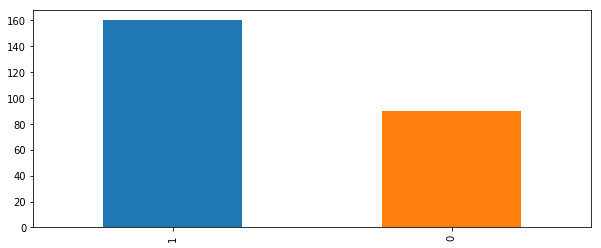

In [6]:
plot.figure(figsize=(10,4))
train_data.target.value_counts().plot(kind='bar')
plot.show()

In [7]:
train_data[[i for i in train_data.columns.tolist() if i not in ['target','id']]].describe(include='all').T

count      mean       std    min      25%     50%      75%    max
0    250.0  0.023292  0.998354 -2.319 -0.64475 -0.0155  0.67700  2.567
1    250.0 -0.026872  1.009314 -2.931 -0.73975  0.0570  0.62075  2.419
2    250.0  0.167404  1.021709 -2.477 -0.42525  0.1840  0.80500  3.392
3    250.0  0.001904  1.011751 -2.359 -0.68650 -0.0165  0.72000  2.771
4    250.0  0.001588  1.035411 -2.566 -0.65900 -0.0230  0.73500  2.901
5    250.0 -0.007304  0.955700 -2.845 -0.64375  0.0375  0.66050  2.793
6    250.0  0.032052  1.006657 -2.976 -0.67500  0.0605  0.78325  2.546
7    250.0  0.078412  0.939731 -3.444 -0.55075  0.1835  0.76625  2.846
8    250.0 -0.036920  0.963688 -2.768 -0.68950 -0.0125  0.63500  2.512
9    250.0  0.035448  1.019689 -2.361 -0.64350  0.0520  0.73300  2.959
10   250.0 -0.005032  1.085089 -3.302 -0.69350  0.0660  0.69425  3.271
11   250.0  0.110248  1.036265 -2.851 -0.52400  0.1155  0.78625  2.998
12   250.0  0.019808  1.050041 -2.681 -0.70850  0.0900  0.80525  2.729
13   250.0 -0.001108  1.024305 -2.596 -0.69200  0.0160  0.65400  2.651
14   250.0 -0.016280  0.926789 -3.275 -0.67700  0.0095  0.61100  2.913
15   250.0 -0.039644  0.955915 -3.512 -0.63450  0.0100  0.57800  2.508
16   250.0  0.017260  1.025655 -2.476 -0.68350 -0.1190  0.69900  3.286
17   250.0 -0.106856  1.012777 -3.619 -0.80150 -0.1645  0.49650  2.430
18   250.0  0.036184  0.945099 -2.428 -0.57425 -0.0095  0.68600  2.557
19   250.0 -0.043296  1.055935 -3.229 -0.75800 -0.0180  0.69800  2.868
20   250.0 -0.110832  1.003178 -3.024 -0.87050 -0.1615  0.56050  2.703
21   250.0  0.072680  1.039556 -2.775 -0.59600  0.0480  0.79700  2.691
22   250.0  0.017296  0.988482 -2.962 -0.72575  0.1350  0.63150  2.604
23   250.0 -0.030728  0.945902 -2.490 -0.65200 -0.0160  0.61925  2.362
24   250.0 -0.128252  0.997026 -3.107 -0.77950 -0.1655  0.57925  2.927
25   250.0  0.154736  0.997894 -2.943 -0.42425  0.1255  0.71950  2.976
26   250.0  0.083408  1.040371 -2.933 -0.58575  0.0365  0.79825  2.581
27   250.0  0.039552  0.922270 -2.942 -0.62500  0.0450  0.72175  2.305
28   250.0 -0.091784  1.047282 -2.957 -0.75125 -0.0260  0.67850  2.489
29   250.0  0.054636  1.041432 -2.911 -0.58250  0.0450  0.72875  2.895
..     ...       ...       ...    ...      ...     ...      ...    ...
270  250.0 -0.066236  0.985451 -2.448 -0.78675 -0.1010  0.52575  3.753
271  250.0 -0.057988  0.951879 -2.771 -0.70100 -0.1090  0.61200  2.498
272  250.0  0.091556  1.027877 -2.903 -0.54325  0.0505  0.86400  2.725
273  250.0 -0.029896  0.966882 -2.522 -0.67275 -0.0815  0.63025  2.680
274  250.0  0.115648  1.037173 -2.759 -0.62675  0.0875  0.83675  3.445
275  250.0  0.007372  1.004543 -2.915 -0.73025  0.0350  0.71800  2.846
276  250.0  0.033552  1.006219 -2.618 -0.64975  0.0865  0.79150  2.315
277  250.0  0.090524  1.037119 -3.623 -0.58950  0.1265  0.72600  2.780
278  250.0  0.001576  1.024067 -2.673 -0.72575  0.0535  0.68800  2.364
279  250.0 -0.007784  1.056086 -3.229 -0.66775  0.0635  0.66575  2.908
280  250.0  0.043184  1.012516 -2.537 -0.60500  0.0525  0.60375  2.926
281  250.0  0.082696  1.068741 -2.748 -0.63775  0.1030  0.70550  3.441
282  250.0  0.098476  0.934163 -2.850 -0.45825  0.1355  0.68825  2.319
283  250.0  0.055356  0.988100 -2.577 -0.55350  0.0390  0.75900  2.842
284  250.0  0.111708  1.043230 -2.973 -0.56675  0.0935  0.70475  3.343
285  250.0 -0.015688  1.010720 -2.709 -0.77825  0.0145  0.67375  3.266
286  250.0  0.035992  1.058982 -3.605 -0.69325 -0.0075  0.74875  3.061
287  250.0  0.026452  0.896318 -2.357 -0.59675  0.0005  0.60425  2.146
288  250.0 -0.059152  1.113760 -2.904 -0.78900 -0.1225  0.65050  2.853
289  250.0  0.077272  0.972530 -2.734 -0.67125  0.0575  0.77250  3.026
290  250.0  0.044652  1.011416 -2.804 -0.61700  0.0675  0.79725  2.865
291  250.0  0.126344  0.972567 -2.443 -0.51050  0.0910  0.80425  2.801
292  250.0  0.018436  0.954229 -2.757 -0.53575  0.0575  0.63150  2.736
293  250.0 -0.012092  0.960630 -2.466 -0.65700 -0.0210  0.65025  2.596
294  250.0 -0.065720  1.05741

In [8]:
data_type = train_data.dtypes.to_frame().reset_index()
data_type.columns  = ['col_name','col_type']
data_type[data_type.col_type==np.object].head()

Empty DataFrame
Columns: [col_name, col_type]
Index: []

In [9]:
train_data.isnull().any().sum()

0

In [10]:
col_names = [i for i in train_data.columns if i not in ['target','id']]

There are a couple of observations that we can make out of the above diagrams:

1. ALmost all independent variables are distributed within -2.5 and 2.5
2. Almost all have near normal distributions
3. Almost none have any significant outliers
4. Pearsons correlation coeff for each indedepent variable with target variable is pretty low
5. There are no categorical data
6. pearsons correlation coefficient scores are pretty less and we will take all whose scores are above 0.1 and below -0.1

#### Based on above data analysis, we are going to attempt 3 things

1. create a baseline model out of gridsearch for the data using the usual suspects of classifiers. 


2. Plot learning curve and auc/roc scores for each


3. try dimensionality reduction techniques such as PCA,LDA and t-SNE and run on baseline models created in step 1.


4. try SMOTE and run on the same model created in point 1 and compare scores



### STEP 1: Run handful of usual suspect classifiers using selected 50 features giving highest coeff scores

<br><br>

In [12]:
class CodeTimer:
    
    """
        Utility custom contextual class for calculating the time 
        taken for a certain code block to execute
    
    """
    def __init__(self, name=None):
        self.name = " '"  + name + "'" if name else ''

    def __enter__(self):
        self.start = time.clock()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (time.clock() - self.start) * 1000.0
        time_taken = datetime.timedelta(milliseconds = self.took)
        print('Code block' + self.name + ' took(HH:MM:SS): ' + str(time_taken))
        
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plot.imshow(cm, interpolation='nearest', cmap=cmap)
    plot.title(title)
    plot.colorbar()
    tick_marks = arange(len(classes))
    plot.xticks(tick_marks, classes, rotation=45)
    plot.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plot.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plot.ylabel('True label')
    plot.xlabel('Predicted label')
#     plot.tight_layout()
    plot.show()

In [13]:

def plotLearningCurve(_x_train, _y_train, learning_model_pipeline,  model_name, k_fold = 10, training_sample_sizes = linspace(0.1,1.0,10), jobsInParallel = 1):
    
    training_size, training_score, testing_score = learning_curve(estimator = learning_model_pipeline, \
                                                                X = _x_train, \
                                                                y = _y_train, \
                                                                train_sizes = training_sample_sizes, \
                                                                cv = k_fold, \
                                                                n_jobs = jobsInParallel) 


    training_mean = mean(training_score, axis = 1)
    training_std_deviation = std(training_score, axis = 1)
    testing_std_deviation = std(testing_score, axis = 1)
    testing_mean = mean(testing_score, axis = 1 )

    ## we have got the estimator in this case the perceptron running in 10 fold validation with 
    ## equal division of sizes betwwen .1 and 1. After execution, we get the number of training sizes used, 
    ## the training scores for those sizes and the test scores for those sizes. we will plot a scatter plot 
    ## to see the accuracy results and check for bias vs variance

    # training_size : essentially 10 sets of say a1, a2, a3,,...a10 sizes (this comes from train_size parameter, here we have given linespace for equal distribution betwwen 0.1 and 1 for 10 such values)
    # training_score : training score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    # testing_score : testing score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    ## the mean and std deviation for each are calculated simply to show ranges in the graph

    plot.plot(training_size, training_mean, label= "Training Data", marker= '+', color = 'blue', markersize = 8)
    plot.fill_between(training_size, training_mean+ training_std_deviation, training_mean-training_std_deviation, color='blue', alpha =0.12 )

    plot.plot(training_size, testing_mean, label= "Testing/Validation Data", marker= '*', color = 'green', markersize = 8)
    plot.fill_between(training_size, testing_mean+ training_std_deviation, testing_mean-training_std_deviation, color='green', alpha =0.14 )

    plot.title("Scoring of our training and testing data vs sample sizes for model:"+model_name)
    plot.xlabel("Number of Samples")
    plot.ylabel("Accuracy")
    plot.legend(loc= 'best')
    plot.show()
    
def plot_roc_auc_curve(false_positive_rate, true_positive_rate, model_name):
        
    plot.figure(figsize=(10,3))
    plot.plot(list(false_positive_rate), list(true_positive_rate),  label = "ROC Curve for model: "+model_name)     
    plot.plot([0, 1], [0, 1], 'k--', label = 'Random Guessing')
    plot.plot([0, 0, 1], [0,1, 1], ':', label = 'Perfect Score')
    auc_score = auc(false_positive_rate, true_positive_rate)
    plot.title('ROC Curve for model: %s with AUC %.2f'%(model_name, auc_score))
    plot.xlabel('False Positive Rate')
    plot.ylabel('True Positive Rate')
    plot.legend(loc='best')
    plot.show()
    
    
def plot_precision_recall_curve(precision, recall, model_name):
    
    plot.figure(figsize=(10,3))
    plot.plot(list(recall), list(precision),  label = "Precision/Recall Curve for model: "+model_name)     
#     plot.plot([0, 1], [0, 1], 'k--', label = 'Random Guessing') #
    plot.title('Precision Recall Curve for model: %s'%model_name)
    plot.xlabel('Recall')
    plot.ylabel('Precision')
    plot.legend(loc='best')
    plot.show()


    


In [14]:
def runGridSearchAndPredict(pipeline,model_name, x_train, y_train, x_test, y_test, param_grid, n_jobs = 1, cv = 10, score = 'accuracy'):
#     pass

    response =  {}
    training_timer       = CodeTimer('training')
    testing_timer        = CodeTimer('testing')
    learning_curve_timer = CodeTimer('learning_curve')
    predict_proba_timer  = CodeTimer('predict_proba')
    
    with training_timer:
        
        gridsearch = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = cv, n_jobs = n_jobs, scoring = score)

        search = gridsearch.fit(x_train,y_train)

        print("Grid Search Best parameters ", search.best_params_)
        print("Grid Search Best score ", search.best_score_)

    with testing_timer:
        y_prediction = gridsearch.predict(x_test)
            
    print("F1 score %s" %f1_score(y_test,y_prediction, average ='weighted'))
    print("Classification report  \n %s" %(classification_report(y_test, y_prediction)))
    
    with learning_curve_timer:
        plotLearningCurve(x_train, y_train, search.best_estimator_, model_name, k_fold=cv)
#         _matrix = confusion_matrix(y_true = _y_test ,y_pred = y_prediction, labels = list(range(_y_test.shape[1])))
        _matrix = confusion_matrix(y_true = y_test ,y_pred = y_prediction, labels = list(set(y_test)))
        classes = list(set(y_test))
        plot_confusion_matrix(_matrix, classes, title = "Confusion matrix for model:"+model_name)
        
    with predict_proba_timer:

        if hasattr(gridsearch.best_estimator_, 'predict_proba'):
            
            print('inside decision function')
            y_probability = gridsearch.predict_proba(x_test)
            number_of_classes = len(np.unique(y_train))
            false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_probability[:, 1])
            response['roc_auc_score'] = roc_auc_score(y_test, y_probability[:,1])
            response['roc_curve'] = (false_positive_rate, true_positive_rate)  
            response['roc_curve_false_positive_rate'] = false_positive_rate
            response['roc_curve_true_positive_rate'] = true_positive_rate
            precision, recall, _ = precision_recall_curve(y_test, y_probability[:,1])
            plot_roc_auc_curve(false_positive_rate, true_positive_rate, model_name)
            plot_precision_recall_curve(precision, recall, model_name)
            
        else: ## eg SVM, Perceptron doesnt have predict_proba method
            
            response['roc_auc_score'] = 0
            response['roc_curve'] = 0
            response['roc_curve_false_positive_rate'] = 0
            response['roc_curve_true_positive_rate'] = 0
    
    response['learning_curve_time'] = learning_curve_timer.took
    response['testing_time'] = testing_timer.took
    response['_y_prediction'] = y_prediction
#     response['accuracy_score'] = accuracy_score(y_test,y_prediction)
    response['training_time'] = training_timer.took
    response['f1_score']  = f1_score(y_test, y_prediction, average ='weighted')
    response['f1_score_micro']  = f1_score(y_test, y_prediction, average ='micro')
    response['f1_score_macro']  = f1_score(y_test, y_prediction, average ='macro')
    response['best_estimator'] = search.best_estimator_
    response['confusion_matrix'] = _matrix
    
    return response


def plotROCCurveAcrossModels(positive_rates_sequence, model_name):
    
    plot.figure(figsize=(10,5))
    for plot_values, label_name in zip(positive_rates_sequence, model_name):
        
        plot.plot(list(plot_values[0]), list(plot_values[1]),  label = "ROC Curve for model: "+label_name)
        
    plot.plot([0, 1], [0, 1], 'k--', label = 'Random Guessing') #
    plot.title('ROC Curve across models')
    plot.xlabel('False Positive Rate')
    plot.ylabel('True Positive Rate')
    plot.legend(loc='best')
    plot.show()

In [38]:

def execute( _x_train,
             _y_train,
             _x_test,
             _y_test, 
            classifiers, 
            classifier_names, 
            classifier_param_grid,
            cv  = 10 , 
            score = 'accuracy',
            scaler = StandardScaler()
           ):
    
    '''
    This method will run your data sets against the model specified 
    Models will be fed through a pipeline where the first step would be to
    execute a scaling operation.
    
    Method will also call additional lower level methods in order to plot
    precision curve, roc curve, learning curve and will also prepare a confusion matrix
    
    :returns: dict containing execution metrics such as time taken, accuracy scores
    :returntype: dict
    
    '''

    timer = CodeTimer(name='overalltime')
    model_metrics = {}

    with timer:
        for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):

            pipeline_steps = [('scaler', scaler),
                              ('feature_selection', SelectFromModel(LogisticRegression(random_state = 1,penalty="l2"))),
                              (model_name, model)] if scaler is not None else \
                            [('feature_selection', SelectFromModel(LogisticRegression(random_state = 1,penalty="l2"))),
                             (model_name, model)]
            pipeline = Pipeline(pipeline_steps)

            result = runGridSearchAndPredict(pipeline, 
                                             model_name,
                                             _x_train,
                                             _y_train,
                                             _x_test,
                                             _y_test, 
                                             model_param_grid ,
                                             cv = cv,
                                             score = score)

            _y_prediction = result['_y_prediction']

            model_metrics[model_name] = {}
            model_metrics[model_name]['confusion_matrix'] = result.get('confusion_matrix')
            model_metrics[model_name]['training_time'] = result.get('training_time')
            model_metrics[model_name]['testing_time'] = result.get('testing_time')
            model_metrics[model_name]['learning_curve_time'] = result.get('learning_curve_time')
            model_metrics[model_name]['f1_score'] = result.get('f1_score')
            model_metrics[model_name]['f1_score_macro'] = result.get('f1_score_macro')
            model_metrics[model_name]['f1_score_micro'] = result.get('f1_score_micro')
            model_metrics[model_name]['roc_auc_score'] = result.get('roc_auc_score')
            model_metrics[model_name]['roc_curve_true_positive_rate'] = result.get('roc_curve_true_positive_rate')
            model_metrics[model_name]['roc_curve_false_positive_rate'] = result.get('roc_curve_false_positive_rate')

            model_metrics[model_name]['best_estimator'] = result.get('best_estimator')


    print(timer.took)
    
    return model_metrics


In [44]:

classifiers = [
#     Perceptron(random_state = 1),
    LogisticRegression(random_state = 1),
    LogisticRegression(random_state = 1, solver='liblinear'),
    LogisticRegression(random_state = 1, solver='newton-cg'),
    LogisticRegression(random_state = 1, solver='sag'),
    DecisionTreeClassifier(),
    RandomForestClassifier(random_state = 1),
    KNeighborsClassifier(metric = 'minkowski'),
    RidgeClassifier(random_state = 123), 
    SVC(kernel="linear"),
    SVC(),
    ExtraTreeClassifier(random_state = 123),
    GaussianProcessClassifier(random_state = 123),
    BernoulliNB(),
    BaggingClassifier(base_estimator = LogisticRegression(random_state = 1)),
    BaggingClassifier(base_estimator = BernoulliNB()),
    GradientBoostingClassifier(random_state= 123),
    LGBMClassifier(objective = 'binary'),
    XGBClassifier(objective = 'binary:logistic')
]


classifier_names = [
#             'perceptron',
            'logisticregression',
            'logisticregression_liblinear_l2',
            'logisticregression_newton_cg',
            'logisticregression_sag',
            'decisiontreeclassifier',
            'randomforestclassifier',
            'kneighborsclassifier',
            'ridge',
            'linear_svc',
            'gamma_svc',
            'extra_trees',
            'gaussian_process',
            'bernoulli',
            'bagging_logistic',
            'bagging_bernoulli',
            'gradient_boosting_classifier',
            'lgbm_classifier',
            'xgb'
]

classifier_param_grid = [
            
#             {'perceptron__max_iter': [5,10,30], 'perceptron__eta0': [.1]},
            {
             'logisticregression__C':[1.2,0.02,2.2,4, 0.01, 0.05], 
             'logisticregression__penalty':['l1','l2'],
             'logisticregression__solver':['saga','liblinear']
            },
            {
             'logisticregression_liblinear_l2__C':[1.2,0.02,2.2,4, 0.01, 0.05], 
             'logisticregression_liblinear_l2__penalty':['l2'],
             'logisticregression_liblinear_l2__dual':[True]
            },
            {
             'logisticregression_newton_cg__C':[1.2,0.02,2.2,4, 0.01, 0.05], 
             'logisticregression_newton_cg__penalty':['l2'],
            },
            {
             'logisticregression_sag__C':[1.2,0.02,2.2,4, 0.01, 0.05], 
             'logisticregression_sag__penalty':['l2'],
            },
    
            {'decisiontreeclassifier__max_depth':[6,8,10],
             'decisiontreeclassifier__criterion':['gini','entropy'],
             'decisiontreeclassifier__max_features':['auto','sqrt','log2'],
            },
            {'randomforestclassifier__n_estimators':[6,8,12],'randomforestclassifier__criterion': ['gini','entropy']} ,
            {'kneighborsclassifier__n_neighbors':[4,6,10]},
            {'ridge__alpha':[1,1.2,0.9],'ridge__max_iter':[100,300,500]},
            {'linear_svc__C':[0.025]},
            {'gamma_svc__gamma':[2,4],'gamma_svc__C':[1,5]},
            {'extra_trees__max_depth':[6,8,12],'extra_trees__criterion': ['gini','entropy']} ,
            {'gaussian_process__max_iter_predict':[200,400]} ,
            {'bernoulli__alpha':[0.2,0.6,1.2]} ,
            {'bagging_logistic__base_estimator__C':[1.2,0.02,2.2,4], 
             'bagging_logistic__base_estimator__penalty':['l1','l2'],
             'bagging_logistic__n_estimators': [5,8,10]
            },
            {'bagging_bernoulli__base_estimator__alpha':[1.2,0.02,2.2,4], 
             'bagging_bernoulli__n_estimators': [5,8,10]
            },
            {
                'gradient_boosting_classifier__loss':['deviance','exponential'],
                'gradient_boosting_classifier__learning_rate':[0.5,1.2],
                'gradient_boosting_classifier__n_estimators':[100,500,1000],
                'gradient_boosting_classifier__criterion':['friedman_mse','mse','mae'],
                'gradient_boosting_classifier__max_depth':[6,8,16,20],
            },
            {
                 'lgbm_classifier__num_leaves':[25,], \
#                  'lgbm_classifier__min_data_in_leaf':[20],\
                 'lgbm_classifier__max_depth':[20,], \
                 'lgbm_classifier__learning_rate' : [0.01,],\
                 'lgbm_classifier__min_child_samples' :[2,], \
                 'lgbm_classifier__n_estimators' : [5000,], \
                 'lgbm_classifier__num_boost_round' : [100], \
                 'lgbm_classifier__feature_fraction' : [0.9,], \
                 'lgbm_classifier__bagging_freq' : [1,], \
                 'lgbm_classifier__bagging_seed' : [123], \
            },
             {
                'xgb__max_depth':[6,8,10],
                 'xgb__learning_rate':[0.1,0.5,1,2],
                 'xgb__n_estimators':[100,400,1000],             
                 'xgb__booster':['gbtree','dart'],
                 'xgb__subsample':[0.5, 0.2,0.8]
            },
    
]


In [49]:
from scipy import stats
def calculateCorrelationCoefficientsAndpValues(x_data, y_data, xlabel):
    
    pearson_coef, p_value = stats.pearsonr(x_data, y_data)
    print("The Pearson Correlation Coefficient for %s is %s with a P-value of P = %s" %(xlabel,pearson_coef, p_value))
    
    return (pearson_coef,p_value)

In [50]:
pearson_coeff = []
p_value = []
col_name = []

for col in [i for i in train_data.columns.tolist() if i not in ['id','target']]:
    
    x,y = calculateCorrelationCoefficientsAndpValues(train_data[col], train_data['target'], col)
    pearson_coeff.append(x)
    p_value.append(y)
    col_name.append(col)
    
pearson_table = panda.DataFrame({'column_name':col_name , 'pearson_coeff':pearson_coeff, 'p_value': p_value})
pearson_table.head()

The Pearson Correlation Coefficient for 0 is 0.10896613295780612 with a P-value of P = 0.0855425108978631
The Pearson Correlation Coefficient for 1 is -0.07331927684495224 with a P-value of P = 0.2480801859987947
The Pearson Correlation Coefficient for 2 is -0.015140943820013032 with a P-value of P = 0.8117157095966047
The Pearson Correlation Coefficient for 3 is 0.011549011379043529 with a P-value of P = 0.8558206568804985
The Pearson Correlation Coefficient for 4 is -0.11472596336421398 with a P-value of P = 0.07016102972091894
The Pearson Correlation Coefficient for 5 is -0.05032883942137733 with a P-value of P = 0.42819565779211044
The Pearson Correlation Coefficient for 6 is -0.05706281139477776 with a P-value of P = 0.36894411376906777
The Pearson Correlation Coefficient for 7 is 0.0042391278386217585 with a P-value of P = 0.9468277872565647
The Pearson Correlation Coefficient for 8 is -0.04844250987759829 with a P-value of P = 0.44573026468867594
The Pearson Correlation Coeffici

column_name  pearson_coeff   p_value
0           0       0.108966  0.085543
1           1      -0.073319  0.248080
2           2      -0.015141  0.811716
3           3       0.011549  0.855821
4           4      -0.114726  0.070161

In [51]:
reqd_columns = pearson_table[(pearson_table.pearson_coeff>0.1) | (pearson_table.pearson_coeff<-0.1)].sort_values(by=['pearson_coeff'], ascending=False).column_name.values.tolist()
reqd_columns[:5], len(reqd_columns)

(['33', '65', '24', '183', '199'], 50)

In [52]:
# x = train_data[[i for i in train_data.columns.tolist() if i not in ['target','id']]]
x = train_data[reqd_columns[:51]]
# # x = train_data[anova_columns]
y = train_data['target']

x_train,x_test,y_train,y_test = train_test_split(x,y , stratify = y, test_size = 0.3, random_state = 123)

In [57]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from imblearn.combine import SMOTETomek

In [58]:

tl = TomekLinks(return_indices=True, ratio='majority')
_x_train_tomek, _y_train_tomek, id_tl = tl.fit_sample(x_train, y_train)

smt = SMOTETomek(ratio='auto')
_x_train_smt, _y_train_smt = smt.fit_sample(x_train, y_train)

smote = SMOTE(ratio='minority')
x_train_smote, y_train_smote = smote.fit_sample(x_train,y_train)





In [56]:
cv = StratifiedKFold(n_splits = 5, shuffle= True, random_state =123)
score= 'roc_auc'

Grid Search Best parameters  {'logisticregression__C': 2.2, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}
Grid Search Best score  0.8937728937728938
Code block 'training' took(HH:MM:SS): 0:00:00.816302
Code block 'testing' took(HH:MM:SS): 0:00:00.000937
F1 score 0.6845714285714286
Classification report  
               precision    recall  f1-score   support

           0       0.53      0.85      0.66        27
           1       0.88      0.58      0.70        48

   micro avg       0.68      0.68      0.68        75
   macro avg       0.70      0.72      0.68        75
weighted avg       0.75      0.68      0.68        75



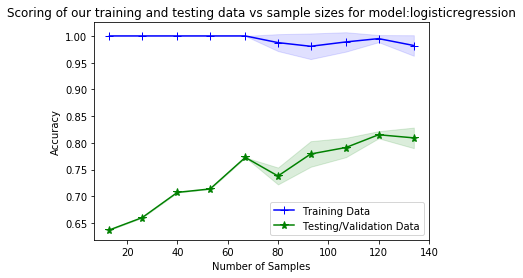

Confusion matrix, without normalization
[[23  4]
 [20 28]]


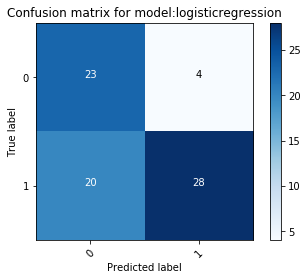

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.624127
inside decision function


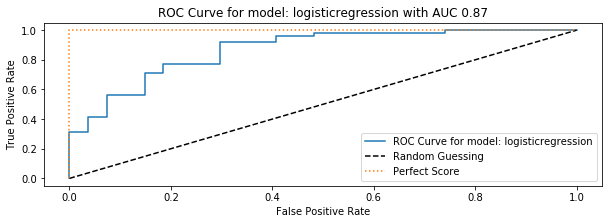

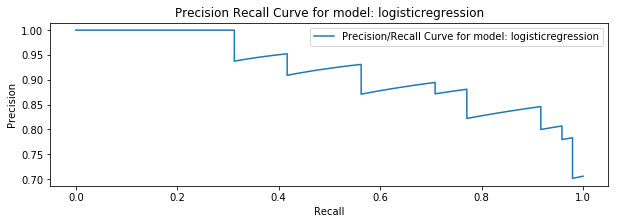

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.225999
Grid Search Best parameters  {'logisticregression_liblinear_l2__C': 2.2, 'logisticregression_liblinear_l2__dual': True, 'logisticregression_liblinear_l2__penalty': 'l2'}
Grid Search Best score  0.8906931362288505
Code block 'training' took(HH:MM:SS): 0:00:00.187928
Code block 'testing' took(HH:MM:SS): 0:00:00.001070
F1 score 0.6845714285714286
Classification report  
               precision    recall  f1-score   support

           0       0.53      0.85      0.66        27
           1       0.88      0.58      0.70        48

   micro avg       0.68      0.68      0.68        75
   macro avg       0.70      0.72      0.68        75
weighted avg       0.75      0.68      0.68        75



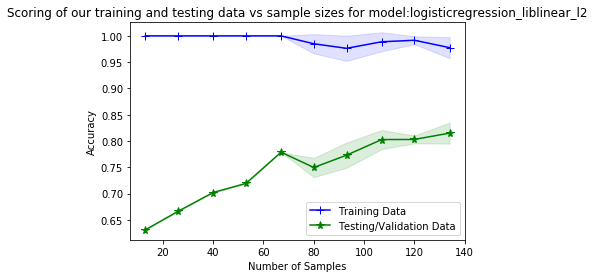

Confusion matrix, without normalization
[[23  4]
 [20 28]]


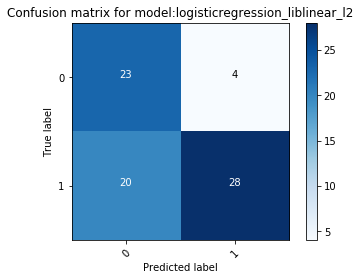

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.440701
inside decision function


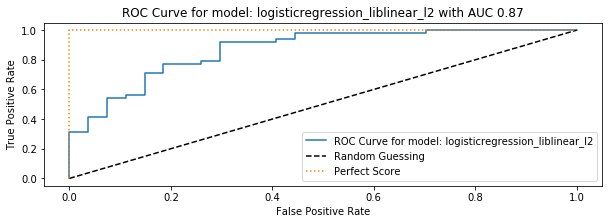

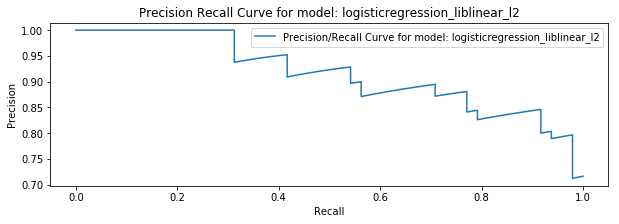

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.239581
Grid Search Best parameters  {'logisticregression_newton_cg__C': 2.2, 'logisticregression_newton_cg__penalty': 'l2'}
Grid Search Best score  0.8914344583987441
Code block 'training' took(HH:MM:SS): 0:00:00.270506
Code block 'testing' took(HH:MM:SS): 0:00:00.001068
F1 score 0.6845714285714286
Classification report  
               precision    recall  f1-score   support

           0       0.53      0.85      0.66        27
           1       0.88      0.58      0.70        48

   micro avg       0.68      0.68      0.68        75
   macro avg       0.70      0.72      0.68        75
weighted avg       0.75      0.68      0.68        75



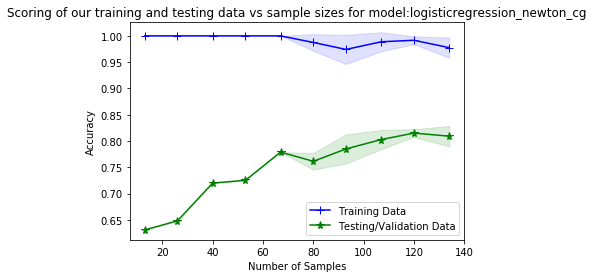

Confusion matrix, without normalization
[[23  4]
 [20 28]]


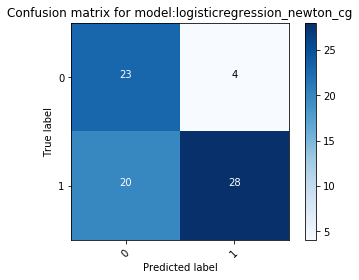

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.529765
inside decision function


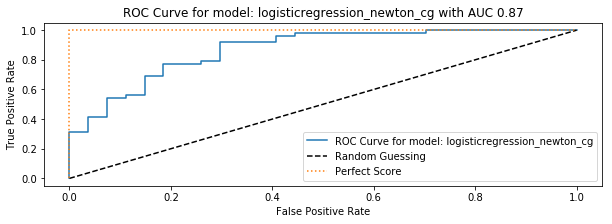

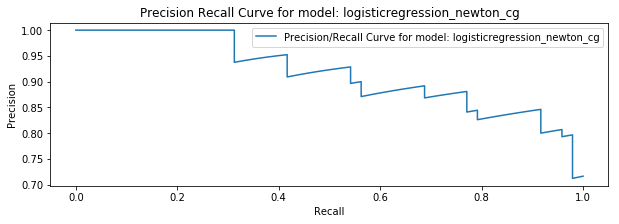

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.250690
Grid Search Best parameters  {'logisticregression_sag__C': 2.2, 'logisticregression_sag__penalty': 'l2'}
Grid Search Best score  0.8914344583987441
Code block 'training' took(HH:MM:SS): 0:00:00.217102
Code block 'testing' took(HH:MM:SS): 0:00:00.000811
F1 score 0.6845714285714286
Classification report  
               precision    recall  f1-score   support

           0       0.53      0.85      0.66        27
           1       0.88      0.58      0.70        48

   micro avg       0.68      0.68      0.68        75
   macro avg       0.70      0.72      0.68        75
weighted avg       0.75      0.68      0.68        75



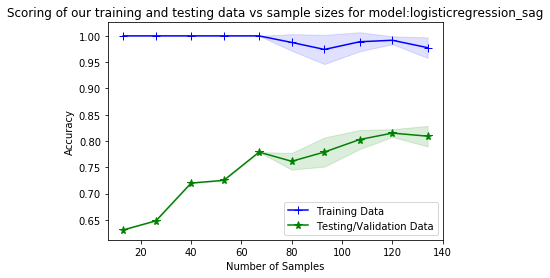

Confusion matrix, without normalization
[[23  4]
 [20 28]]


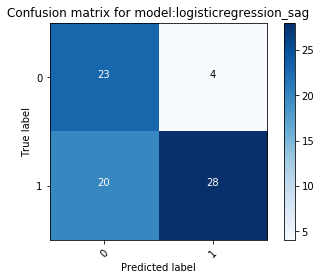

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.434204
inside decision function


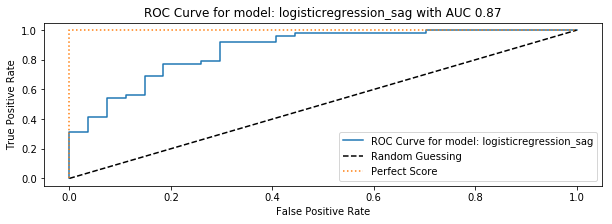

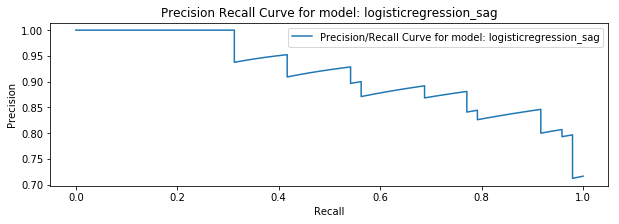

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.239036
Grid Search Best parameters  {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 8, 'decisiontreeclassifier__max_features': 'log2'}
Grid Search Best score  0.7007647610326183
Code block 'training' took(HH:MM:SS): 0:00:00.472889
Code block 'testing' took(HH:MM:SS): 0:00:00.001008
F1 score 0.5426244343891403
Classification report  
               precision    recall  f1-score   support

           0       0.39      0.56      0.46        27
           1       0.68      0.52      0.59        48

   micro avg       0.53      0.53      0.53        75
   macro avg       0.54      0.54      0.52        75
weighted avg       0.57      0.53      0.54        75



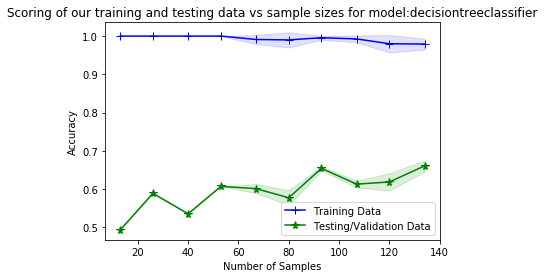

Confusion matrix, without normalization
[[15 12]
 [23 25]]


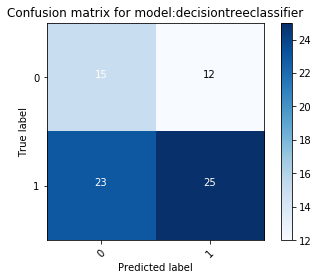

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.399871
inside decision function


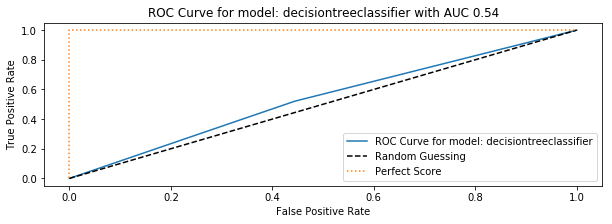

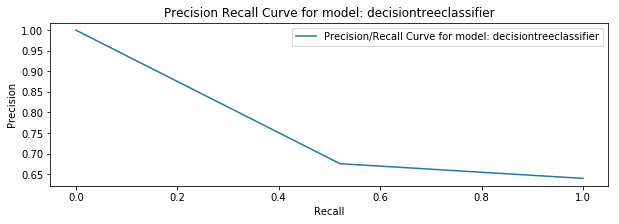

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.241019
Grid Search Best parameters  {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__n_estimators': 12}
Grid Search Best score  0.7566419195883481
Code block 'training' took(HH:MM:SS): 0:00:00.383850
Code block 'testing' took(HH:MM:SS): 0:00:00.002623
F1 score 0.6328888888888888
Classification report  
               precision    recall  f1-score   support

           0       0.48      0.59      0.53        27
           1       0.74      0.65      0.69        48

   micro avg       0.63      0.63      0.63        75
   macro avg       0.61      0.62      0.61        75
weighted avg       0.65      0.63      0.63        75



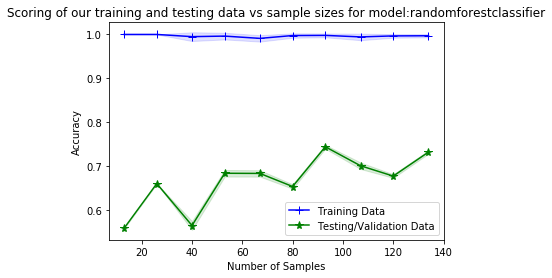

Confusion matrix, without normalization
[[16 11]
 [17 31]]


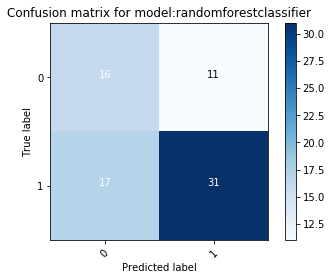

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.896277
inside decision function


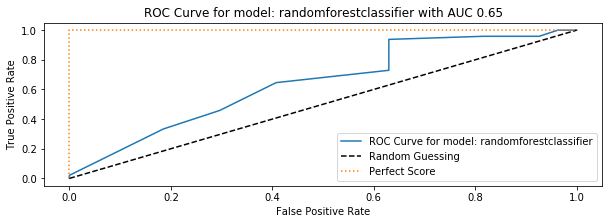

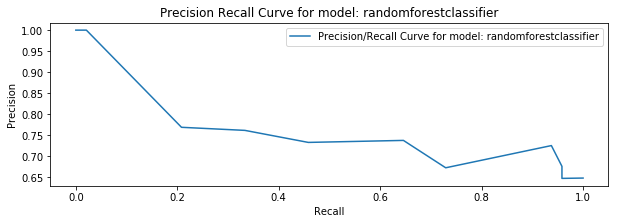

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.235667
Grid Search Best parameters  {'kneighborsclassifier__n_neighbors': 10}
Grid Search Best score  0.8157187554508983
Code block 'training' took(HH:MM:SS): 0:00:00.101875
Code block 'testing' took(HH:MM:SS): 0:00:00.001675
F1 score 0.7384164222873901
Classification report  
               precision    recall  f1-score   support

           0       0.60      0.78      0.68        27
           1       0.85      0.71      0.77        48

   micro avg       0.73      0.73      0.73        75
   macro avg       0.72      0.74      0.73        75
weighted avg       0.76      0.73      0.74        75



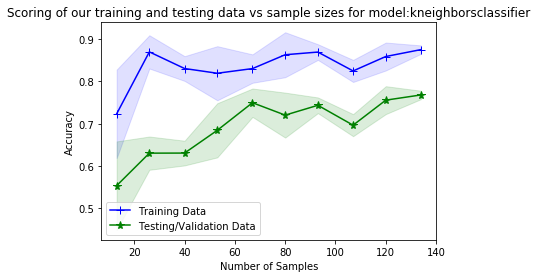

Confusion matrix, without normalization
[[21  6]
 [14 34]]


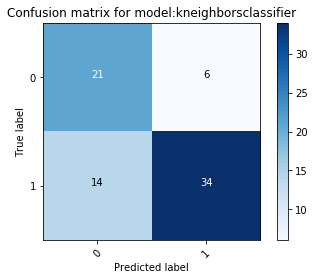

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.444901
inside decision function


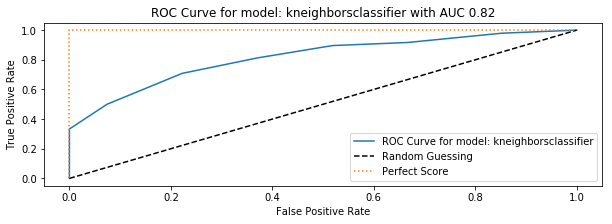

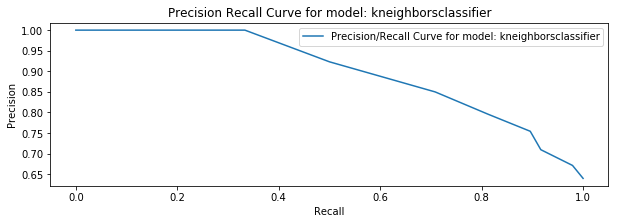

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.260545
Grid Search Best parameters  {'ridge__alpha': 1, 'ridge__max_iter': 100}
Grid Search Best score  0.8778617216117216
Code block 'training' took(HH:MM:SS): 0:00:00.308894
Code block 'testing' took(HH:MM:SS): 0:00:00.001558
F1 score 0.6856241032998566
Classification report  
               precision    recall  f1-score   support

           0       0.54      0.81      0.65        27
           1       0.85      0.60      0.71        48

   micro avg       0.68      0.68      0.68        75
   macro avg       0.69      0.71      0.68        75
weighted avg       0.74      0.68      0.69        75



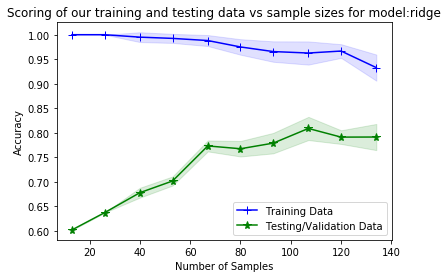

Confusion matrix, without normalization
[[22  5]
 [19 29]]


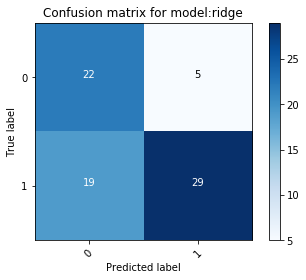

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.428482
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000022
Grid Search Best parameters  {'linear_svc__C': 0.025}
Grid Search Best score  0.8742695796267225
Code block 'training' took(HH:MM:SS): 0:00:00.041435
Code block 'testing' took(HH:MM:SS): 0:00:00.001121
F1 score 0.7377777777777778
Classification report  
               precision    recall  f1-score   support

           0       0.61      0.74      0.67        27
           1       0.83      0.73      0.78        48

   micro avg       0.73      0.73      0.73        75
   macro avg       0.72      0.73      0.72        75
weighted avg       0.75      0.73      0.74        75



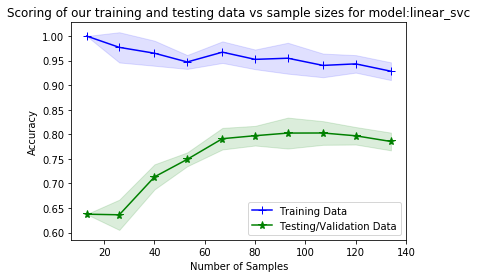

Confusion matrix, without normalization
[[20  7]
 [13 35]]


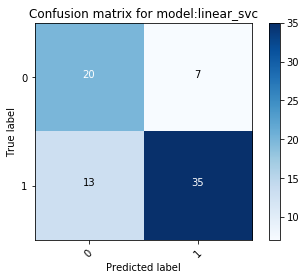

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.426610
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000025
Grid Search Best parameters  {'gamma_svc__C': 5, 'gamma_svc__gamma': 2}
Grid Search Best score  0.6249754709576139
Code block 'training' took(HH:MM:SS): 0:00:00.142827
Code block 'testing' took(HH:MM:SS): 0:00:00.001578
F1 score 0.49951219512195116
Classification report  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.64      1.00      0.78        48

   micro avg       0.64      0.64      0.64        75
   macro avg       0.32      0.50      0.39        75
weighted avg       0.41      0.64      0.50        75



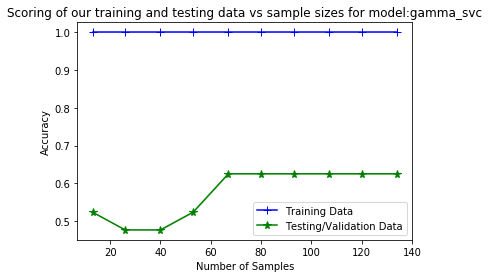

Confusion matrix, without normalization
[[ 0 27]
 [ 0 48]]


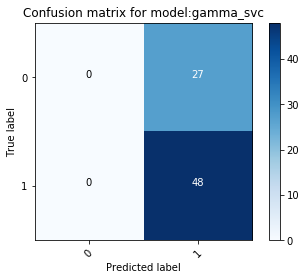

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.425176
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000022
Grid Search Best parameters  {'extra_trees__criterion': 'entropy', 'extra_trees__max_depth': 8}
Grid Search Best score  0.5971159297052154
Code block 'training' took(HH:MM:SS): 0:00:00.159687
Code block 'testing' took(HH:MM:SS): 0:00:00.001011
F1 score 0.5644821731748727
Classification report  
               precision    recall  f1-score   support

           0       0.40      0.44      0.42        27
           1       0.67      0.62      0.65        48

   micro avg       0.56      0.56      0.56        75
   macro avg       0.53      0.53      0.53        75
weighted avg       0.57      0.56      0.56        75



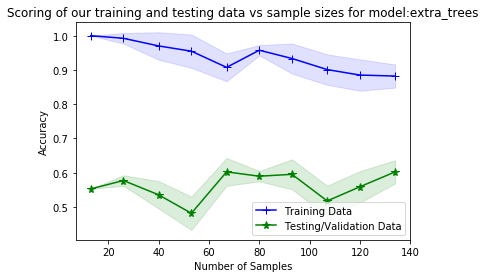

Confusion matrix, without normalization
[[12 15]
 [18 30]]


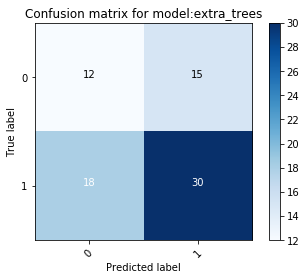

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.364020
inside decision function


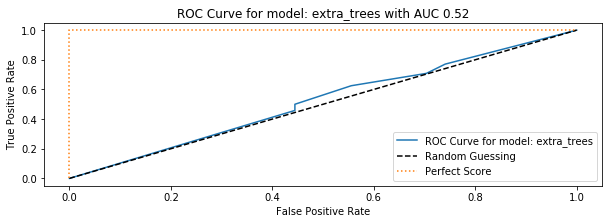

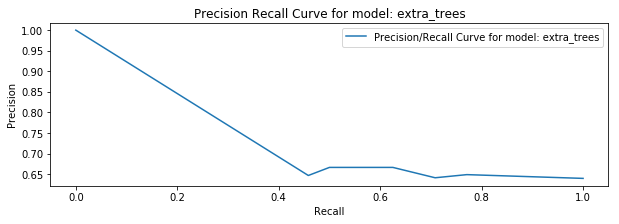

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.230949
Grid Search Best parameters  {'gaussian_process__max_iter_predict': 200}
Grid Search Best score  0.7020211930926216
Code block 'training' took(HH:MM:SS): 0:00:00.175918
Code block 'testing' took(HH:MM:SS): 0:00:00.002606
F1 score 0.7377777777777778
Classification report  
               precision    recall  f1-score   support

           0       0.61      0.74      0.67        27
           1       0.83      0.73      0.78        48

   micro avg       0.73      0.73      0.73        75
   macro avg       0.72      0.73      0.72        75
weighted avg       0.75      0.73      0.74        75



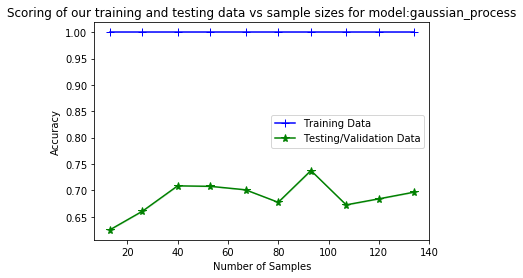

Confusion matrix, without normalization
[[20  7]
 [13 35]]


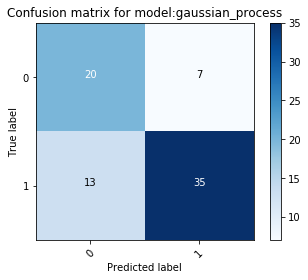

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.667138
inside decision function


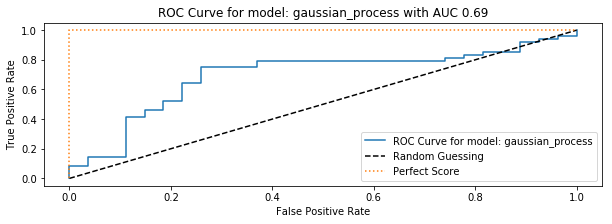

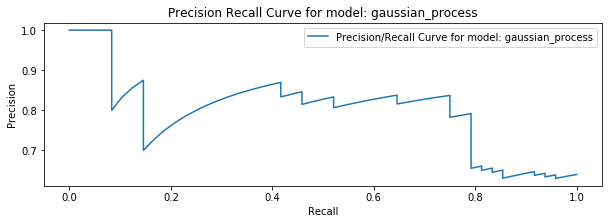

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.249735
Grid Search Best parameters  {'bernoulli__alpha': 0.2}
Grid Search Best score  0.8340419501133787
Code block 'training' took(HH:MM:SS): 0:00:00.088256
Code block 'testing' took(HH:MM:SS): 0:00:00.001481
F1 score 0.712258064516129
Classification report  
               precision    recall  f1-score   support

           0       0.57      0.74      0.65        27
           1       0.82      0.69      0.75        48

   micro avg       0.71      0.71      0.71        75
   macro avg       0.70      0.71      0.70        75
weighted avg       0.73      0.71      0.71        75



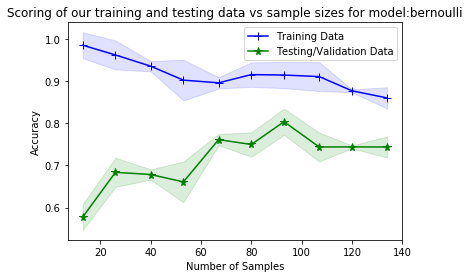

Confusion matrix, without normalization
[[20  7]
 [15 33]]


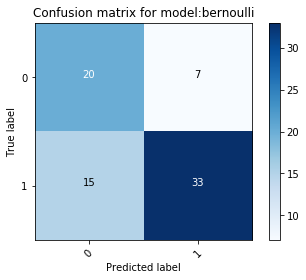

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.512043
inside decision function


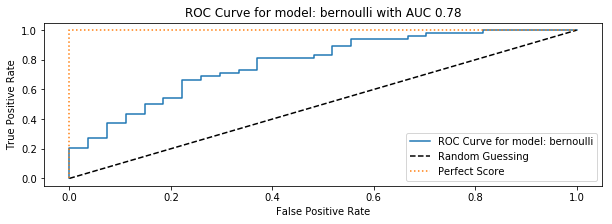

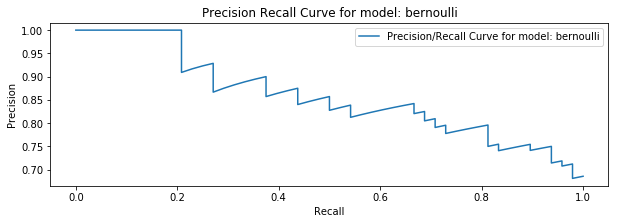

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.282795
Grid Search Best parameters  {'bagging_logistic__base_estimator__C': 4, 'bagging_logistic__base_estimator__penalty': 'l1', 'bagging_logistic__n_estimators': 5}
Grid Search Best score  0.9026306035234607
Code block 'training' took(HH:MM:SS): 0:00:01.732719
Code block 'testing' took(HH:MM:SS): 0:00:00.002925
F1 score 0.6990685128573998
Classification report  
               precision    recall  f1-score   support

           0       0.55      0.81      0.66        27
           1       0.86      0.62      0.72        48

   micro avg       0.69      0.69      0.69        75
   macro avg       0.70      0.72      0.69        75
weighted avg       0.75      0.69      0.70        75



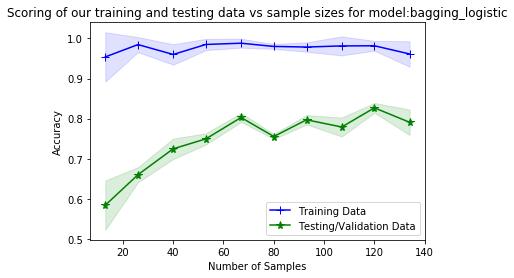

Confusion matrix, without normalization
[[22  5]
 [18 30]]


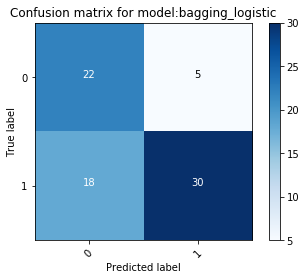

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.747528
inside decision function


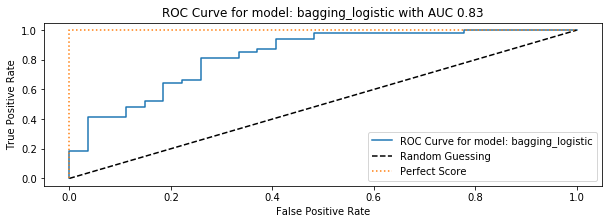

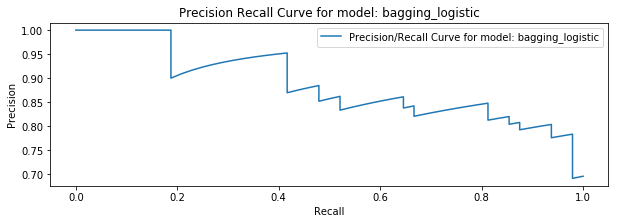

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.231062
Grid Search Best parameters  {'bagging_bernoulli__base_estimator__alpha': 2.2, 'bagging_bernoulli__n_estimators': 8}
Grid Search Best score  0.8452762515262515
Code block 'training' took(HH:MM:SS): 0:00:01.021014
Code block 'testing' took(HH:MM:SS): 0:00:00.003780
F1 score 0.6988690366550009
Classification report  
               precision    recall  f1-score   support

           0       0.56      0.70      0.62        27
           1       0.80      0.69      0.74        48

   micro avg       0.69      0.69      0.69        75
   macro avg       0.68      0.70      0.68        75
weighted avg       0.72      0.69      0.70        75



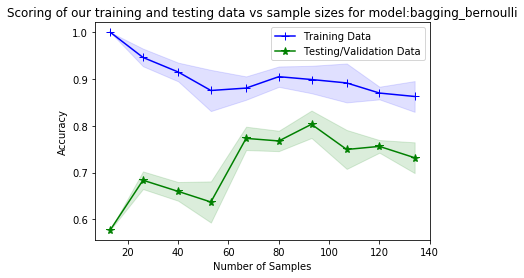

Confusion matrix, without normalization
[[19  8]
 [15 33]]


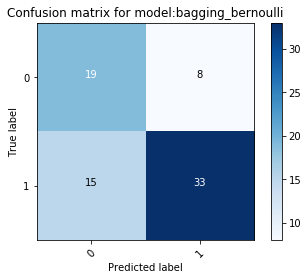

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.832989
inside decision function


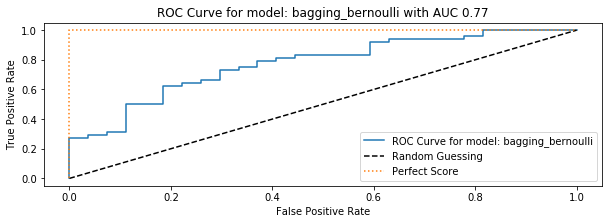

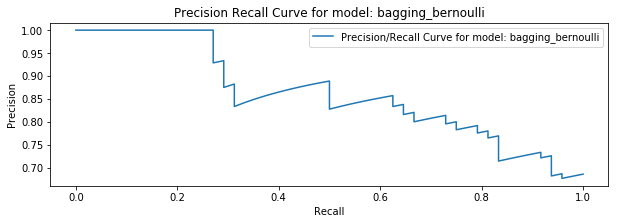

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.279508
Grid Search Best parameters  {'gradient_boosting_classifier__criterion': 'mse', 'gradient_boosting_classifier__learning_rate': 1.2, 'gradient_boosting_classifier__loss': 'deviance', 'gradient_boosting_classifier__max_depth': 6, 'gradient_boosting_classifier__n_estimators': 100}
Grid Search Best score  0.7361928745857317
Code block 'training' took(HH:MM:SS): 0:06:26.865898
Code block 'testing' took(HH:MM:SS): 0:00:00.001036
F1 score 0.7250543378154356
Classification report  
               precision    recall  f1-score   support

           0       0.59      0.74      0.66        27
           1       0.83      0.71      0.76        48

   micro avg       0.72      0.72      0.72        75
   macro avg       0.71      0.72      0.71        75
weighted avg       0.74      0.72      0.73        75



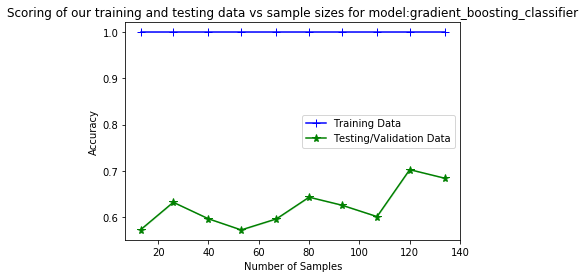

Confusion matrix, without normalization
[[20  7]
 [14 34]]


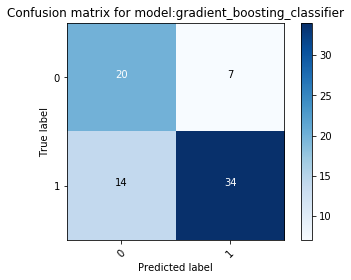

Code block 'learning_curve' took(HH:MM:SS): 0:00:01.255628
inside decision function


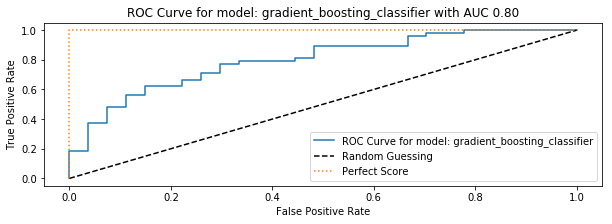

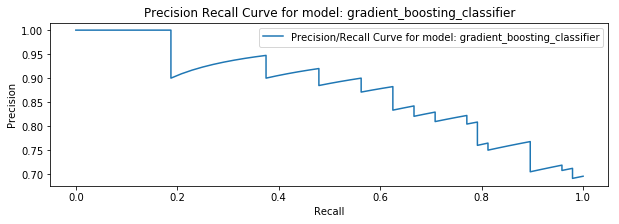

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.223699
Grid Search Best parameters  {'lgbm_classifier__bagging_freq': 1, 'lgbm_classifier__bagging_seed': 123, 'lgbm_classifier__feature_fraction': 0.9, 'lgbm_classifier__learning_rate': 0.01, 'lgbm_classifier__max_depth': 20, 'lgbm_classifier__min_child_samples': 2, 'lgbm_classifier__n_estimators': 5000, 'lgbm_classifier__num_boost_round': 100, 'lgbm_classifier__num_leaves': 25}
Grid Search Best score  0.7170384179312751
Code block 'training' took(HH:MM:SS): 0:00:00.482855
Code block 'testing' took(HH:MM:SS): 0:00:00.002815
F1 score 0.6579106890280865
Classification report  
               precision    recall  f1-score   support

           0       0.55      0.44      0.49        27
           1       0.72      0.79      0.75        48

   micro avg       0.67      0.67      0.67        75
   macro avg       0.63      0.62      0.62        75
weighted avg       0.66      0.67      0.66        75



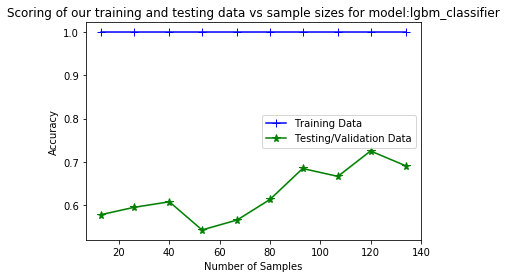

Confusion matrix, without normalization
[[12 15]
 [10 38]]


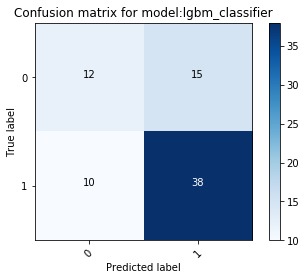

Code block 'learning_curve' took(HH:MM:SS): 0:00:02.752822
inside decision function


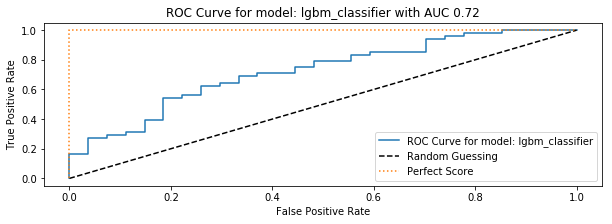

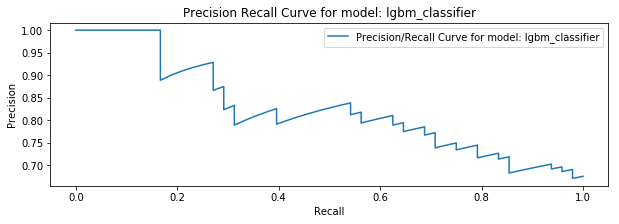

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.261515
Grid Search Best parameters  {'xgb__booster': 'gbtree', 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 400, 'xgb__subsample': 0.2}
Grid Search Best score  0.855126024768882
Code block 'training' took(HH:MM:SS): 0:03:18.456569
Code block 'testing' took(HH:MM:SS): 0:00:00.001948
F1 score 0.7241720990873532
Classification report  
               precision    recall  f1-score   support

           0       0.59      0.70      0.64        27
           1       0.81      0.73      0.77        48

   micro avg       0.72      0.72      0.72        75
   macro avg       0.70      0.72      0.71        75
weighted avg       0.73      0.72      0.72        75



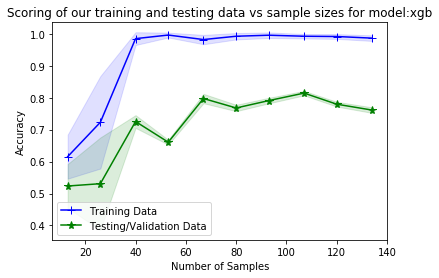

Confusion matrix, without normalization
[[19  8]
 [13 35]]


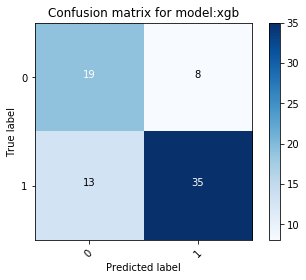

Code block 'learning_curve' took(HH:MM:SS): 0:00:02.242646
inside decision function


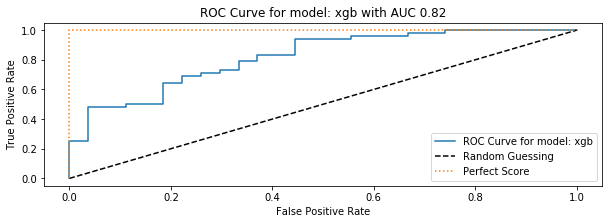

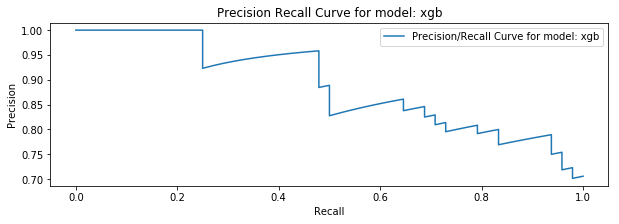

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.211149
Code block 'overalltime' took(HH:MM:SS): 0:10:10.156701
610156.7012702125


In [59]:
response = execute(
        _x_train_tomek,
        _y_train_tomek,
        x_test,
        y_test,
        classifiers,
        classifier_names,
        classifier_param_grid,
        cv=cv,
        score=score,
        scaler=StandardScaler())

In [60]:
results = panda.DataFrame(response).transpose()
results.head()
results[['f1_score',
         'f1_score_macro',
         'f1_score_micro',
         'learning_curve_time',
         'roc_auc_score',
         'testing_time',
         'training_time',
        ]]\
.sort_values(by=['roc_auc_score',],ascending=False)

f1_score f1_score_macro f1_score_micro  \
logisticregression_liblinear_l2  0.684571       0.678571           0.68   
logisticregression_newton_cg     0.684571       0.678571           0.68   
logisticregression_sag           0.684571       0.678571           0.68   
logisticregression               0.684571       0.678571           0.68   
bagging_logistic                 0.699069       0.689804       0.693333   
xgb                              0.724172       0.706649           0.72   
kneighborsclassifier             0.738416       0.725073       0.733333   
gradient_boosting_classifier     0.725054       0.709891           0.72   
bernoulli                        0.712258       0.697581       0.706667   
bagging_bernoulli                0.698869       0.682262       0.693333   
lgbm_classifier                  0.657911       0.621136       0.666667   
gaussian_process                 0.737778       0.722222       0.733333   
randomforestclassifier           0.632889       0.611111       0.626667   
decisiontreeclassifier           0.542624       0.524887       0.533333   
extra_trees                      0.564482       0.533107           0.56   
ridge                            0.685624       0.677188           0.68   
linear_svc                       0.737778       0.722222       0.733333   
gamma_svc                        0.499512       0.390244           0.64   

                                learning_curve_time roc_auc_score  \
logisticregression_liblinear_l2             440.701      0.867284   
logisticregression_newton_cg                529.765      0.867284   
logisticregression_sag                      434.204      0.867284   
logisticregression                          624.127      0.866512   
bagging_logistic                            747.528      0.829475   
xgb                                         2242.65      0.817901   
kneighborsclassifier                        444.901      0.815972   
gradient_boosting_classifier                1255.63      0.799383   
bernoulli                                   512.043      0.777778   
bagging_bernoulli                           832.989      0.772377   
lgbm_classifier                             2752.82      0.722222   
gaussian_process                            667.138      0.694444   
randomforestclassifier                      896.277      0.646219   
decisiontreeclassifier                      399.871      0.538194   
extra_trees                                  364.02      0.520062   
ridge                                       428.482             0   
linear_svc                                   426.61             0   
gamma_svc                                   425.176             0   

                                testing_time training_time  
logisticregression_liblinear_l2      1.06951       187.928  
logisticregression_newton_cg         1.06837       270.506  
logisticregression_sag              0.811234       217.102  
logisticregression                  0.936958       816.302  
bagging_logistic                     2.92522       1732.72  
xgb                                  1.94844        198457  
kneighborsclassifier                 1.67481       101.875  
gradient_boosting_classifier         1.03594        386866  
bernoulli                            1.48081       88.2555  
bagging_bernoulli                    3.78026       1021.01  
lgbm_classifier                      2.81543       482.855  
gaussian_process                     2.60607       175.918  
randomforestclassifier               2.62314        383.85  
decisiontreeclassifier                1.0075       472.889  
extra_trees                          1.01091       159.687  
ridge                                1.55761       308.894  
linear_svc                           1.12128       41.4349  
gamma_svc                            1.57753       142.827

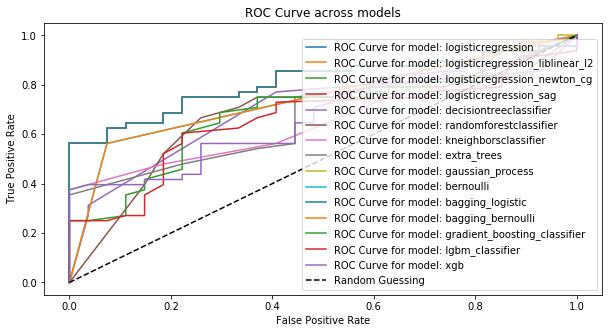

In [51]:

roc_rates = []
model_name = []
for index, key in enumerate(response):
    
    
    estimator = response.get(key)
    if estimator.get('roc_auc_score')!=0:
        roc_curve_true_positive_rate = estimator.get('roc_curve_true_positive_rate')
        roc_curve_false_positive_rate = estimator.get('roc_curve_false_positive_rate')
        roc_rates.append([roc_curve_false_positive_rate,roc_curve_true_positive_rate])
        model_name.append(key)

plotROCCurveAcrossModels(roc_rates,model_name) 



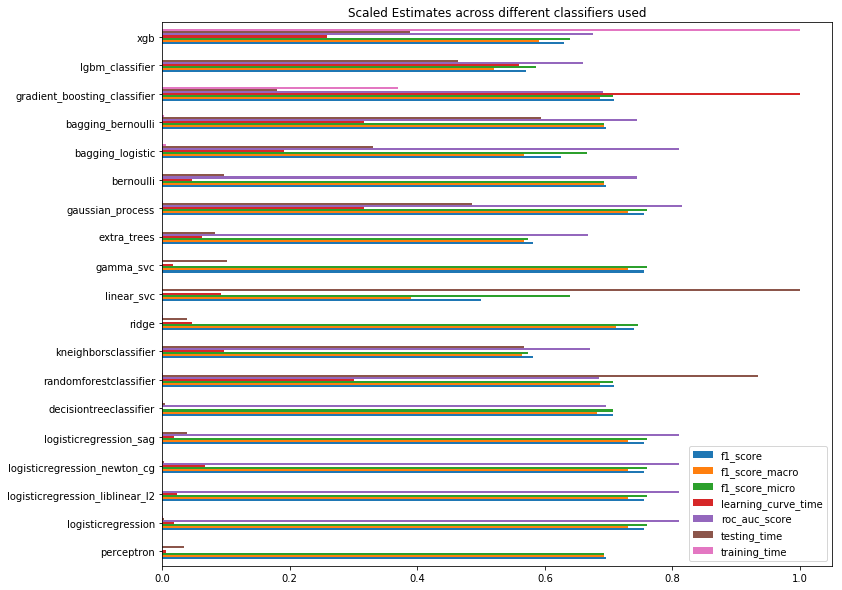

In [52]:
results['learning_curve_time'] = results['learning_curve_time'].astype('float64')
results['testing_time'] = results['testing_time'].astype('float64')
results['training_time'] = results['training_time'].astype('float64')
results['f1_score'] = results['f1_score'].astype('float64')
results['f1_score_micro'] = results['f1_score_micro'].astype('float64')
results['f1_score_macro'] = results['f1_score_macro'].astype('float64')
results['roc_auc_score'] = results['roc_auc_score'].astype('float64')
# results['roc_auc_macro'] = results['roc_auc_macro'].astype('float64')

#scaling time parameters between 0 and 1
results['learning_curve_time'] = (results['learning_curve_time']- results['learning_curve_time'].min())/(results['learning_curve_time'].max()- results['learning_curve_time'].min())
results['testing_time'] = (results['testing_time']- results['testing_time'].min())/(results['testing_time'].max()- results['testing_time'].min())
results['training_time'] = (results['training_time']- results['training_time'].min())/(results['training_time'].max()- results['training_time'].min())

results.plot(kind='barh',figsize=(12, 10))
plot.title("Scaled Estimates across different classifiers used")
plot.show()

In [60]:
estimators = [  
    ('gaussian_process', response.get('gaussian_process',{}).get('best_estimator')),
#     ('bagging_logistic',response.get('bagging_logistic',{}).get('best_estimator')),
    ('logisticregression_liblinear_l2', response.get('logisticregression_liblinear_l2',{}).get('best_estimator')),
#     ('logisticregression_newton_cg', response.get('logisticregression_newton_cg',{}).get('best_estimator')),
#     ('logisticregression_sag', response.get('logisticregression_sag',{}).get('best_estimator')),           
        ]

vc = VotingClassifier(estimators, voting ='soft')
from sklearn.model_selection import cross_val_score
scaler = StandardScaler()
scores = cross_val_score(vc,X= scaler.fit_transform(x_train), y= y_train, scoring=score, cv = cv)
scores

array([0.66555184, 0.82943144, 0.77272727, 0.65530303, 0.71590909])

In [57]:
test_data = panda.read_csv('data/test.csv')

test_data_x = test_data[col_names]

test_data_x_lda = lda.transform(MinMaxScaler().fit_transform(test_data_x))

Grid Search Best parameters  {}
Grid Search Best score  0.7284917980570155
Code block 'training' took(HH:MM:SS): 0:00:00.136937
Code block 'testing' took(HH:MM:SS): 0:00:00.002595
F1 score 0.7552
Classification report  
               precision    recall  f1-score   support

           0       0.70      0.59      0.64        27
           1       0.79      0.85      0.82        48

   micro avg       0.76      0.76      0.76        75
   macro avg       0.74      0.72      0.73        75
weighted avg       0.76      0.76      0.76        75



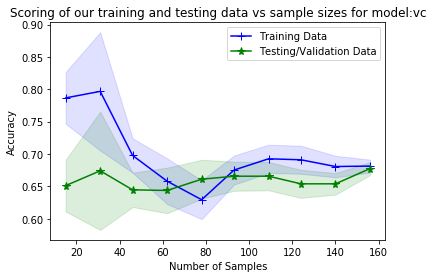

Confusion matrix, without normalization
[[16 11]
 [ 7 41]]


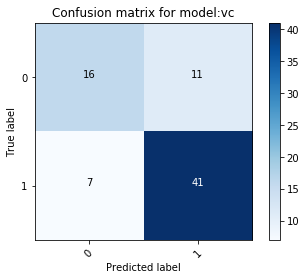

Code block 'learning_curve' took(HH:MM:SS): 0:00:01.703942
inside decision function


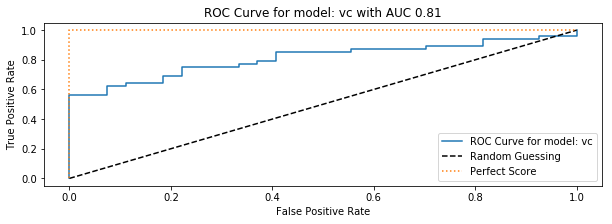

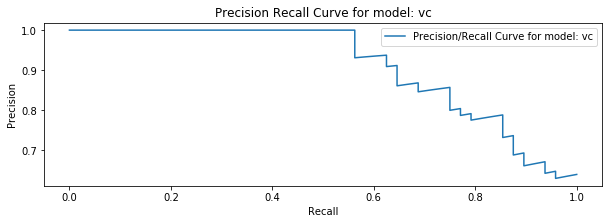

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.337182
Code block 'overalltime' took(HH:MM:SS): 0:00:02.188148
2188.148106850349


In [61]:
classifiers_1 = [vc]
classifiers_1_names = ['vc']
classifiers_1_param_grid = [{}]
response_vc = execute(
        x_train,
        y_train,
        x_test,
        y_test,
        classifiers_1,
        classifiers_1_names,
        classifiers_1_param_grid,
        cv=cv,
        score=score,
        scaler=StandardScaler())

In [62]:
test_target = response_vc.get('vc').get('best_estimator').predict(test_data_x_lda)

In [63]:
np.bincount(test_target)

array([ 2533, 17217], dtype=int64)

In [64]:
final_submission = panda.DataFrame({'target':test_target})
final_submission['id'] = test_data['id']
final_submission[['id','target']].head() 

# np.bincount(test_target)

final_submission[['id','target']].to_csv('sample_submission_lda_with_gaussian.csv', index = False)

### Conclusion:

1. We got highest scores of ROC/AUC 0.92 in logistic regression with l2 parameter

2. From the learning curve, we also see that overfitting tendency is less


In [ ]:
test_data = panda.read_csv('data/test.csv')

test_data_x = test_data[reqd_columns]


### STEP 2: Run Dimensionality technique, specifically t-SNE

<br><br>

In [220]:

## perplexity parameters were tuned
tsne = TSNE(perplexity=35, learning_rate=15)
scaler = StandardScaler()
x_train_tsne = tsne.fit_transform(scaler.fit_transform(x_train))
x_test_tsne = tsne.fit_transform(scaler.fit_transform(x_test))

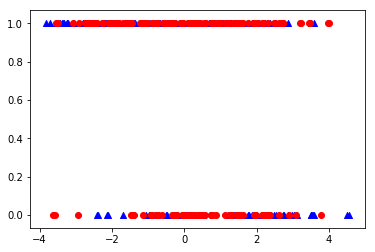

In [221]:
# plot.scatter(x_train_tsne[:,0]x_train_tsne[:,0], x_train_tsne[:,1])
plot.scatter(x_train_tsne[:,0], y_train,  marker='^', c='blue')
plot.scatter(x_train_tsne[:,1], y_train,  marker='o', c='red')
plot.show()
# x_train_tsne[:,1].shape, y_train.shape

Grid Search Best parameters  {'perceptron__eta0': 0.1, 'perceptron__max_iter': 30}
Grid Search Best score  0.7025287755722539
Code block 'training' took(HH:MM:SS): 0:00:00.093815
Code block 'testing' took(HH:MM:SS): 0:00:00.000167
F1 score 0.49951219512195116
Classification report  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.64      1.00      0.78        48

   micro avg       0.64      0.64      0.64        75
   macro avg       0.32      0.50      0.39        75
weighted avg       0.41      0.64      0.50        75



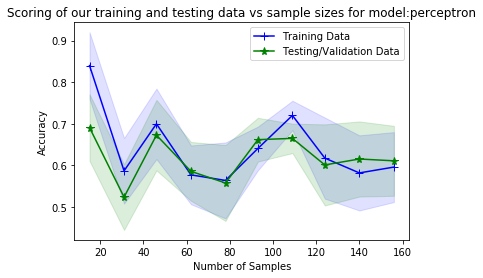

Confusion matrix, without normalization
[[ 0 27]
 [ 0 48]]


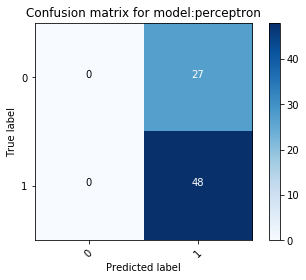

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.875237
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000029
Grid Search Best parameters  {'logisticregression__C': 1.2, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
Grid Search Best score  0.7605662453488542
Code block 'training' took(HH:MM:SS): 0:00:00.801185
Code block 'testing' took(HH:MM:SS): 0:00:00.000251
F1 score 0.49951219512195116
Classification report  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.64      1.00      0.78        48

   micro avg       0.64      0.64      0.64        75
   macro avg       0.32      0.50      0.39        75
weighted avg       0.41      0.64      0.50        75



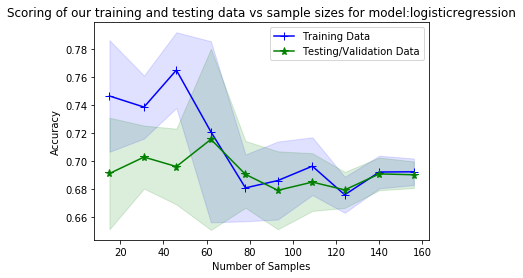

Confusion matrix, without normalization
[[ 0 27]
 [ 0 48]]


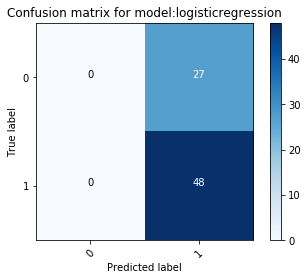

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.824075
inside decision function


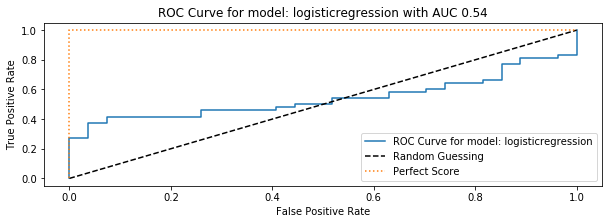

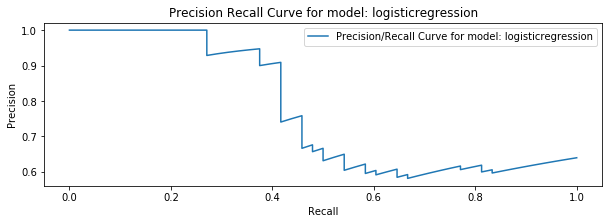

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.457935
Grid Search Best parameters  {'logisticregression_liblinear_l2__C': 1.2, 'logisticregression_liblinear_l2__dual': True, 'logisticregression_liblinear_l2__penalty': 'l2'}
Grid Search Best score  0.7578029217159652
Code block 'training' took(HH:MM:SS): 0:00:00.221655
Code block 'testing' took(HH:MM:SS): 0:00:00.000249
F1 score 0.49951219512195116
Classification report  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.64      1.00      0.78        48

   micro avg       0.64      0.64      0.64        75
   macro avg       0.32      0.50      0.39        75
weighted avg       0.41      0.64      0.50        75



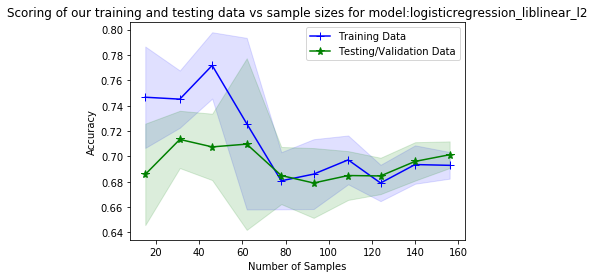

Confusion matrix, without normalization
[[ 0 27]
 [ 0 48]]


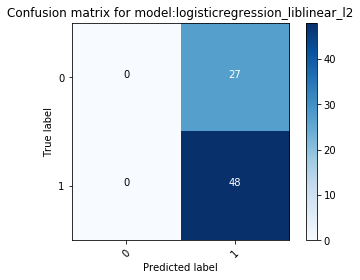

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.894620
inside decision function


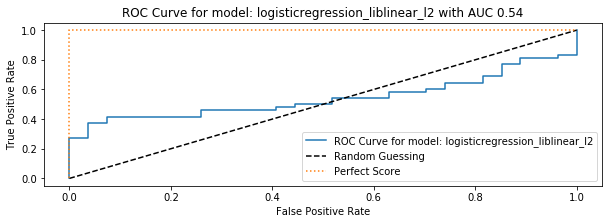

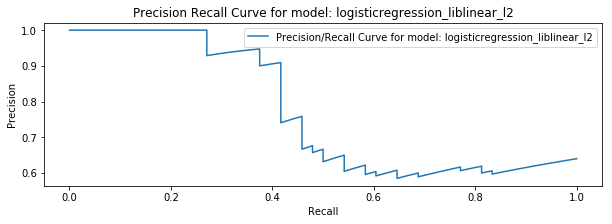

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.468413
Grid Search Best parameters  {'logisticregression_newton_cg__C': 0.05, 'logisticregression_newton_cg__penalty': 'l2'}
Grid Search Best score  0.7598303146129234
Code block 'training' took(HH:MM:SS): 0:00:00.782147
Code block 'testing' took(HH:MM:SS): 0:00:00.000243
F1 score 0.49951219512195116
Classification report  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.64      1.00      0.78        48

   micro avg       0.64      0.64      0.64        75
   macro avg       0.32      0.50      0.39        75
weighted avg       0.41      0.64      0.50        75



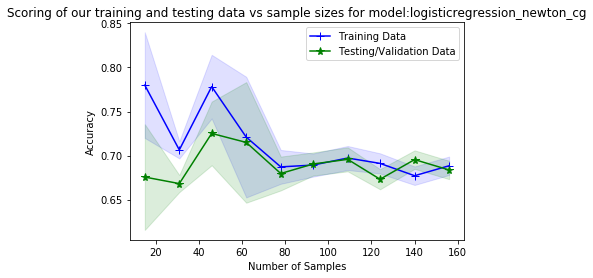

Confusion matrix, without normalization
[[ 0 27]
 [ 0 48]]


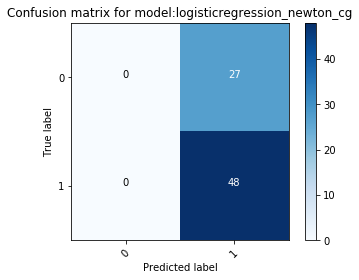

Code block 'learning_curve' took(HH:MM:SS): 0:00:02.522258
inside decision function


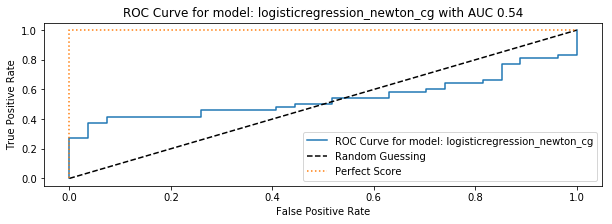

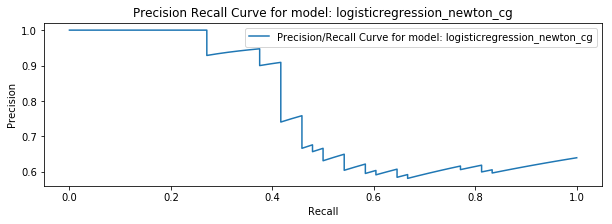

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.577934
Grid Search Best parameters  {'logisticregression_sag__C': 0.05, 'logisticregression_sag__penalty': 'l2'}
Grid Search Best score  0.7598303146129234
Code block 'training' took(HH:MM:SS): 0:00:00.234329
Code block 'testing' took(HH:MM:SS): 0:00:00.000206
F1 score 0.49951219512195116
Classification report  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.64      1.00      0.78        48

   micro avg       0.64      0.64      0.64        75
   macro avg       0.32      0.50      0.39        75
weighted avg       0.41      0.64      0.50        75



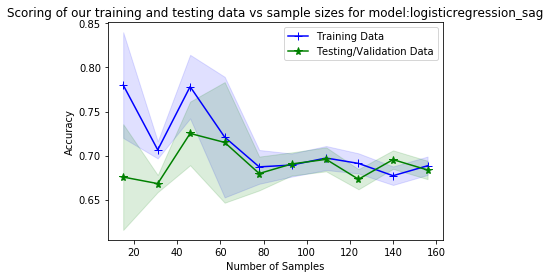

Confusion matrix, without normalization
[[ 0 27]
 [ 0 48]]


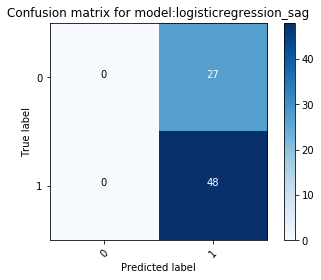

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.906294
inside decision function


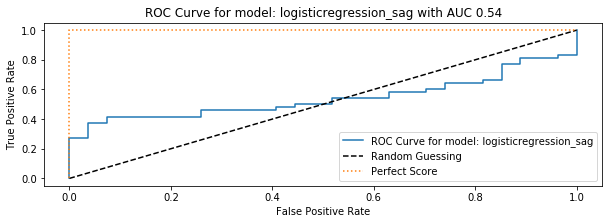

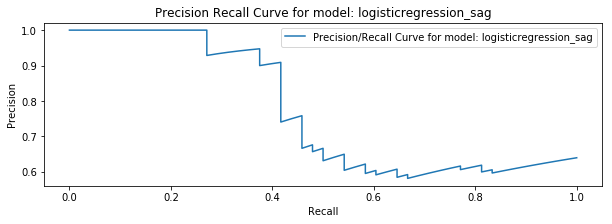

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.419948
Grid Search Best parameters  {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 6, 'decisiontreeclassifier__max_features': 'log2'}
Grid Search Best score  0.7764835164835165
Code block 'training' took(HH:MM:SS): 0:00:00.545406
Code block 'testing' took(HH:MM:SS): 0:00:00.000247
F1 score 0.5664830508474576
Classification report  
               precision    recall  f1-score   support

           0       0.60      0.11      0.19        27
           1       0.66      0.96      0.78        48

   micro avg       0.65      0.65      0.65        75
   macro avg       0.63      0.53      0.48        75
weighted avg       0.64      0.65      0.57        75



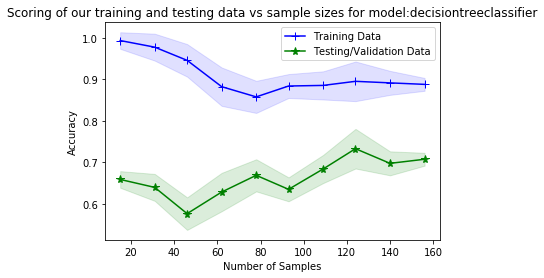

Confusion matrix, without normalization
[[ 3 24]
 [ 2 46]]


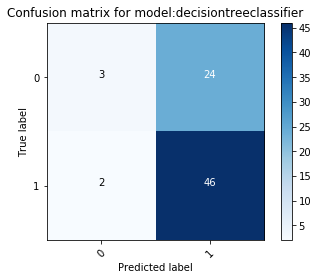

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.781119
inside decision function


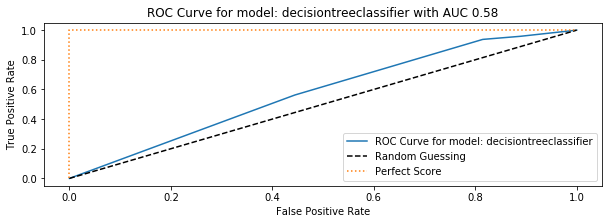

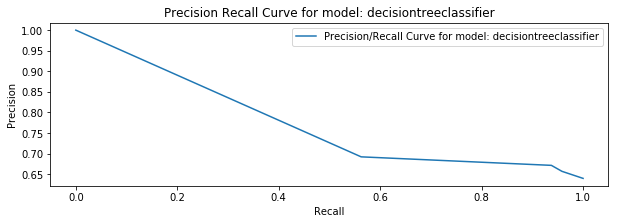

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.466123
Grid Search Best parameters  {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__n_estimators': 8}
Grid Search Best score  0.7928818283166109
Code block 'training' took(HH:MM:SS): 0:00:00.672940
Code block 'testing' took(HH:MM:SS): 0:00:00.001810
F1 score 0.5493333333333333
Classification report  
               precision    recall  f1-score   support

           0       0.67      0.07      0.13        27
           1       0.65      0.98      0.78        48

   micro avg       0.65      0.65      0.65        75
   macro avg       0.66      0.53      0.46        75
weighted avg       0.66      0.65      0.55        75



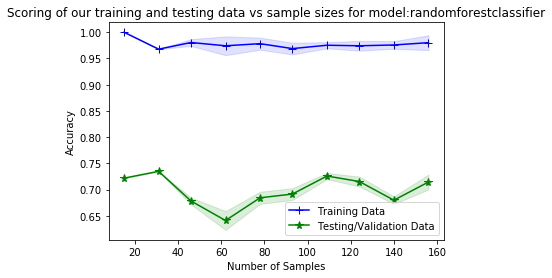

Confusion matrix, without normalization
[[ 2 25]
 [ 1 47]]


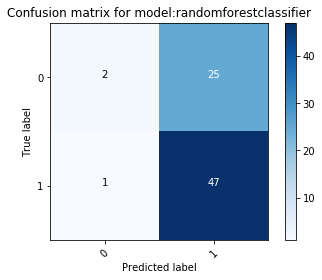

Code block 'learning_curve' took(HH:MM:SS): 0:00:02.240760
inside decision function


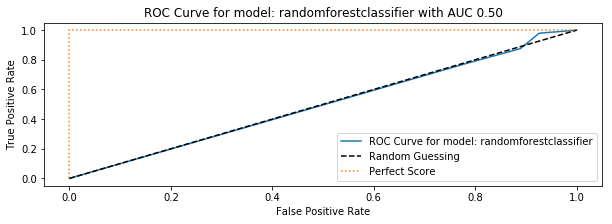

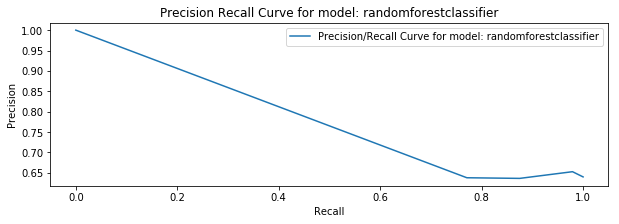

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.475887
Grid Search Best parameters  {'kneighborsclassifier__n_neighbors': 10}
Grid Search Best score  0.8147949152296978
Code block 'training' took(HH:MM:SS): 0:00:00.132983
Code block 'testing' took(HH:MM:SS): 0:00:00.001844
F1 score 0.49951219512195116
Classification report  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.64      1.00      0.78        48

   micro avg       0.64      0.64      0.64        75
   macro avg       0.32      0.50      0.39        75
weighted avg       0.41      0.64      0.50        75



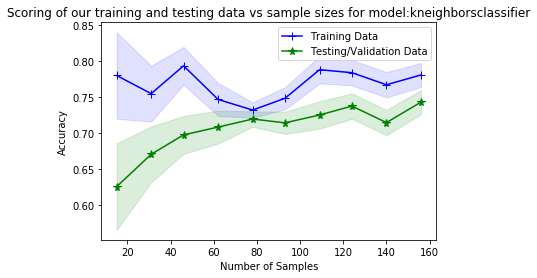

Confusion matrix, without normalization
[[ 0 27]
 [ 0 48]]


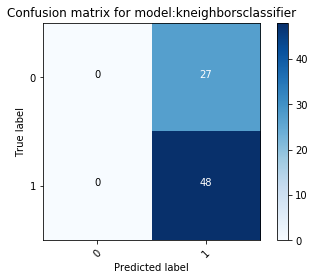

Code block 'learning_curve' took(HH:MM:SS): 0:00:01.114165
inside decision function


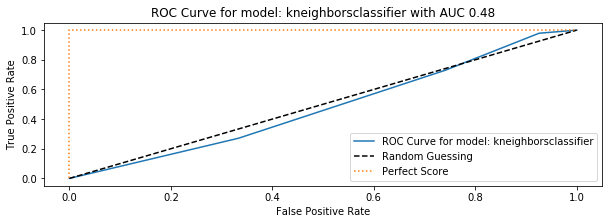

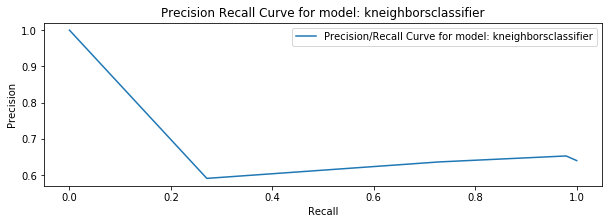

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.449537
Grid Search Best parameters  {'ridge__alpha': 1, 'ridge__max_iter': 100}
Grid Search Best score  0.7577662916793351
Code block 'training' took(HH:MM:SS): 0:00:00.384265
Code block 'testing' took(HH:MM:SS): 0:00:00.000250
F1 score 0.49951219512195116
Classification report  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.64      1.00      0.78        48

   micro avg       0.64      0.64      0.64        75
   macro avg       0.32      0.50      0.39        75
weighted avg       0.41      0.64      0.50        75



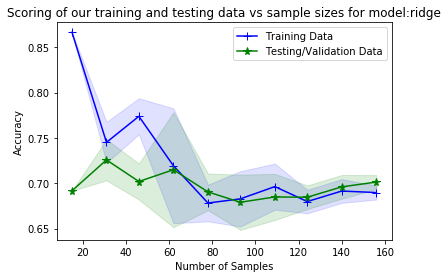

Confusion matrix, without normalization
[[ 0 27]
 [ 0 48]]


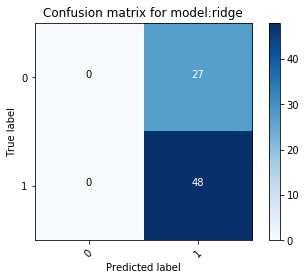

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.973324
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000027
Grid Search Best parameters  {'linear_svc__C': 0.025}
Grid Search Best score  0.7577522477522478
Code block 'training' took(HH:MM:SS): 0:00:00.044211
Code block 'testing' took(HH:MM:SS): 0:00:00.000715
F1 score 0.49951219512195116
Classification report  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.64      1.00      0.78        48

   micro avg       0.64      0.64      0.64        75
   macro avg       0.32      0.50      0.39        75
weighted avg       0.41      0.64      0.50        75



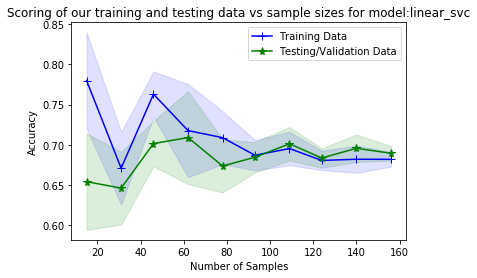

Confusion matrix, without normalization
[[ 0 27]
 [ 0 48]]


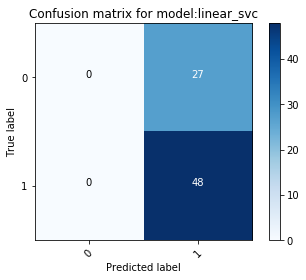

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.824199
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000048
Grid Search Best parameters  {'gamma_svc__C': 1, 'gamma_svc__gamma': 2}
Grid Search Best score  0.7751727982162764
Code block 'training' took(HH:MM:SS): 0:00:00.201821
Code block 'testing' took(HH:MM:SS): 0:00:00.001293
F1 score 0.49951219512195116
Classification report  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.64      1.00      0.78        48

   micro avg       0.64      0.64      0.64        75
   macro avg       0.32      0.50      0.39        75
weighted avg       0.41      0.64      0.50        75



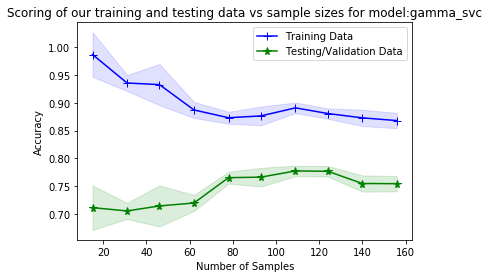

Confusion matrix, without normalization
[[ 0 27]
 [ 0 48]]


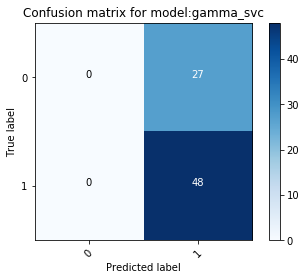

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.926339
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000028
Grid Search Best parameters  {'extra_trees__criterion': 'gini', 'extra_trees__max_depth': 6}
Grid Search Best score  0.7303940262635913
Code block 'training' took(HH:MM:SS): 0:00:00.186641
Code block 'testing' took(HH:MM:SS): 0:00:00.000271
F1 score 0.5220176688515247
Classification report  
               precision    recall  f1-score   support

           0       0.50      0.04      0.07        27
           1       0.64      0.98      0.78        48

   micro avg       0.64      0.64      0.64        75
   macro avg       0.57      0.51      0.42        75
weighted avg       0.59      0.64      0.52        75



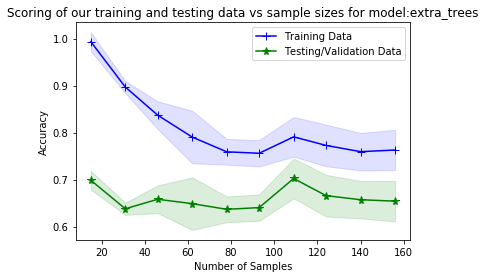

Confusion matrix, without normalization
[[ 1 26]
 [ 1 47]]


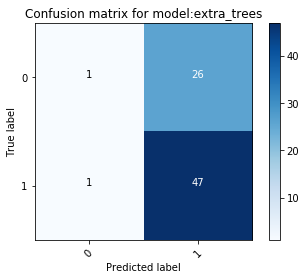

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.763399
inside decision function


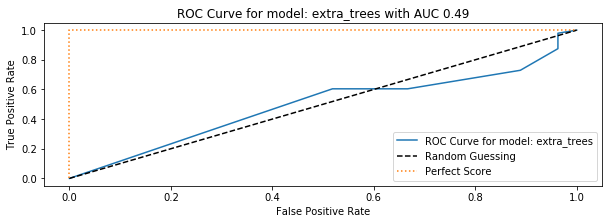

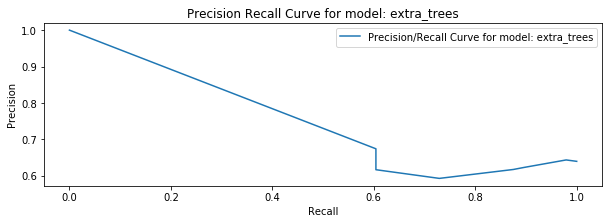

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.476272
Grid Search Best parameters  {'gaussian_process__max_iter_predict': 200}
Grid Search Best score  0.8334584256323385
Code block 'training' took(HH:MM:SS): 0:00:00.262148
Code block 'testing' took(HH:MM:SS): 0:00:00.000660
F1 score 0.49951219512195116
Classification report  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.64      1.00      0.78        48

   micro avg       0.64      0.64      0.64        75
   macro avg       0.32      0.50      0.39        75
weighted avg       0.41      0.64      0.50        75



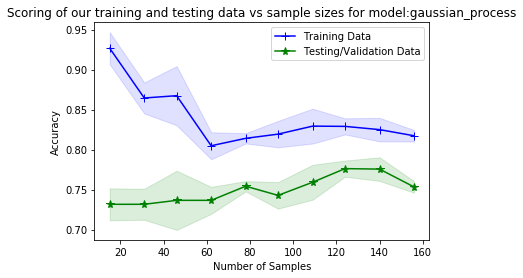

Confusion matrix, without normalization
[[ 0 27]
 [ 0 48]]


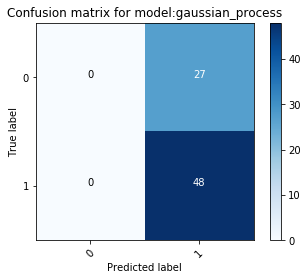

Code block 'learning_curve' took(HH:MM:SS): 0:00:01.810638
inside decision function


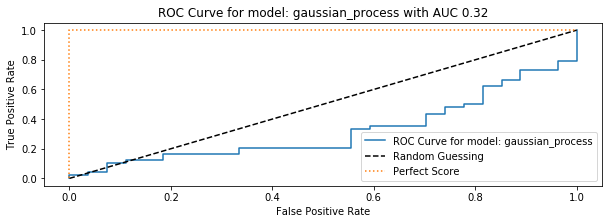

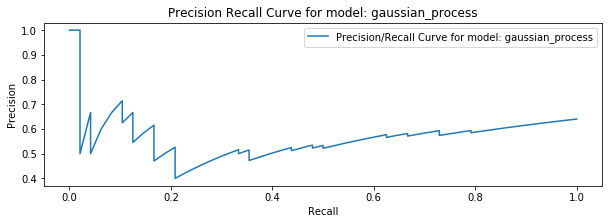

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.564720
Grid Search Best parameters  {'bernoulli__alpha': 0.2}
Grid Search Best score  0.7079832486354225
Code block 'training' took(HH:MM:SS): 0:00:00.114346
Code block 'testing' took(HH:MM:SS): 0:00:00.000787
F1 score 0.49951219512195116
Classification report  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.64      1.00      0.78        48

   micro avg       0.64      0.64      0.64        75
   macro avg       0.32      0.50      0.39        75
weighted avg       0.41      0.64      0.50        75



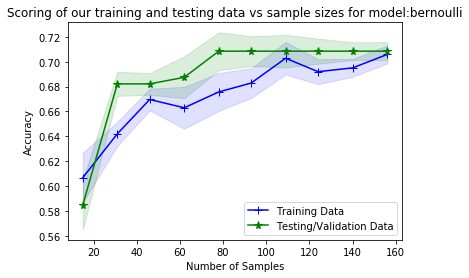

Confusion matrix, without normalization
[[ 0 27]
 [ 0 48]]


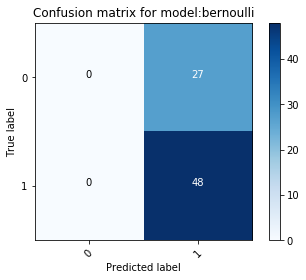

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.865422
inside decision function


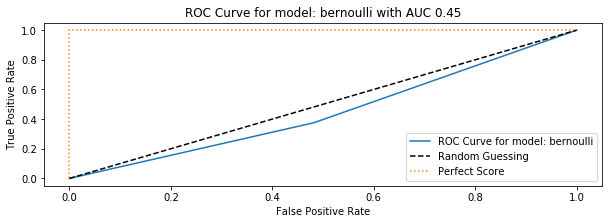

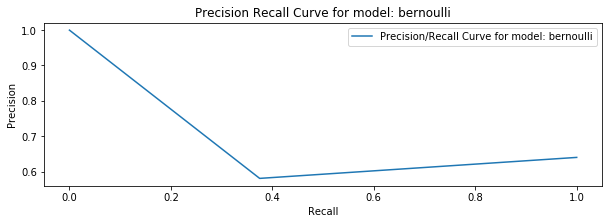

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.452622
Grid Search Best parameters  {'bagging_logistic__base_estimator__C': 1.2, 'bagging_logistic__base_estimator__penalty': 'l2', 'bagging_logistic__n_estimators': 8}
Grid Search Best score  0.7645108514673733
Code block 'training' took(HH:MM:SS): 0:00:02.626842
Code block 'testing' took(HH:MM:SS): 0:00:00.002515
F1 score 0.49951219512195116
Classification report  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.64      1.00      0.78        48

   micro avg       0.64      0.64      0.64        75
   macro avg       0.32      0.50      0.39        75
weighted avg       0.41      0.64      0.50        75



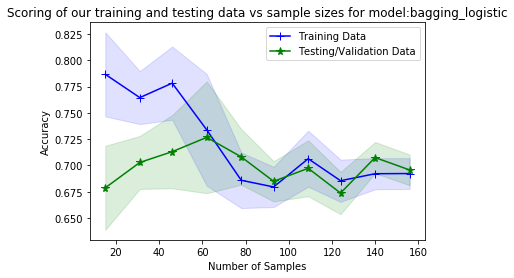

Confusion matrix, without normalization
[[ 0 27]
 [ 0 48]]


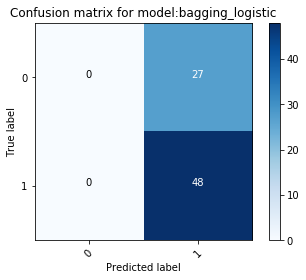

Code block 'learning_curve' took(HH:MM:SS): 0:00:02.401102
inside decision function


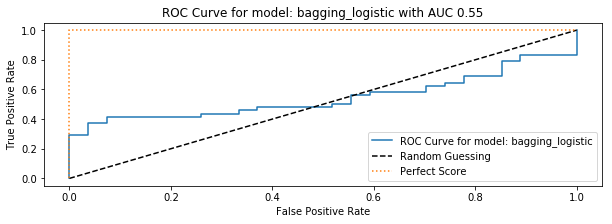

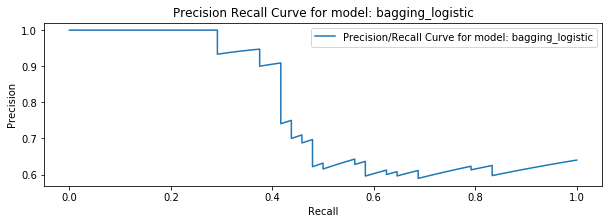

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.457570
Grid Search Best parameters  {'bagging_bernoulli__base_estimator__alpha': 1.2, 'bagging_bernoulli__n_estimators': 5}
Grid Search Best score  0.7079832486354225
Code block 'training' took(HH:MM:SS): 0:00:01.570932
Code block 'testing' took(HH:MM:SS): 0:00:00.003652
F1 score 0.49951219512195116
Classification report  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.64      1.00      0.78        48

   micro avg       0.64      0.64      0.64        75
   macro avg       0.32      0.50      0.39        75
weighted avg       0.41      0.64      0.50        75



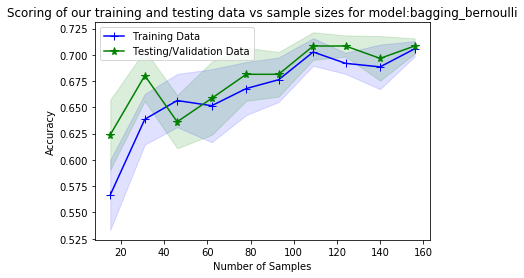

Confusion matrix, without normalization
[[ 0 27]
 [ 0 48]]


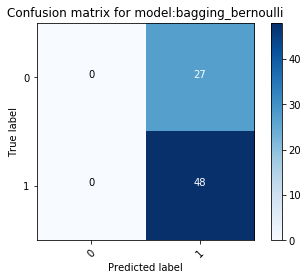

Code block 'learning_curve' took(HH:MM:SS): 0:00:02.154009
inside decision function


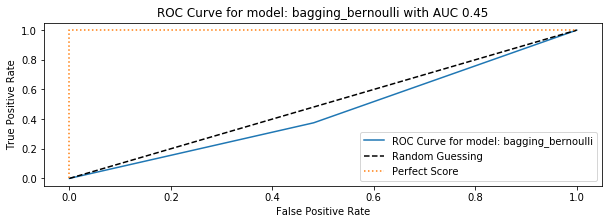

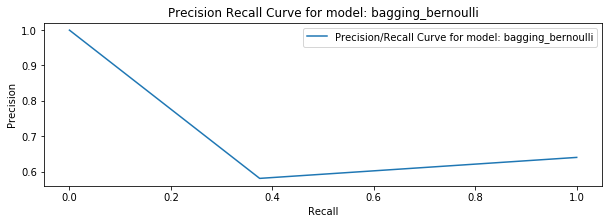

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.470847
Grid Search Best parameters  {'gradient_boosting_classifier__criterion': 'friedman_mse', 'gradient_boosting_classifier__learning_rate': 1.2, 'gradient_boosting_classifier__loss': 'exponential', 'gradient_boosting_classifier__max_depth': 6, 'gradient_boosting_classifier__n_estimators': 100}
Grid Search Best score  0.8030040249605467
Code block 'training' took(HH:MM:SS): 0:04:13.501643
Code block 'testing' took(HH:MM:SS): 0:00:00.000603
F1 score 0.5490466531440161
Classification report  
               precision    recall  f1-score   support

           0       0.43      0.11      0.18        27
           1       0.65      0.92      0.76        48

   micro avg       0.63      0.63      0.63        75
   macro avg       0.54      0.51      0.47        75
weighted avg       0.57      0.63      0.55        75



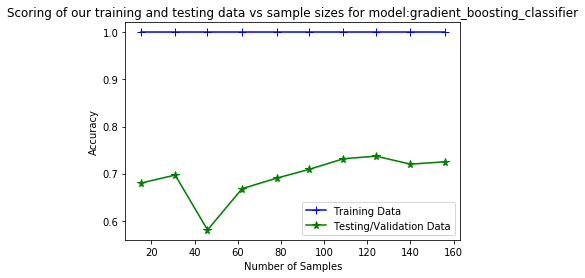

Confusion matrix, without normalization
[[ 3 24]
 [ 4 44]]


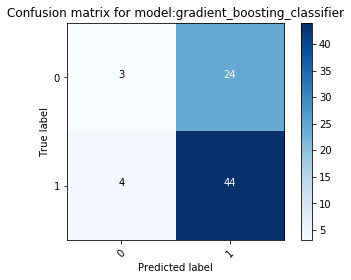

Code block 'learning_curve' took(HH:MM:SS): 0:00:06.299052
inside decision function


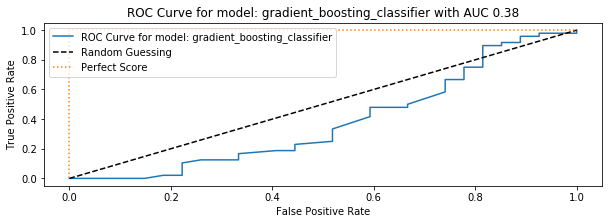

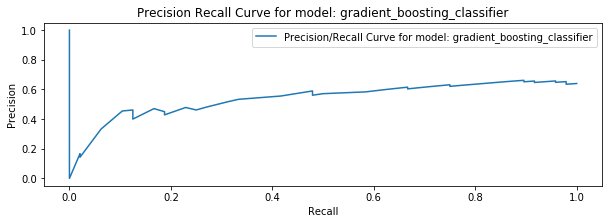

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.542011
Grid Search Best parameters  {'lgbm_classifier__bagging_freq': 1, 'lgbm_classifier__bagging_seed': 123, 'lgbm_classifier__feature_fraction': 0.9, 'lgbm_classifier__learning_rate': 0.01, 'lgbm_classifier__max_depth': 20, 'lgbm_classifier__min_child_samples': 2, 'lgbm_classifier__n_estimators': 5000, 'lgbm_classifier__num_boost_round': 100, 'lgbm_classifier__num_leaves': 25}
Grid Search Best score  0.6805304116173682
Code block 'training' took(HH:MM:SS): 0:00:00.355492
Code block 'testing' took(HH:MM:SS): 0:00:00.001657
F1 score 0.5412415288696123
Classification report  
               precision    recall  f1-score   support

           0       0.50      0.07      0.13        27
           1       0.65      0.96      0.77        48

   micro avg       0.64      0.64      0.64        75
   macro avg       0.57      0.52      0.45        75
weighted avg       0.59      0.64      0.54        75



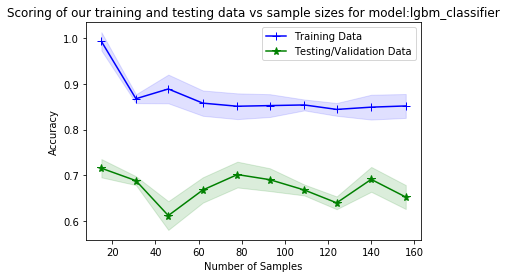

Confusion matrix, without normalization
[[ 2 25]
 [ 2 46]]


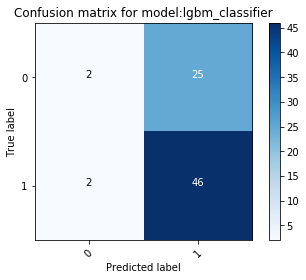

Code block 'learning_curve' took(HH:MM:SS): 0:00:04.859330
inside decision function


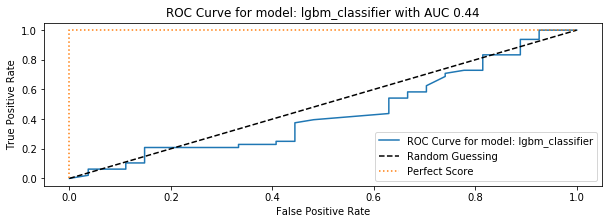

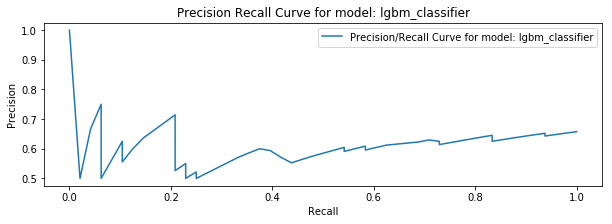

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.569494
Grid Search Best parameters  {'xgb__booster': 'gbtree', 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
Grid Search Best score  0.8067938583155975
Code block 'training' took(HH:MM:SS): 0:07:41.112260
Code block 'testing' took(HH:MM:SS): 0:00:00.000622
F1 score 0.4931147540983606
Classification report  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.64      0.98      0.77        48

   micro avg       0.63      0.63      0.63        75
   macro avg       0.32      0.49      0.39        75
weighted avg       0.41      0.63      0.49        75



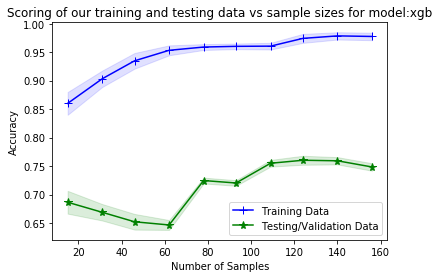

Confusion matrix, without normalization
[[ 0 27]
 [ 1 47]]


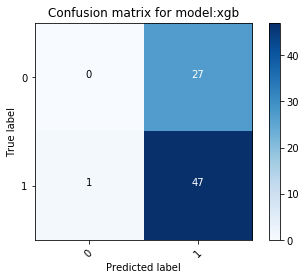

Code block 'learning_curve' took(HH:MM:SS): 0:00:01.343429
inside decision function


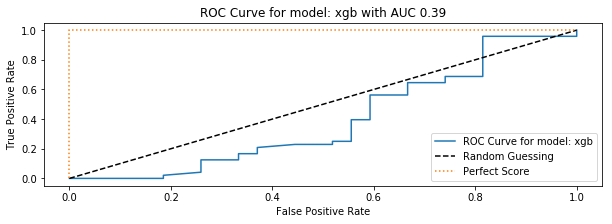

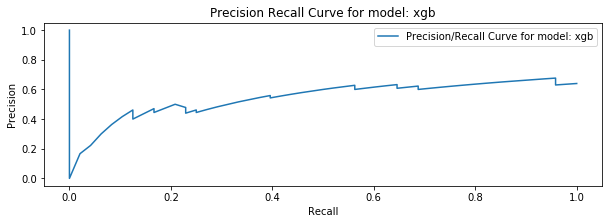

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.257274
Code block 'overalltime' took(HH:MM:SS): 0:12:44.595936
764595.9362025787


In [222]:

##runing without scaling, since scaling was already done prior to tsne
response = execute(
        x_train_tsne,
        y_train,
        x_test_tsne,
        y_test,
        classifiers,
        classifier_names,
        classifier_param_grid,
        cv=cv,
        score=score,
        scaler=None)

In [223]:
results = panda.DataFrame(response).transpose()
results.head()
results[['f1_score',
         'f1_score_macro',
         'f1_score_micro',
         'learning_curve_time',
         'roc_auc_score',
         'testing_time',
         'training_time',
        ]]\
.sort_values(by=['roc_auc_score',],ascending=False)

f1_score f1_score_macro f1_score_micro  \
decisiontreeclassifier           0.566483       0.483581       0.653333   
bagging_logistic                 0.499512       0.390244           0.64   
logisticregression_liblinear_l2  0.499512       0.390244           0.64   
logisticregression_newton_cg     0.499512       0.390244           0.64   
logisticregression_sag           0.499512       0.390244           0.64   
logisticregression               0.499512       0.390244           0.64   
randomforestclassifier           0.549333       0.458333       0.653333   
extra_trees                      0.522018       0.422913           0.64   
kneighborsclassifier             0.499512       0.390244           0.64   
bagging_bernoulli                0.499512       0.390244           0.64   
bernoulli                        0.499512       0.390244           0.64   
lgbm_classifier                  0.541242       0.451071           0.64   
xgb                              0.493115       0.385246       0.626667   
gradient_boosting_classifier     0.549047       0.467546       0.626667   
gaussian_process                 0.499512       0.390244           0.64   
perceptron                       0.499512       0.390244           0.64   
gamma_svc                        0.499512       0.390244           0.64   
ridge                            0.499512       0.390244           0.64   
linear_svc                       0.499512       0.390244           0.64   

                                learning_curve_time roc_auc_score  \
decisiontreeclassifier                      781.119       0.58179   
bagging_logistic                             2401.1      0.546296   
logisticregression_liblinear_l2              894.62      0.542438   
logisticregression_newton_cg                2522.26      0.541667   
logisticregression_sag                      906.294      0.541667   
logisticregression                          824.075      0.541667   
randomforestclassifier                      2240.76      0.498843   
extra_trees                                 763.399      0.490355   
kneighborsclassifier                        1114.17      0.480324   
bagging_bernoulli                           2154.01      0.446759   
bernoulli                                   865.422      0.446759   
lgbm_classifier                             4859.33      0.439815   
xgb                                         1343.43      0.392747   
gradient_boosting_classifier                6299.05      0.383488   
gaussian_process                            1810.64      0.321759   
perceptron                                  875.237             0   
gamma_svc                                   926.339             0   
ridge                                       973.324             0   
linear_svc                                  824.199             0   

                                testing_time training_time  
decisiontreeclassifier              0.246898       545.406  
bagging_logistic                     2.51506       2626.84  
logisticregression_liblinear_l2     0.249173       221.655  
logisticregression_newton_cg        0.242915       782.147  
logisticregression_sag              0.205938       234.329  
logisticregression                  0.251449       801.185  
randomforestclassifier                1.8102        672.94  
extra_trees                         0.270791       186.641  
kneighborsclassifier                 1.84434       132.983  
bagging_bernoulli                    3.65226       1570.93  
bernoulli                           0.786773       114.346  
lgbm_classifier                       1.6566       355.492  
xgb                                 0.622364        461112  
gradient_boosting_classifier        0.603022        253502  
gaussian_process                    0.659911       262.148  
perceptron                          0.167253       93.8148  
gamma_svc                            1.29251       201.821  
ridge                               0.250311       38

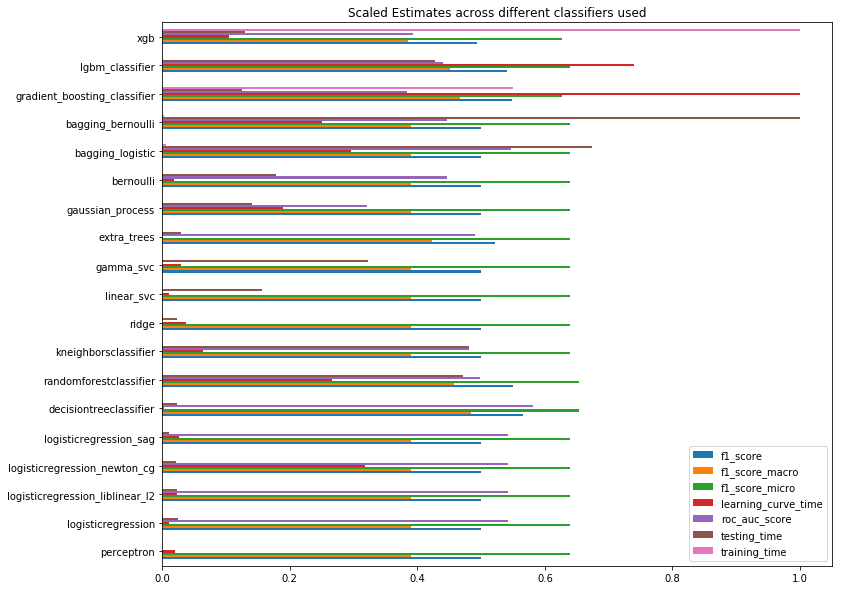

In [224]:
results['learning_curve_time'] = results['learning_curve_time'].astype('float64')
results['testing_time'] = results['testing_time'].astype('float64')
results['training_time'] = results['training_time'].astype('float64')
results['f1_score'] = results['f1_score'].astype('float64')
results['f1_score_micro'] = results['f1_score_micro'].astype('float64')
results['f1_score_macro'] = results['f1_score_macro'].astype('float64')
results['roc_auc_score'] = results['roc_auc_score'].astype('float64')
# results['roc_auc_macro'] = results['roc_auc_macro'].astype('float64')

#scaling time parameters between 0 and 1
results['learning_curve_time'] = (results['learning_curve_time']- results['learning_curve_time'].min())/(results['learning_curve_time'].max()- results['learning_curve_time'].min())
results['testing_time'] = (results['testing_time']- results['testing_time'].min())/(results['testing_time'].max()- results['testing_time'].min())
results['training_time'] = (results['training_time']- results['training_time'].min())/(results['training_time'].max()- results['training_time'].min())

results.plot(kind='barh',figsize=(12, 10))
plot.title("Scaled Estimates across different classifiers used")
plot.show()

### Conclusion: dimensionality reduction gives worse predictions

### STEP 3: Upsampling / Downsampling Techniques

<br><br>

In [48]:

classifiers = [
    Perceptron(random_state = 1),
    LogisticRegression(random_state = 1),
    LogisticRegression(random_state = 1, solver='liblinear'),
    LogisticRegression(random_state = 1, solver='newton-cg'),
    LogisticRegression(random_state = 1, solver='sag'),
    DecisionTreeClassifier(),
    RandomForestClassifier(random_state = 1),
    KNeighborsClassifier(metric = 'minkowski'),
    RidgeClassifier(random_state = 123), 
    SVC(kernel="linear"),
    SVC(),
    ExtraTreeClassifier(random_state = 123),
    GaussianProcessClassifier(random_state = 123),
    BernoulliNB(),
    BaggingClassifier(base_estimator = LogisticRegression(random_state = 1)),
    BaggingClassifier(base_estimator = BernoulliNB()),
 
]


classifier_names = [
            'perceptron',
            'logisticregression',
            'logisticregression_liblinear_l2',
            'logisticregression_newton_cg',
            'logisticregression_sag',
            'decisiontreeclassifier',
            'randomforestclassifier',
            'kneighborsclassifier',
            'ridge',
            'linear_svc',
            'gamma_svc',
            'extra_trees',
            'gaussian_process',
            'bernoulli',
            'bagging_logistic',
            'bagging_bernoulli',
 
]

classifier_param_grid = [
            
            {'perceptron__max_iter': [5,10,30], 'perceptron__eta0': [.1]},
            {
             'logisticregression__C':[1.2,0.02,2.2,4, 0.01, 0.05], 
             'logisticregression__penalty':['l1','l2'],
             'logisticregression__solver':['saga','liblinear']
            },
            {
             'logisticregression_liblinear_l2__C':[1.2,0.02,2.2,4, 0.01, 0.05], 
             'logisticregression_liblinear_l2__penalty':['l2'],
             'logisticregression_liblinear_l2__dual':[True]
            },
            {
             'logisticregression_newton_cg__C':[1.2,0.02,2.2,4, 0.01, 0.05], 
             'logisticregression_newton_cg__penalty':['l2'],
            },
            {
             'logisticregression_sag__C':[1.2,0.02,2.2,4, 0.01, 0.05], 
             'logisticregression_sag__penalty':['l2'],
            },
    
            {'decisiontreeclassifier__max_depth':[6,8,10],
             'decisiontreeclassifier__criterion':['gini','entropy'],
             'decisiontreeclassifier__max_features':['auto','sqrt','log2'],
            },
            {'randomforestclassifier__n_estimators':[6,8,12],'randomforestclassifier__criterion': ['gini','entropy']} ,
            {'kneighborsclassifier__n_neighbors':[4,6,10]},
            {'ridge__alpha':[1,1.2,0.9],'ridge__max_iter':[100,300,500]},
            {'linear_svc__C':[0.025]},
            {'gamma_svc__gamma':[2,4],'gamma_svc__C':[1,5]},
            {'extra_trees__max_depth':[6,8,12],'extra_trees__criterion': ['gini','entropy']} ,
            {'gaussian_process__max_iter_predict':[200,400]} ,
            {'bernoulli__alpha':[0.2,0.6,1.2]} ,
            {'bagging_logistic__base_estimator__C':[1.2,0.02,2.2,4], 
             'bagging_logistic__base_estimator__penalty':['l1','l2'],
             'bagging_logistic__n_estimators': [5,8,10]
            },
            {'bagging_bernoulli__base_estimator__alpha':[1.2,0.02,2.2,4], 
             'bagging_bernoulli__n_estimators': [5,8,10]
            },
    
]


In [43]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from imblearn.combine import SMOTETomek

In [44]:

tl = TomekLinks(return_indices=True, ratio='majority')
_x_train_tomek, _y_train_tomek, id_tl = tl.fit_sample(x_train, y_train)

smt = SMOTETomek(ratio='auto')
_x_train_smt, _y_train_smt = smt.fit_sample(x_train, y_train)

smote = SMOTE(ratio='minority')
x_train_smote, y_train_smote = smote.fit_sample(x_train,y_train)





In [45]:
_x_train_tomek.shape, _y_train_tomek.shape,x_test.shape,y_test.shape

((168, 50), (168,), (75, 50), (75,))

Grid Search Best parameters  {'perceptron__eta0': 0.1, 'perceptron__max_iter': 10}
Grid Search Best score  0.9337879382522241
Code block 'training' took(HH:MM:SS): 0:00:00.046745
Code block 'testing' took(HH:MM:SS): 0:00:00.002339
F1 score 0.8039408866995075
Classification report  
               precision    recall  f1-score   support

           0       0.67      0.89      0.76        27
           1       0.92      0.75      0.83        48

   micro avg       0.80      0.80      0.80        75
   macro avg       0.79      0.82      0.79        75
weighted avg       0.83      0.80      0.80        75



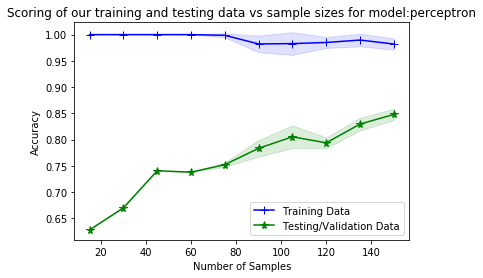

Confusion matrix, without normalization
[[24  3]
 [12 36]]


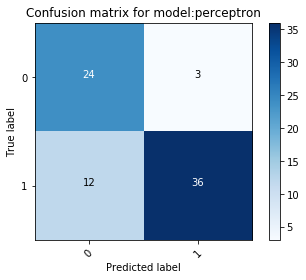

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.350319
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000023
Grid Search Best parameters  {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'saga'}
Grid Search Best score  0.9482546223617652
Code block 'training' took(HH:MM:SS): 0:00:00.690797
Code block 'testing' took(HH:MM:SS): 0:00:00.000532
F1 score 0.8622549019607844
Classification report  
               precision    recall  f1-score   support

           0       0.90      0.70      0.79        27
           1       0.85      0.96      0.90        48

   micro avg       0.87      0.87      0.87        75
   macro avg       0.88      0.83      0.85        75
weighted avg       0.87      0.87      0.86        75



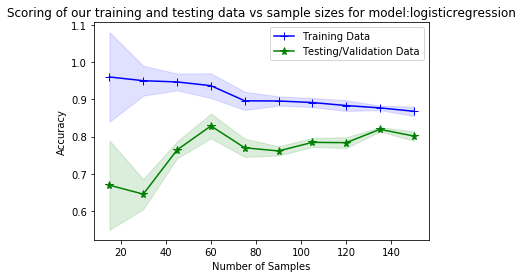

Confusion matrix, without normalization
[[19  8]
 [ 2 46]]


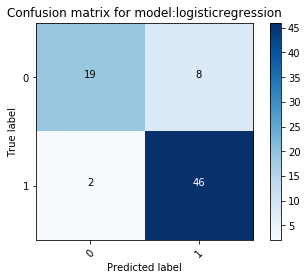

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.464711
inside decision function


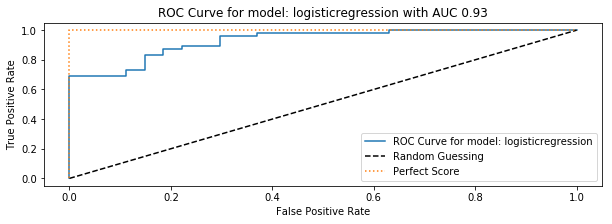

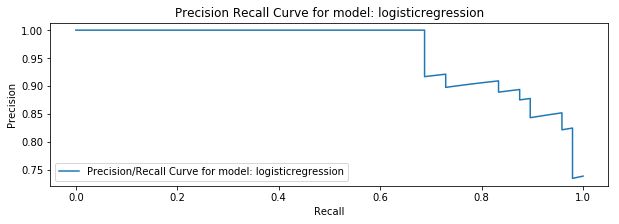

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.228912
Grid Search Best parameters  {'logisticregression_liblinear_l2__C': 0.05, 'logisticregression_liblinear_l2__dual': True, 'logisticregression_liblinear_l2__penalty': 'l2'}
Grid Search Best score  0.9399856096284668
Code block 'training' took(HH:MM:SS): 0:00:00.100333
Code block 'testing' took(HH:MM:SS): 0:00:00.000526
F1 score 0.8170639534883721
Classification report  
               precision    recall  f1-score   support

           0       0.68      0.93      0.78        27
           1       0.95      0.75      0.84        48

   micro avg       0.81      0.81      0.81        75
   macro avg       0.81      0.84      0.81        75
weighted avg       0.85      0.81      0.82        75



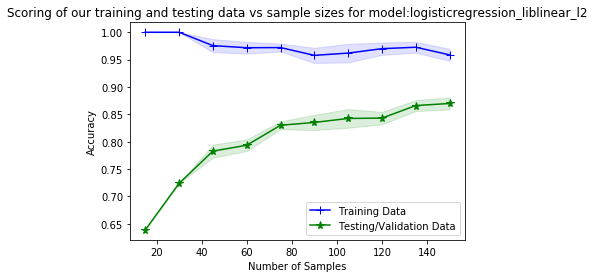

Confusion matrix, without normalization
[[25  2]
 [12 36]]


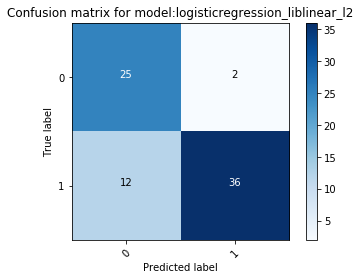

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.339096
inside decision function


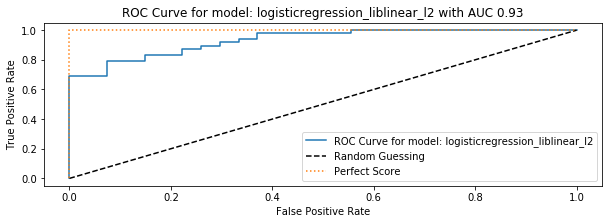

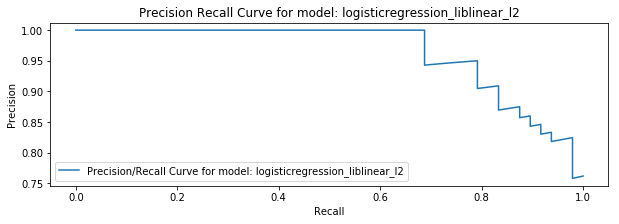

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.288531
Grid Search Best parameters  {'logisticregression_newton_cg__C': 0.01, 'logisticregression_newton_cg__penalty': 'l2'}
Grid Search Best score  0.9482546223617652
Code block 'training' took(HH:MM:SS): 0:00:00.187231
Code block 'testing' took(HH:MM:SS): 0:00:00.000609
F1 score 0.8622549019607844
Classification report  
               precision    recall  f1-score   support

           0       0.90      0.70      0.79        27
           1       0.85      0.96      0.90        48

   micro avg       0.87      0.87      0.87        75
   macro avg       0.88      0.83      0.85        75
weighted avg       0.87      0.87      0.86        75



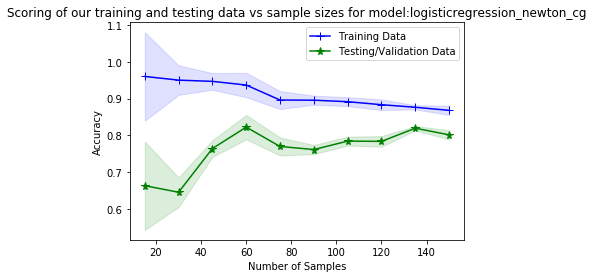

Confusion matrix, without normalization
[[19  8]
 [ 2 46]]


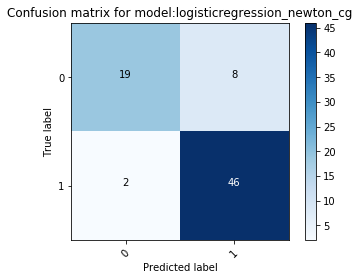

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.580879
inside decision function


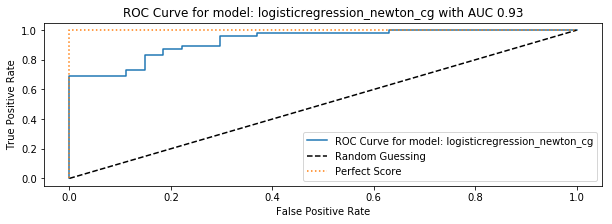

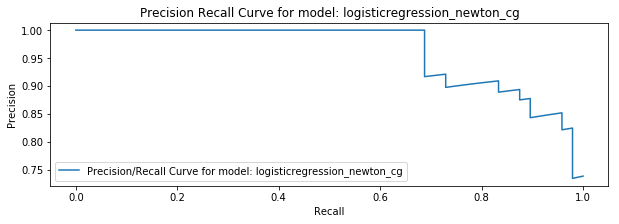

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.232827
Grid Search Best parameters  {'logisticregression_sag__C': 0.01, 'logisticregression_sag__penalty': 'l2'}
Grid Search Best score  0.9482546223617652
Code block 'training' took(HH:MM:SS): 0:00:00.213607
Code block 'testing' took(HH:MM:SS): 0:00:00.001289
F1 score 0.8622549019607844
Classification report  
               precision    recall  f1-score   support

           0       0.90      0.70      0.79        27
           1       0.85      0.96      0.90        48

   micro avg       0.87      0.87      0.87        75
   macro avg       0.88      0.83      0.85        75
weighted avg       0.87      0.87      0.86        75



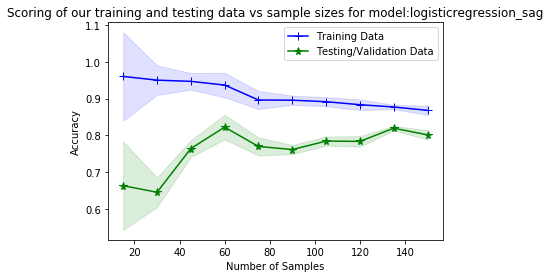

Confusion matrix, without normalization
[[19  8]
 [ 2 46]]


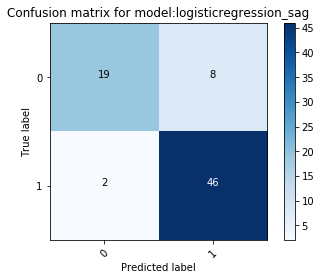

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.415889
inside decision function


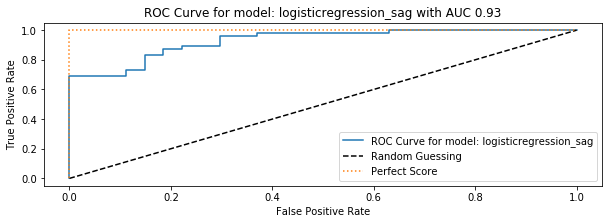

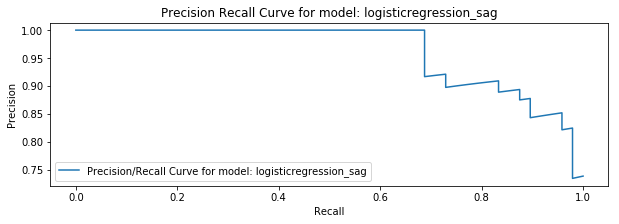

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.231065
Grid Search Best parameters  {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 6, 'decisiontreeclassifier__max_features': 'sqrt'}
Grid Search Best score  0.6766091051805337
Code block 'training' took(HH:MM:SS): 0:00:00.243886
Code block 'testing' took(HH:MM:SS): 0:00:00.000668
F1 score 0.6964572722127901
Classification report  
               precision    recall  f1-score   support

           0       0.57      0.63      0.60        27
           1       0.78      0.73      0.75        48

   micro avg       0.69      0.69      0.69        75
   macro avg       0.67      0.68      0.67        75
weighted avg       0.70      0.69      0.70        75



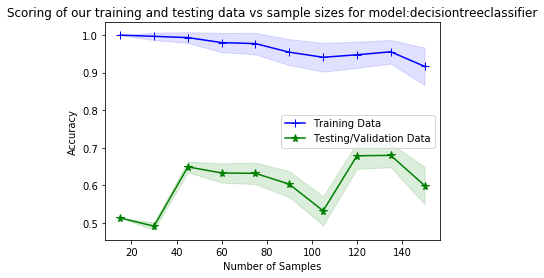

Confusion matrix, without normalization
[[17 10]
 [13 35]]


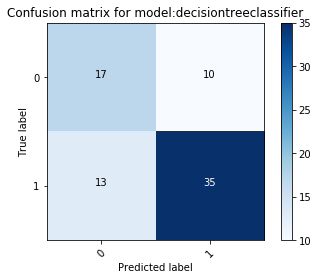

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.337353
inside decision function


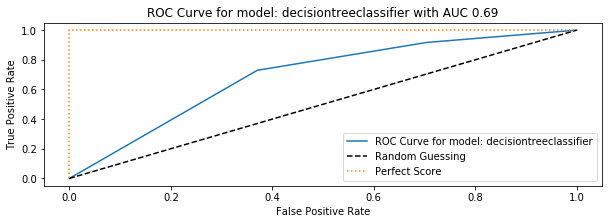

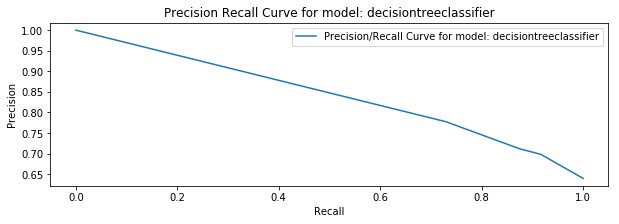

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.235337
Grid Search Best parameters  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 12}
Grid Search Best score  0.7787480376766092
Code block 'training' took(HH:MM:SS): 0:00:00.351285
Code block 'testing' took(HH:MM:SS): 0:00:00.001836
F1 score 0.7630584707646177
Classification report  
               precision    recall  f1-score   support

           0       0.65      0.74      0.69        27
           1       0.84      0.77      0.80        48

   micro avg       0.76      0.76      0.76        75
   macro avg       0.74      0.76      0.75        75
weighted avg       0.77      0.76      0.76        75



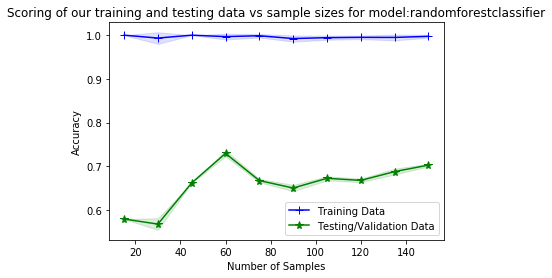

Confusion matrix, without normalization
[[20  7]
 [11 37]]


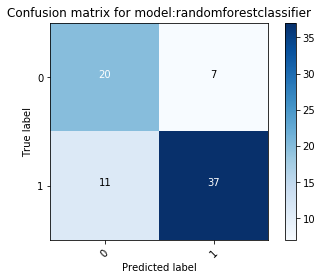

Code block 'learning_curve' took(HH:MM:SS): 0:00:01.272636
inside decision function


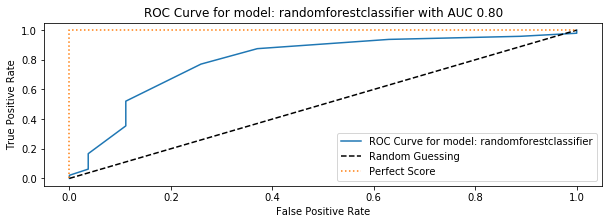

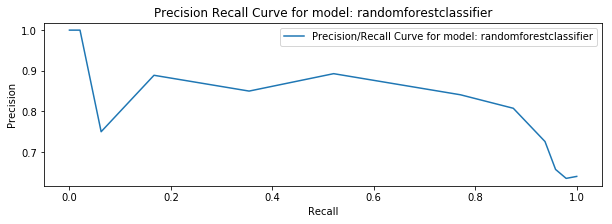

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.227084
Grid Search Best parameters  {'kneighborsclassifier__n_neighbors': 10}
Grid Search Best score  0.8810723007151579
Code block 'training' took(HH:MM:SS): 0:00:00.082624
Code block 'testing' took(HH:MM:SS): 0:00:00.002135
F1 score 0.6856241032998566
Classification report  
               precision    recall  f1-score   support

           0       0.54      0.81      0.65        27
           1       0.85      0.60      0.71        48

   micro avg       0.68      0.68      0.68        75
   macro avg       0.69      0.71      0.68        75
weighted avg       0.74      0.68      0.69        75



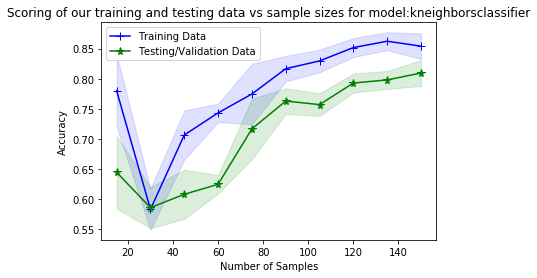

Confusion matrix, without normalization
[[22  5]
 [19 29]]


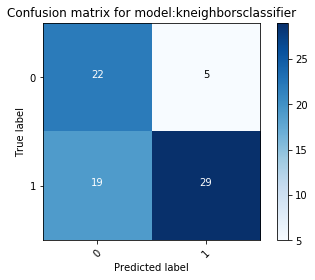

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.535896
inside decision function


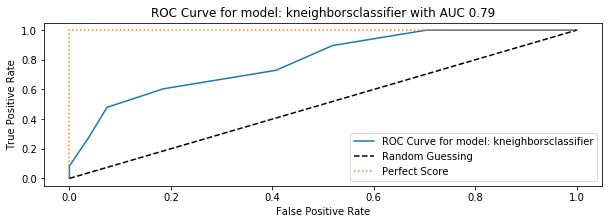

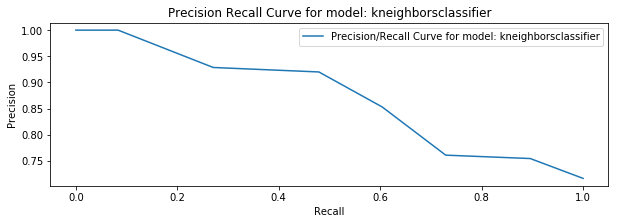

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.226061
Grid Search Best parameters  {'ridge__alpha': 1, 'ridge__max_iter': 100}
Grid Search Best score  0.9006355747427176
Code block 'training' took(HH:MM:SS): 0:00:00.162456
Code block 'testing' took(HH:MM:SS): 0:00:00.000813
F1 score 0.7384164222873901
Classification report  
               precision    recall  f1-score   support

           0       0.60      0.78      0.68        27
           1       0.85      0.71      0.77        48

   micro avg       0.73      0.73      0.73        75
   macro avg       0.72      0.74      0.73        75
weighted avg       0.76      0.73      0.74        75



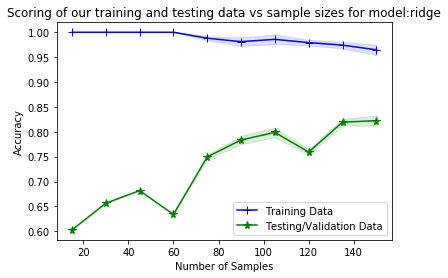

Confusion matrix, without normalization
[[21  6]
 [14 34]]


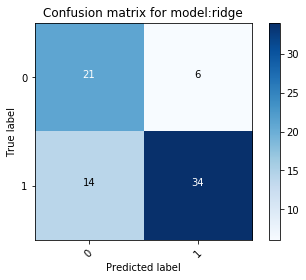

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.434196
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000014
Grid Search Best parameters  {'linear_svc__C': 0.025}
Grid Search Best score  0.9399474533403106
Code block 'training' took(HH:MM:SS): 0:00:00.029931
Code block 'testing' took(HH:MM:SS): 0:00:00.000890
F1 score 0.8292493946731235
Classification report  
               precision    recall  f1-score   support

           0       0.72      0.85      0.78        27
           1       0.91      0.81      0.86        48

   micro avg       0.83      0.83      0.83        75
   macro avg       0.81      0.83      0.82        75
weighted avg       0.84      0.83      0.83        75



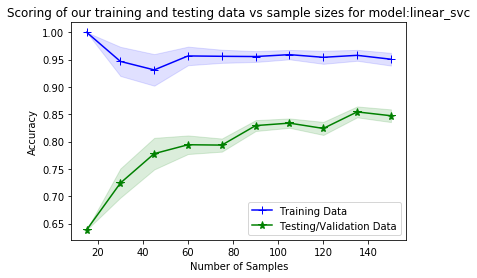

Confusion matrix, without normalization
[[23  4]
 [ 9 39]]


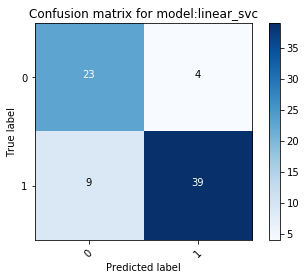

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.384872
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000018
Grid Search Best parameters  {'gamma_svc__C': 1, 'gamma_svc__gamma': 2}
Grid Search Best score  0.5
Code block 'training' took(HH:MM:SS): 0:00:00.117321
Code block 'testing' took(HH:MM:SS): 0:00:00.001843
F1 score 0.49951219512195116
Classification report  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.64      1.00      0.78        48

   micro avg       0.64      0.64      0.64        75
   macro avg       0.32      0.50      0.39        75
weighted avg       0.41      0.64      0.50        75



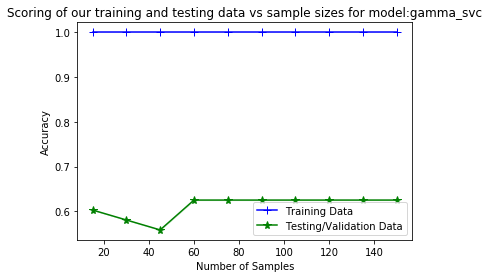

Confusion matrix, without normalization
[[ 0 27]
 [ 0 48]]


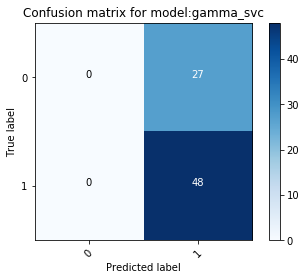

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.429617
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000023
Grid Search Best parameters  {'extra_trees__criterion': 'entropy', 'extra_trees__max_depth': 8}
Grid Search Best score  0.6298022414093842
Code block 'training' took(HH:MM:SS): 0:00:00.088231
Code block 'testing' took(HH:MM:SS): 0:00:00.000532
F1 score 0.4852971137521222
Classification report  
               precision    recall  f1-score   support

           0       0.30      0.33      0.32        27
           1       0.60      0.56      0.58        48

   micro avg       0.48      0.48      0.48        75
   macro avg       0.45      0.45      0.45        75
weighted avg       0.49      0.48      0.49        75



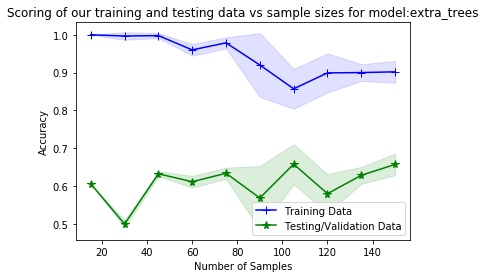

Confusion matrix, without normalization
[[ 9 18]
 [21 27]]


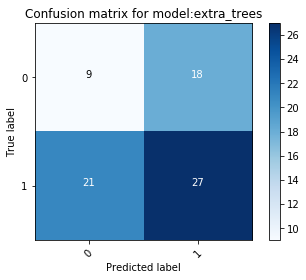

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.363004
inside decision function


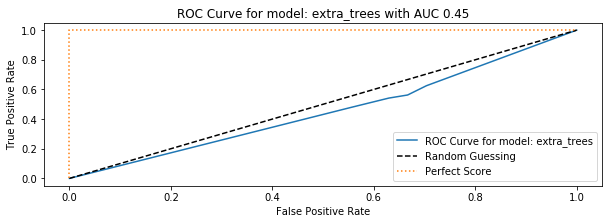

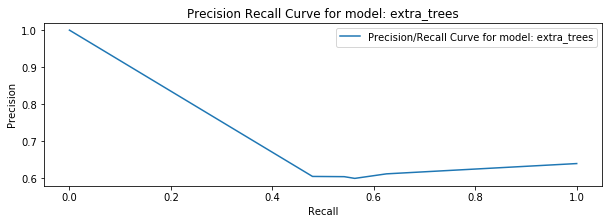

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.236684
Grid Search Best parameters  {'gaussian_process__max_iter_predict': 200}
Grid Search Best score  0.7632075266003839
Code block 'training' took(HH:MM:SS): 0:00:00.163691
Code block 'testing' took(HH:MM:SS): 0:00:00.001963
F1 score 0.7108571428571429
Classification report  
               precision    recall  f1-score   support

           0       0.56      0.89      0.69        27
           1       0.91      0.60      0.72        48

   micro avg       0.71      0.71      0.71        75
   macro avg       0.73      0.75      0.71        75
weighted avg       0.78      0.71      0.71        75



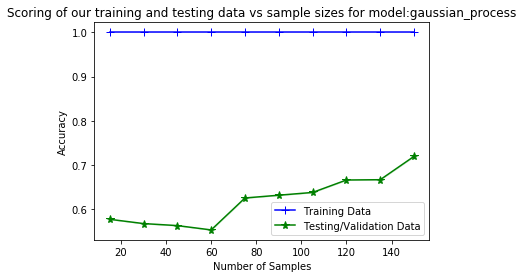

Confusion matrix, without normalization
[[24  3]
 [19 29]]


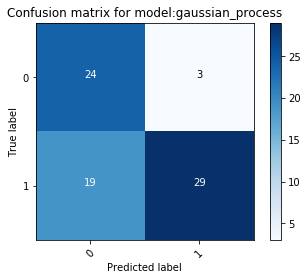

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.853863
inside decision function


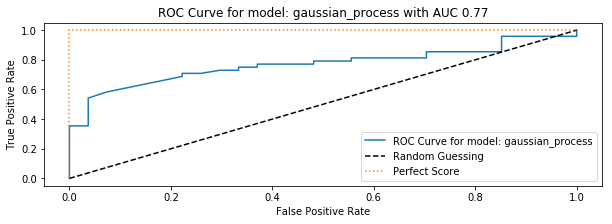

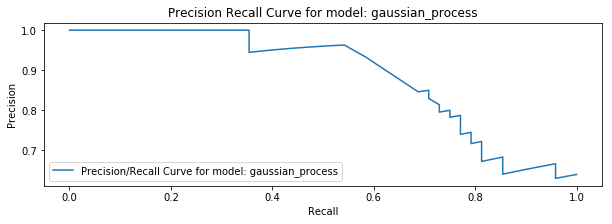

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.236251
Grid Search Best parameters  {'bernoulli__alpha': 0.2}
Grid Search Best score  0.8927263212977499
Code block 'training' took(HH:MM:SS): 0:00:00.051451
Code block 'testing' took(HH:MM:SS): 0:00:00.000847
F1 score 0.7866666666666666
Classification report  
               precision    recall  f1-score   support

           0       0.70      0.70      0.70        27
           1       0.83      0.83      0.83        48

   micro avg       0.79      0.79      0.79        75
   macro avg       0.77      0.77      0.77        75
weighted avg       0.79      0.79      0.79        75



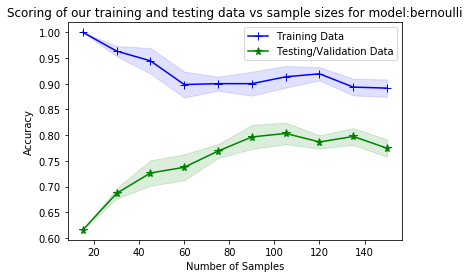

Confusion matrix, without normalization
[[19  8]
 [ 8 40]]


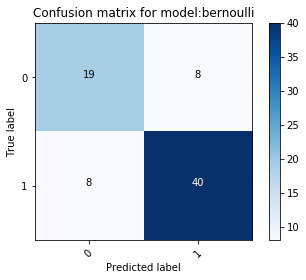

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.353134
inside decision function


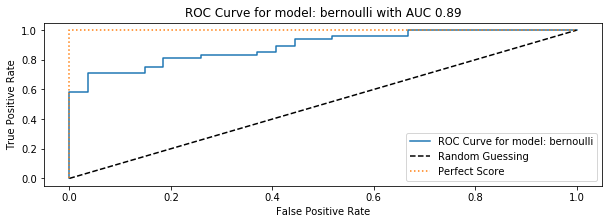

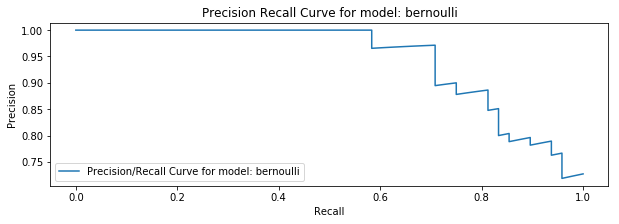

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.229229
Grid Search Best parameters  {'bagging_logistic__base_estimator__C': 4, 'bagging_logistic__base_estimator__penalty': 'l1', 'bagging_logistic__n_estimators': 5}
Grid Search Best score  0.9435777516134659
Code block 'training' took(HH:MM:SS): 0:00:01.959561
Code block 'testing' took(HH:MM:SS): 0:00:00.002192
F1 score 0.7908225108225109
Classification report  
               precision    recall  f1-score   support

           0       0.64      0.93      0.76        27
           1       0.94      0.71      0.81        48

   micro avg       0.79      0.79      0.79        75
   macro avg       0.79      0.82      0.78        75
weighted avg       0.84      0.79      0.79        75



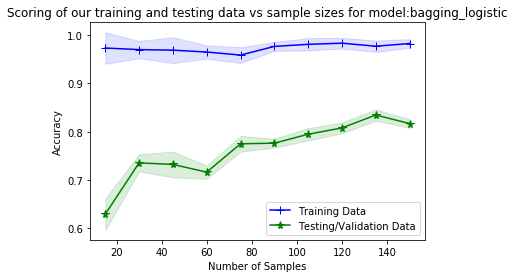

Confusion matrix, without normalization
[[25  2]
 [14 34]]


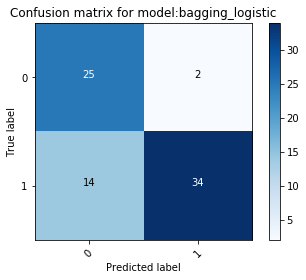

Code block 'learning_curve' took(HH:MM:SS): 0:00:01.223213
inside decision function


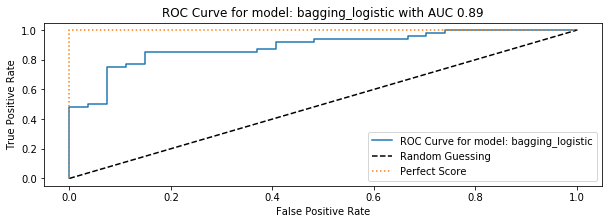

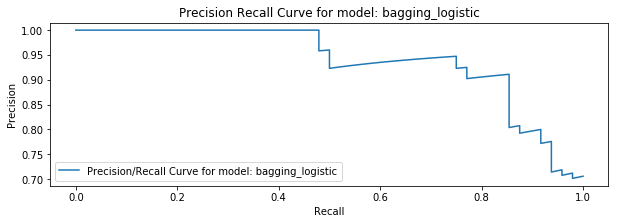

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.287207
Grid Search Best parameters  {'bagging_bernoulli__base_estimator__alpha': 4, 'bagging_bernoulli__n_estimators': 8}
Grid Search Best score  0.8864141810570383
Code block 'training' took(HH:MM:SS): 0:00:00.760231
Code block 'testing' took(HH:MM:SS): 0:00:00.003760
F1 score 0.7617325227963526
Classification report  
               precision    recall  f1-score   support

           0       0.66      0.70      0.68        27
           1       0.83      0.79      0.81        48

   micro avg       0.76      0.76      0.76        75
   macro avg       0.74      0.75      0.74        75
weighted avg       0.76      0.76      0.76        75



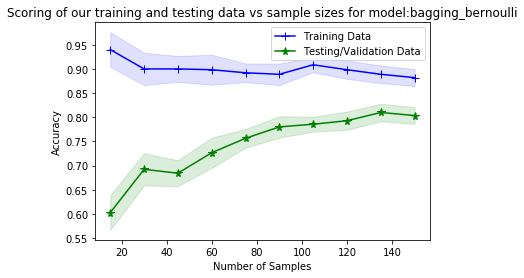

Confusion matrix, without normalization
[[19  8]
 [10 38]]


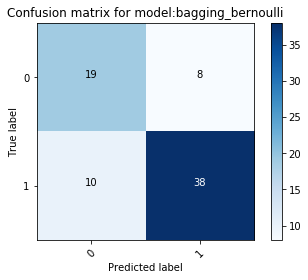

Code block 'learning_curve' took(HH:MM:SS): 0:00:01.262729
inside decision function


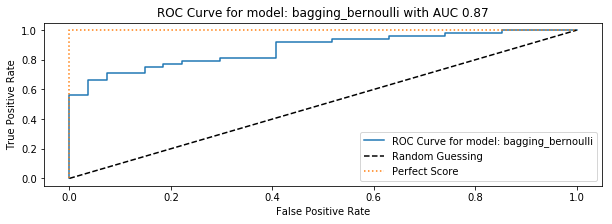

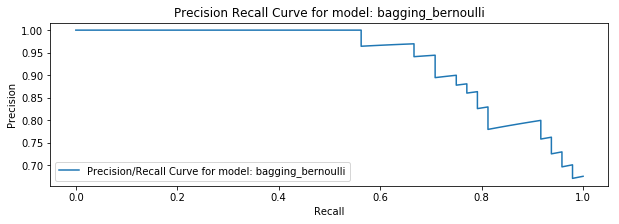

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.226565
Code block 'overalltime' took(HH:MM:SS): 0:00:17.865260
17865.259919422897


In [49]:
response1 = execute(
        _x_train_tomek,
        _y_train_tomek,
        x_test,
        y_test,
        classifiers,
        classifier_names,
        classifier_param_grid,
        cv=cv,
        score=score,
        scaler=None)

In [50]:
results = panda.DataFrame(response1).transpose()
results.head()
results[['f1_score',
         'f1_score_macro',
         'f1_score_micro',
         'learning_curve_time',
         'roc_auc_score',
         'testing_time',
         'training_time',
        ]]\
.sort_values(by=['roc_auc_score',],ascending=False)

f1_score f1_score_macro f1_score_micro  \
logisticregression_liblinear_l2  0.817064        0.80923       0.813333   
logisticregression               0.862255       0.846814       0.866667   
logisticregression_newton_cg     0.862255       0.846814       0.866667   
logisticregression_sag           0.862255       0.846814       0.866667   
bernoulli                        0.786667       0.768519       0.786667   
bagging_logistic                 0.790823        0.78355       0.786667   
bagging_bernoulli                0.761733       0.743541           0.76   
randomforestclassifier           0.763058       0.747001           0.76   
kneighborsclassifier             0.685624       0.677188           0.68   
gaussian_process                 0.710857       0.705357       0.706667   
decisiontreeclassifier           0.696457        0.67459       0.693333   
extra_trees                      0.485297       0.448217           0.48   
perceptron                       0.803941       0.794745            0.8   
ridge                            0.738416       0.725073       0.733333   
linear_svc                       0.829249       0.818402       0.826667   
gamma_svc                        0.499512       0.390244           0.64   

                                learning_curve_time roc_auc_score  \
logisticregression_liblinear_l2             339.096      0.931327   
logisticregression                          464.711      0.928241   
logisticregression_newton_cg                580.879      0.928241   
logisticregression_sag                      415.889      0.928241   
bernoulli                                   353.134      0.890432   
bagging_logistic                            1223.21      0.887346   
bagging_bernoulli                           1262.73      0.872685   
randomforestclassifier                      1272.64      0.796296   
kneighborsclassifier                        535.896      0.790895   
gaussian_process                            853.863      0.768904   
decisiontreeclassifier                      337.353      0.693287   
extra_trees                                 363.004       0.45409   
perceptron                                  350.319             0   
ridge                                       434.196             0   
linear_svc                                  384.872             0   
gamma_svc                                   429.617             0   

                                testing_time training_time  
logisticregression_liblinear_l2     0.525653       100.333  
logisticregression                  0.531911       690.797  
logisticregression_newton_cg        0.609279       187.231  
logisticregression_sag                1.2891       213.607  
bernoulli                           0.847075       51.4514  
bagging_logistic                      2.1925       1959.56  
bagging_bernoulli                    3.76035       760.231  
randomforestclassifier                1.8358       351.285  
kneighborsclassifier                 2.13504       82.6236  
gaussian_process                     1.96323       163.691  
decisiontreeclassifier              0.668444       243.886  
extra_trees                         0.531911       88.2306  
perceptron                            2.3387        46.745  
ridge                               0.812942       162.456  
linear_svc                           0.89031       29.9315  
gamma_svc                            1.84263       117.321

Grid Search Best parameters  {'perceptron__eta0': 0.1, 'perceptron__max_iter': 5}
Grid Search Best score  0.9408004842787452
Code block 'training' took(HH:MM:SS): 0:00:00.066205
Code block 'testing' took(HH:MM:SS): 0:00:00.001052
F1 score 0.8036102412967397
Classification report  
               precision    recall  f1-score   support

           0       0.68      0.85      0.75        27
           1       0.90      0.77      0.83        48

   micro avg       0.80      0.80      0.80        75
   macro avg       0.79      0.81      0.79        75
weighted avg       0.82      0.80      0.80        75



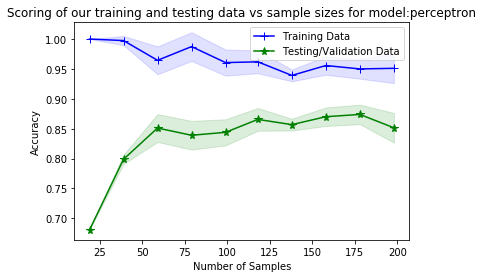

Confusion matrix, without normalization
[[23  4]
 [11 37]]


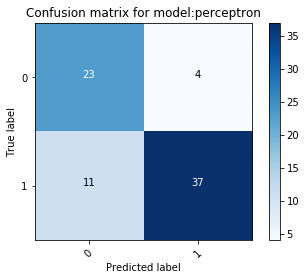

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.372662
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000026
Grid Search Best parameters  {'logisticregression__C': 0.02, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'saga'}
Grid Search Best score  0.9612220916568741
Code block 'training' took(HH:MM:SS): 0:00:01.017480
Code block 'testing' took(HH:MM:SS): 0:00:00.000527
F1 score 0.7909302325581397
Classification report  
               precision    recall  f1-score   support

           0       0.65      0.89      0.75        27
           1       0.92      0.73      0.81        48

   micro avg       0.79      0.79      0.79        75
   macro avg       0.78      0.81      0.78        75
weighted avg       0.82      0.79      0.79        75



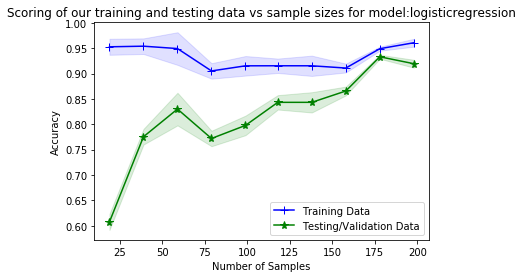

Confusion matrix, without normalization
[[24  3]
 [13 35]]


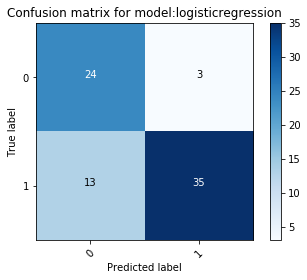

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.619247
inside decision function


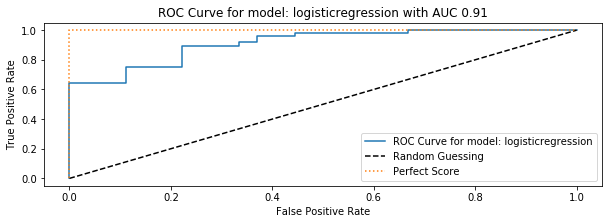

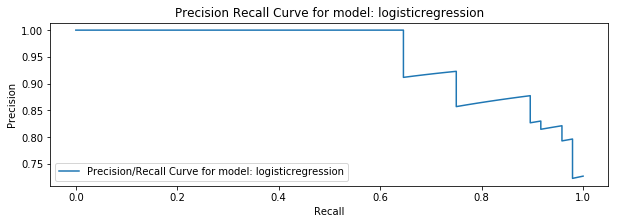

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.230542
Grid Search Best parameters  {'logisticregression_liblinear_l2__C': 0.01, 'logisticregression_liblinear_l2__dual': True, 'logisticregression_liblinear_l2__penalty': 'l2'}
Grid Search Best score  0.9604208952035038
Code block 'training' took(HH:MM:SS): 0:00:00.144210
Code block 'testing' took(HH:MM:SS): 0:00:00.000528
F1 score 0.7646753246753247
Classification report  
               precision    recall  f1-score   support

           0       0.62      0.89      0.73        27
           1       0.92      0.69      0.79        48

   micro avg       0.76      0.76      0.76        75
   macro avg       0.77      0.79      0.76        75
weighted avg       0.81      0.76      0.76        75



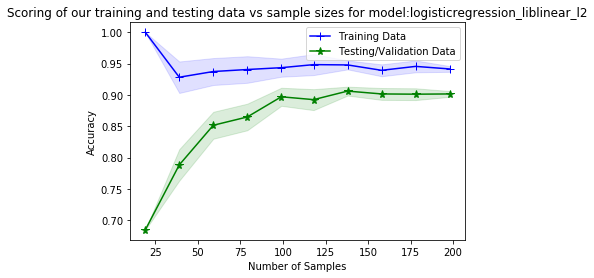

Confusion matrix, without normalization
[[24  3]
 [15 33]]


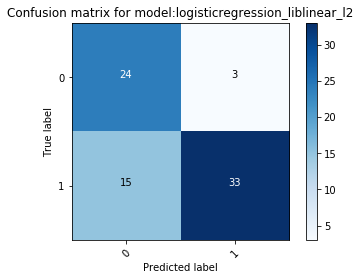

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.441892
inside decision function


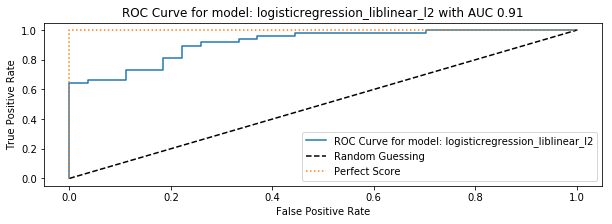

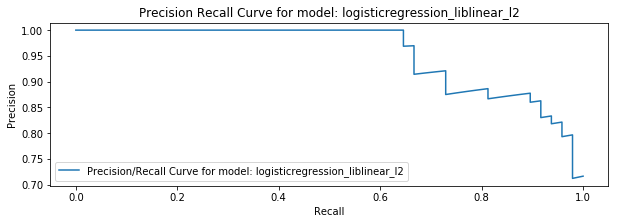

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.229414
Grid Search Best parameters  {'logisticregression_newton_cg__C': 0.02, 'logisticregression_newton_cg__penalty': 'l2'}
Grid Search Best score  0.9612220916568741
Code block 'training' took(HH:MM:SS): 0:00:00.248673
Code block 'testing' took(HH:MM:SS): 0:00:00.000539
F1 score 0.7909302325581397
Classification report  
               precision    recall  f1-score   support

           0       0.65      0.89      0.75        27
           1       0.92      0.73      0.81        48

   micro avg       0.79      0.79      0.79        75
   macro avg       0.78      0.81      0.78        75
weighted avg       0.82      0.79      0.79        75



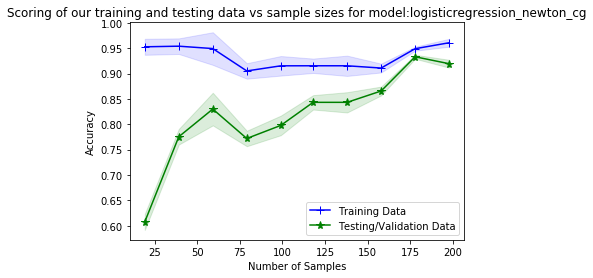

Confusion matrix, without normalization
[[24  3]
 [13 35]]


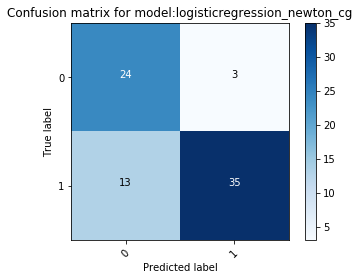

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.688089
inside decision function


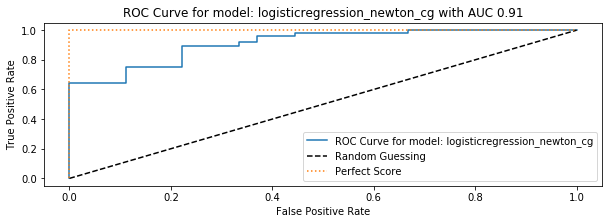

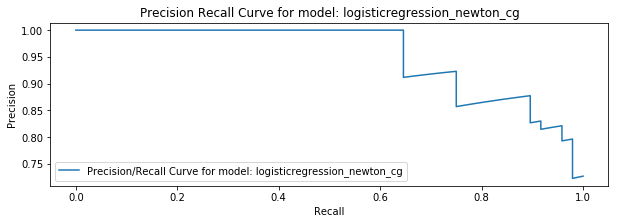

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.221220
Grid Search Best parameters  {'logisticregression_sag__C': 0.02, 'logisticregression_sag__penalty': 'l2'}
Grid Search Best score  0.9612220916568741
Code block 'training' took(HH:MM:SS): 0:00:00.279975
Code block 'testing' took(HH:MM:SS): 0:00:00.000637
F1 score 0.7909302325581397
Classification report  
               precision    recall  f1-score   support

           0       0.65      0.89      0.75        27
           1       0.92      0.73      0.81        48

   micro avg       0.79      0.79      0.79        75
   macro avg       0.78      0.81      0.78        75
weighted avg       0.82      0.79      0.79        75



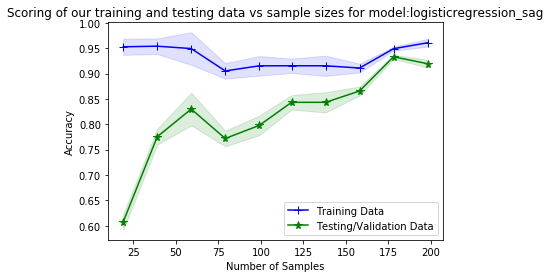

Confusion matrix, without normalization
[[24  3]
 [13 35]]


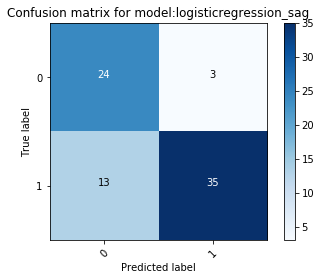

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.520140
inside decision function


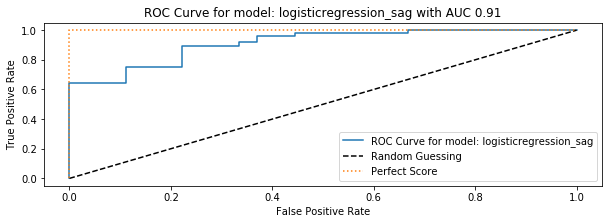

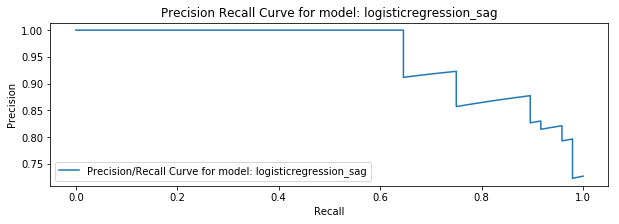

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.227203
Grid Search Best parameters  {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__max_features': 'sqrt'}
Grid Search Best score  0.7467239967239966
Code block 'training' took(HH:MM:SS): 0:00:00.259835
Code block 'testing' took(HH:MM:SS): 0:00:00.000765
F1 score 0.5787706146926537
Classification report  
               precision    recall  f1-score   support

           0       0.42      0.48      0.45        27
           1       0.68      0.62      0.65        48

   micro avg       0.57      0.57      0.57        75
   macro avg       0.55      0.55      0.55        75
weighted avg       0.59      0.57      0.58        75



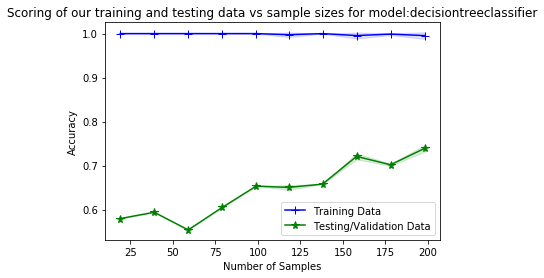

Confusion matrix, without normalization
[[13 14]
 [18 30]]


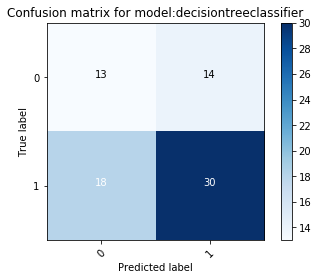

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.374575
inside decision function


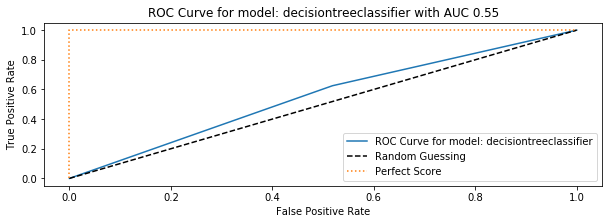

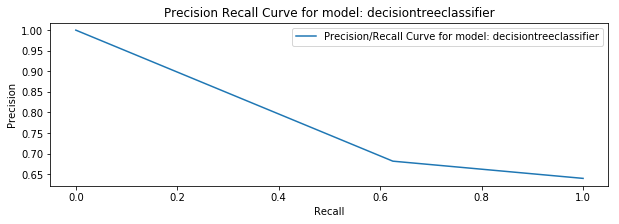

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.290338
Grid Search Best parameters  {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__n_estimators': 12}
Grid Search Best score  0.9093935833066267
Code block 'training' took(HH:MM:SS): 0:00:00.394137
Code block 'testing' took(HH:MM:SS): 0:00:00.001705
F1 score 0.6853333333333335
Classification report  
               precision    recall  f1-score   support

           0       0.55      0.67      0.60        27
           1       0.79      0.69      0.73        48

   micro avg       0.68      0.68      0.68        75
   macro avg       0.67      0.68      0.67        75
weighted avg       0.70      0.68      0.69        75



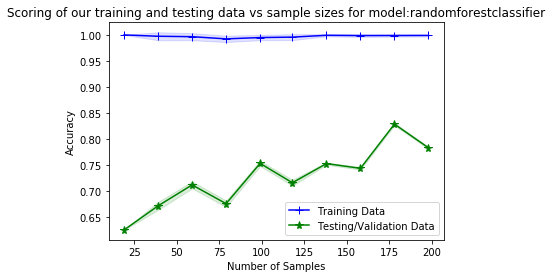

Confusion matrix, without normalization
[[18  9]
 [15 33]]


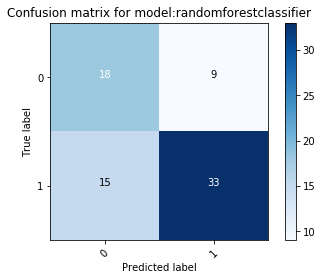

Code block 'learning_curve' took(HH:MM:SS): 0:00:01.431604
inside decision function


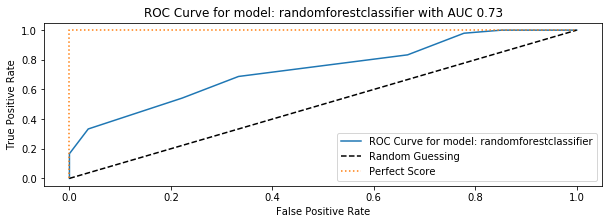

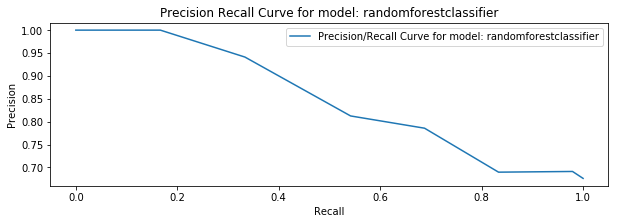

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.228766
Grid Search Best parameters  {'kneighborsclassifier__n_neighbors': 10}
Grid Search Best score  0.8268703486094791
Code block 'training' took(HH:MM:SS): 0:00:00.109576
Code block 'testing' took(HH:MM:SS): 0:00:00.002188
F1 score 0.2716577540106952
Classification report  
               precision    recall  f1-score   support

           0       0.38      1.00      0.55        27
           1       1.00      0.06      0.12        48

   micro avg       0.40      0.40      0.40        75
   macro avg       0.69      0.53      0.33        75
weighted avg       0.78      0.40      0.27        75



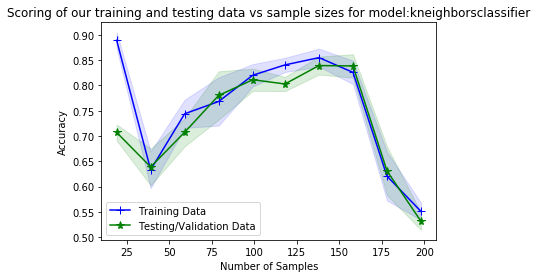

Confusion matrix, without normalization
[[27  0]
 [45  3]]


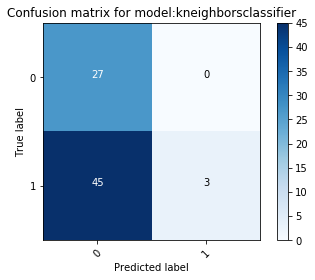

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.635540
inside decision function


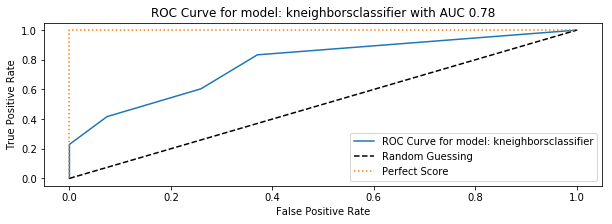

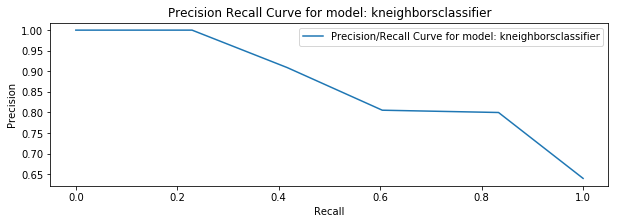

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.232962
Grid Search Best parameters  {'ridge__alpha': 1, 'ridge__max_iter': 100}
Grid Search Best score  0.9386105473061996
Code block 'training' took(HH:MM:SS): 0:00:00.149508
Code block 'testing' took(HH:MM:SS): 0:00:00.000528
F1 score 0.7255172413793103
Classification report  
               precision    recall  f1-score   support

           0       0.58      0.78      0.67        27
           1       0.85      0.69      0.76        48

   micro avg       0.72      0.72      0.72        75
   macro avg       0.71      0.73      0.71        75
weighted avg       0.75      0.72      0.73        75



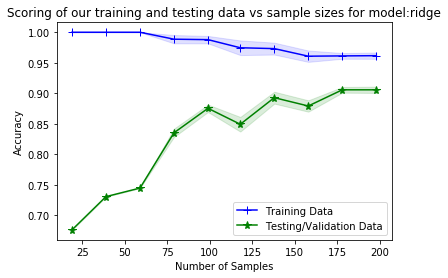

Confusion matrix, without normalization
[[21  6]
 [15 33]]


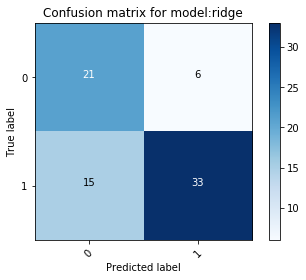

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.409622
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000015
Grid Search Best parameters  {'linear_svc__C': 0.025}
Grid Search Best score  0.948153687284122
Code block 'training' took(HH:MM:SS): 0:00:00.028917
Code block 'testing' took(HH:MM:SS): 0:00:00.001518
F1 score 0.8036102412967397
Classification report  
               precision    recall  f1-score   support

           0       0.68      0.85      0.75        27
           1       0.90      0.77      0.83        48

   micro avg       0.80      0.80      0.80        75
   macro avg       0.79      0.81      0.79        75
weighted avg       0.82      0.80      0.80        75



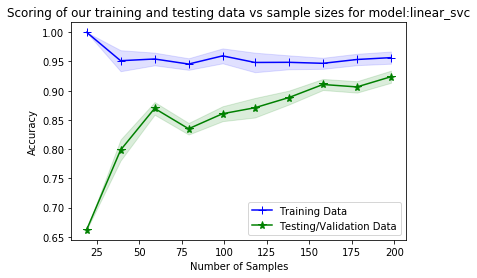

Confusion matrix, without normalization
[[23  4]
 [11 37]]


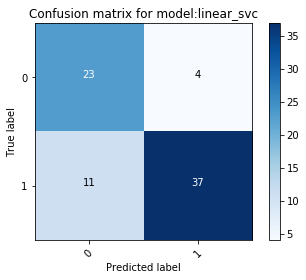

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.480879
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000017
Grid Search Best parameters  {'gamma_svc__C': 5, 'gamma_svc__gamma': 2}
Grid Search Best score  0.7837837837837838
Code block 'training' took(HH:MM:SS): 0:00:00.170634
Code block 'testing' took(HH:MM:SS): 0:00:00.001565
F1 score 0.49951219512195116
Classification report  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.64      1.00      0.78        48

   micro avg       0.64      0.64      0.64        75
   macro avg       0.32      0.50      0.39        75
weighted avg       0.41      0.64      0.50        75



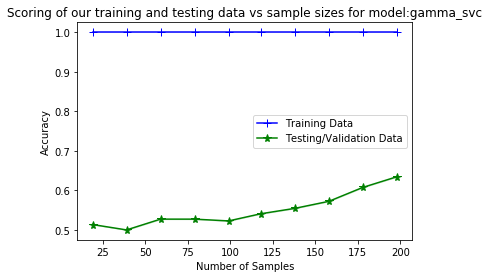

Confusion matrix, without normalization
[[ 0 27]
 [ 0 48]]


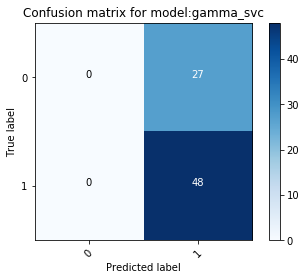

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.548711
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000015
Grid Search Best parameters  {'extra_trees__criterion': 'entropy', 'extra_trees__max_depth': 8}
Grid Search Best score  0.7299878930313713
Code block 'training' took(HH:MM:SS): 0:00:00.079467
Code block 'testing' took(HH:MM:SS): 0:00:00.000572
F1 score 0.6192
Classification report  
               precision    recall  f1-score   support

           0       0.48      0.41      0.44        27
           1       0.69      0.75      0.72        48

   micro avg       0.63      0.63      0.63        75
   macro avg       0.59      0.58      0.58        75
weighted avg       0.62      0.63      0.62        75



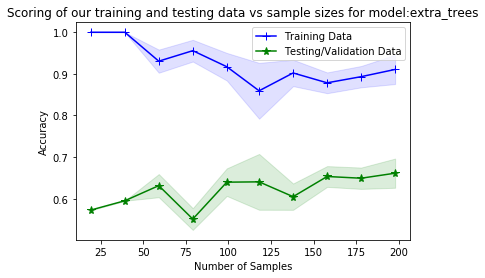

Confusion matrix, without normalization
[[11 16]
 [12 36]]


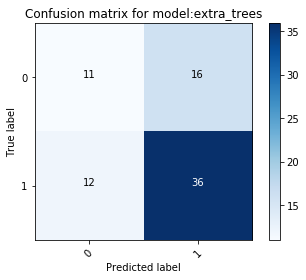

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.313401
inside decision function


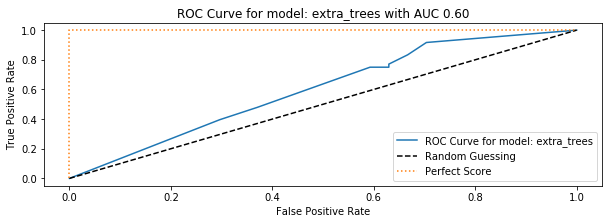

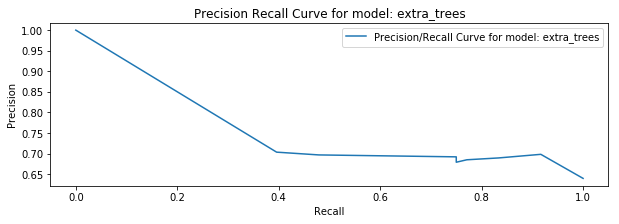

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.234135
Grid Search Best parameters  {'gaussian_process__max_iter_predict': 200}
Grid Search Best score  0.8999305629740412
Code block 'training' took(HH:MM:SS): 0:00:00.182255
Code block 'testing' took(HH:MM:SS): 0:00:00.002331
F1 score 0.5099413489736071
Classification report  
               precision    recall  f1-score   support

           0       0.44      1.00      0.61        27
           1       1.00      0.29      0.45        48

   micro avg       0.55      0.55      0.55        75
   macro avg       0.72      0.65      0.53        75
weighted avg       0.80      0.55      0.51        75



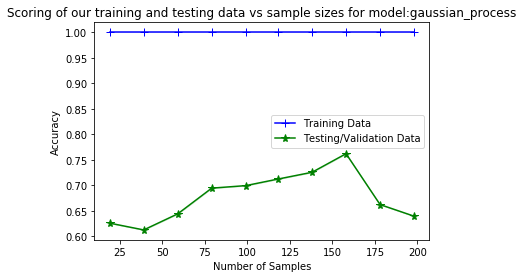

Confusion matrix, without normalization
[[27  0]
 [34 14]]


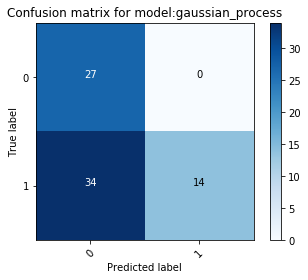

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.933830
inside decision function


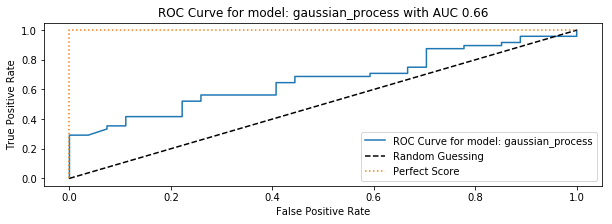

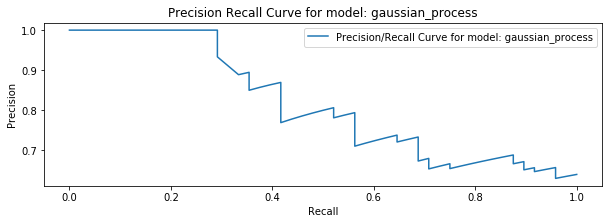

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.255822
Grid Search Best parameters  {'bernoulli__alpha': 0.2}
Grid Search Best score  0.9074172987216467
Code block 'training' took(HH:MM:SS): 0:00:00.050693
Code block 'testing' took(HH:MM:SS): 0:00:00.001073
F1 score 0.777424940136305
Classification report  
               precision    recall  f1-score   support

           0       0.65      0.81      0.72        27
           1       0.88      0.75      0.81        48

   micro avg       0.77      0.77      0.77        75
   macro avg       0.76      0.78      0.77        75
weighted avg       0.79      0.77      0.78        75



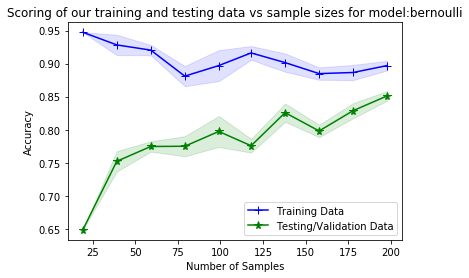

Confusion matrix, without normalization
[[22  5]
 [12 36]]


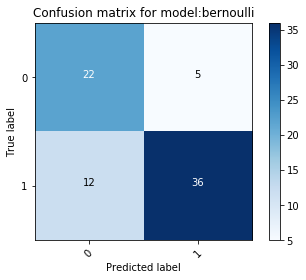

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.351431
inside decision function


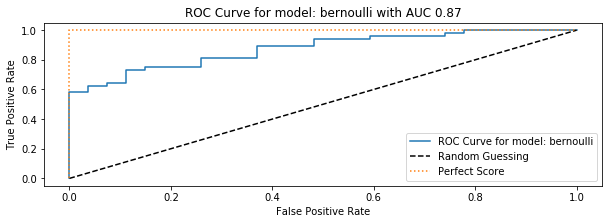

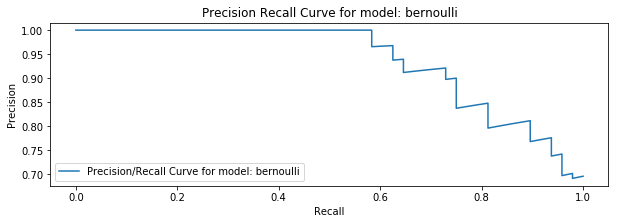

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.279065
Grid Search Best parameters  {'bagging_logistic__base_estimator__C': 1.2, 'bagging_logistic__base_estimator__penalty': 'l1', 'bagging_logistic__n_estimators': 8}
Grid Search Best score  0.9607235694192215
Code block 'training' took(HH:MM:SS): 0:00:02.206867
Code block 'testing' took(HH:MM:SS): 0:00:00.001975
F1 score 0.777846153846154
Classification report  
               precision    recall  f1-score   support

           0       0.63      0.89      0.74        27
           1       0.92      0.71      0.80        48

   micro avg       0.77      0.77      0.77        75
   macro avg       0.78      0.80      0.77        75
weighted avg       0.82      0.77      0.78        75



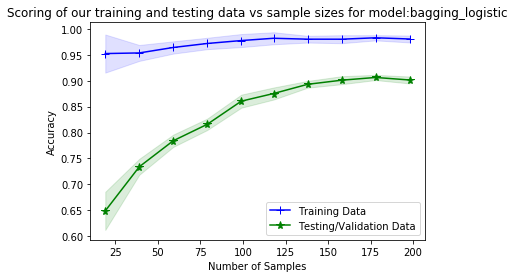

Confusion matrix, without normalization
[[24  3]
 [14 34]]


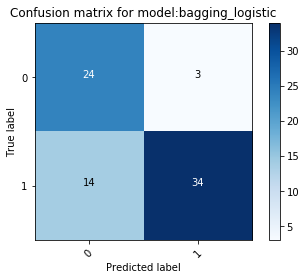

Code block 'learning_curve' took(HH:MM:SS): 0:00:01.747676
inside decision function


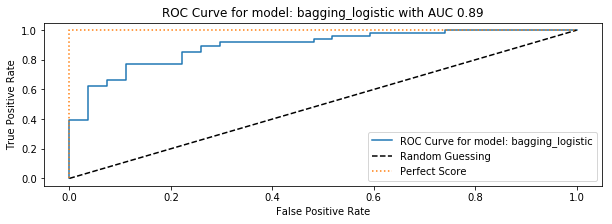

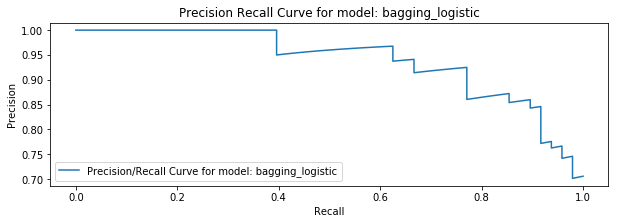

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.226725
Grid Search Best parameters  {'bagging_bernoulli__base_estimator__alpha': 2.2, 'bagging_bernoulli__n_estimators': 8}
Grid Search Best score  0.9106933019976498
Code block 'training' took(HH:MM:SS): 0:00:00.790106
Code block 'testing' took(HH:MM:SS): 0:00:00.003792
F1 score 0.7767107468802386
Classification report  
               precision    recall  f1-score   support

           0       0.66      0.78      0.71        27
           1       0.86      0.77      0.81        48

   micro avg       0.77      0.77      0.77        75
   macro avg       0.76      0.77      0.76        75
weighted avg       0.79      0.77      0.78        75



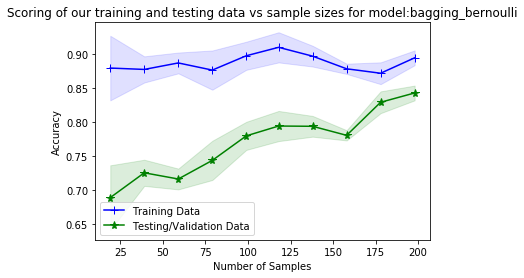

Confusion matrix, without normalization
[[21  6]
 [11 37]]


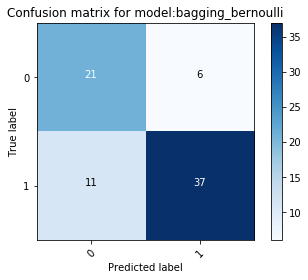

Code block 'learning_curve' took(HH:MM:SS): 0:00:01.275418
inside decision function


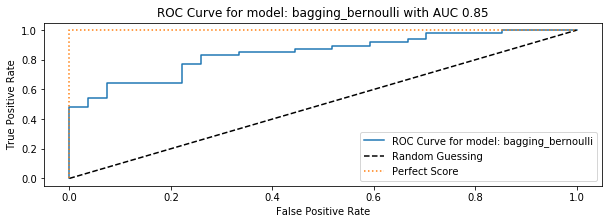

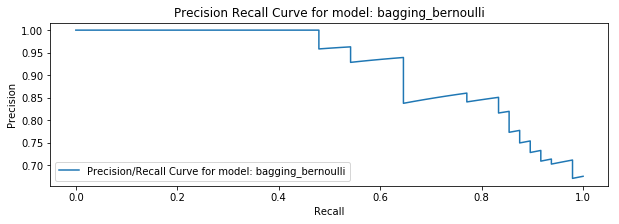

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.227269
Code block 'overalltime' took(HH:MM:SS): 0:00:20.314218
20314.217545201245


In [236]:
response = execute(
        _x_train_smt,
        _y_train_smt ,
        x_test,
        y_test,
        classifiers,
        classifier_names,
        classifier_param_grid,
        cv=cv,
        score=score,
        scaler=None)

In [237]:
results = panda.DataFrame(response).transpose()
results.head()
results[['f1_score',
         'f1_score_macro',
         'f1_score_micro',
         'learning_curve_time',
         'roc_auc_score',
         'testing_time',
         'training_time',
        ]]\
.sort_values(by=['roc_auc_score',],ascending=False)

f1_score f1_score_macro f1_score_micro  \
logisticregression_liblinear_l2  0.764675       0.756494           0.76   
logisticregression                0.79093       0.781977       0.786667   
logisticregression_newton_cg      0.79093       0.781977       0.786667   
logisticregression_sag            0.79093       0.781977       0.786667   
bagging_logistic                 0.777846       0.769231       0.773333   
bernoulli                        0.777425        0.76515       0.773333   
bagging_bernoulli                0.776711       0.762526       0.773333   
kneighborsclassifier             0.271658       0.331551            0.4   
randomforestclassifier           0.685333       0.666667           0.68   
gaussian_process                 0.509941       0.532625       0.546667   
extra_trees                        0.6192           0.58       0.626667   
decisiontreeclassifier           0.578771       0.550225       0.573333   
perceptron                        0.80361        0.79278            0.8   
ridge                            0.725517       0.712644           0.72   
linear_svc                        0.80361        0.79278            0.8   
gamma_svc                        0.499512       0.390244           0.64   

                                learning_curve_time roc_auc_score  \
logisticregression_liblinear_l2             441.892      0.914352   
logisticregression                          619.247      0.910494   
logisticregression_newton_cg                688.089      0.910494   
logisticregression_sag                       520.14      0.910494   
bagging_logistic                            1747.68      0.892747   
bernoulli                                   351.431      0.873457   
bagging_bernoulli                           1275.42      0.845679   
kneighborsclassifier                         635.54      0.775463   
randomforestclassifier                       1431.6      0.734182   
gaussian_process                             933.83      0.662037   
extra_trees                                 313.401      0.601466   
decisiontreeclassifier                      374.575      0.553241   
perceptron                                  372.662             0   
ridge                                       409.622             0   
linear_svc                                  480.879             0   
gamma_svc                                   548.711             0   

                                testing_time training_time  
logisticregression_liblinear_l2     0.528497        144.21  
logisticregression                  0.526791       1017.48  
logisticregression_newton_cg        0.539306       248.673  
logisticregression_sag              0.636586       279.975  
bagging_logistic                     1.97461       2206.87  
bernoulli                            1.07349       50.6925  
bagging_bernoulli                    3.79164       790.106  
kneighborsclassifier                 2.18794       109.576  
randomforestclassifier               1.70496       394.137  
gaussian_process                     2.33074       182.255  
extra_trees                         0.571733       79.4675  
decisiontreeclassifier              0.764586       259.835  
perceptron                           1.05244        66.205  
ridge                               0.528497       149.508  
linear_svc                           1.51779       28.9166  
gamma_svc                            1.56501       170.634

Grid Search Best parameters  {'perceptron__eta0': 0.1, 'perceptron__max_iter': 30}
Grid Search Best score  0.9467108977978543
Code block 'training' took(HH:MM:SS): 0:00:00.070187
Code block 'testing' took(HH:MM:SS): 0:00:00.000931
F1 score 0.7907331378299121
Classification report  
               precision    recall  f1-score   support

           0       0.66      0.85      0.74        27
           1       0.90      0.75      0.82        48

   micro avg       0.79      0.79      0.79        75
   macro avg       0.78      0.80      0.78        75
weighted avg       0.81      0.79      0.79        75



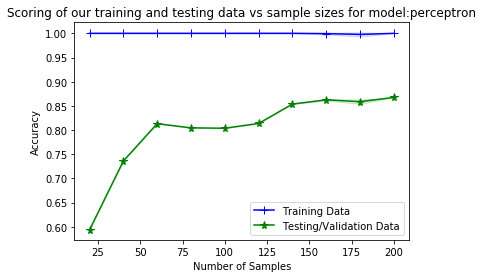

Confusion matrix, without normalization
[[23  4]
 [12 36]]


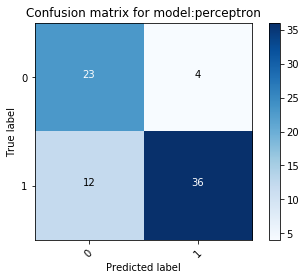

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.473008
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000017
Grid Search Best parameters  {'logisticregression__C': 0.05, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'saga'}
Grid Search Best score  0.9640563241106719
Code block 'training' took(HH:MM:SS): 0:00:01.117681
Code block 'testing' took(HH:MM:SS): 0:00:00.000882
F1 score 0.777799671592775
Classification report  
               precision    recall  f1-score   support

           0       0.64      0.85      0.73        27
           1       0.90      0.73      0.80        48

   micro avg       0.77      0.77      0.77        75
   macro avg       0.77      0.79      0.77        75
weighted avg       0.80      0.77      0.78        75



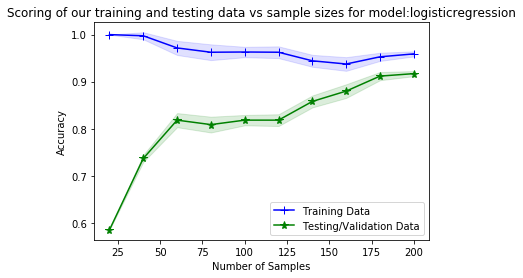

Confusion matrix, without normalization
[[23  4]
 [13 35]]


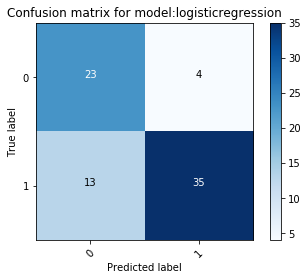

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.743265
inside decision function


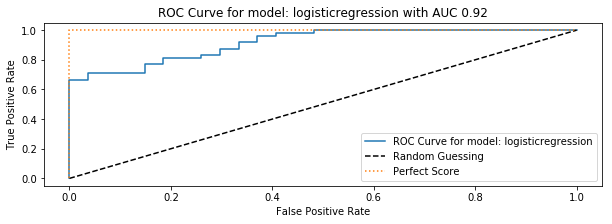

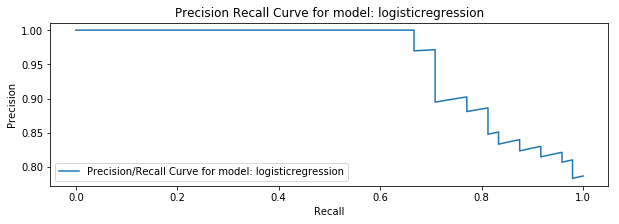

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.224572
Grid Search Best parameters  {'logisticregression_liblinear_l2__C': 0.05, 'logisticregression_liblinear_l2__dual': True, 'logisticregression_liblinear_l2__penalty': 'l2'}
Grid Search Best score  0.9636328345567478
Code block 'training' took(HH:MM:SS): 0:00:00.143799
Code block 'testing' took(HH:MM:SS): 0:00:00.000539
F1 score 0.7908225108225109
Classification report  
               precision    recall  f1-score   support

           0       0.64      0.93      0.76        27
           1       0.94      0.71      0.81        48

   micro avg       0.79      0.79      0.79        75
   macro avg       0.79      0.82      0.78        75
weighted avg       0.84      0.79      0.79        75



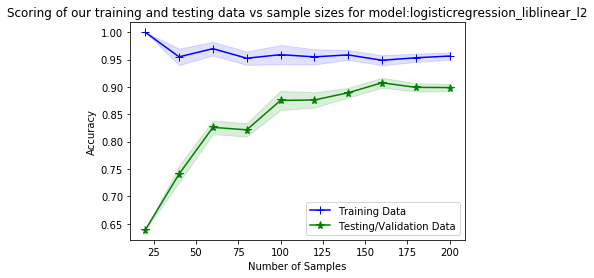

Confusion matrix, without normalization
[[25  2]
 [14 34]]


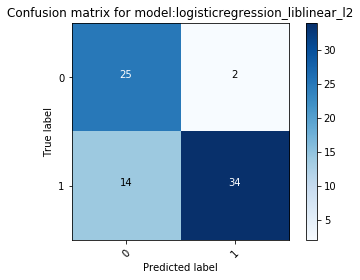

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.394083
inside decision function


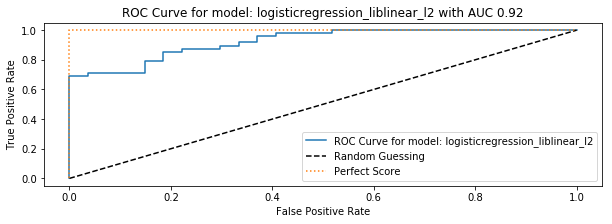

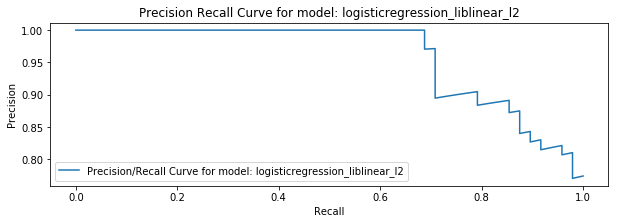

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.231411
Grid Search Best parameters  {'logisticregression_newton_cg__C': 0.05, 'logisticregression_newton_cg__penalty': 'l2'}
Grid Search Best score  0.9640563241106719
Code block 'training' took(HH:MM:SS): 0:00:00.271543
Code block 'testing' took(HH:MM:SS): 0:00:00.000531
F1 score 0.777799671592775
Classification report  
               precision    recall  f1-score   support

           0       0.64      0.85      0.73        27
           1       0.90      0.73      0.80        48

   micro avg       0.77      0.77      0.77        75
   macro avg       0.77      0.79      0.77        75
weighted avg       0.80      0.77      0.78        75



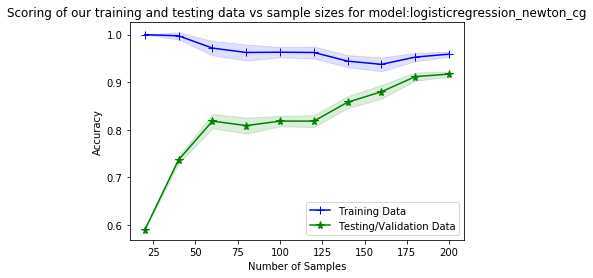

Confusion matrix, without normalization
[[23  4]
 [13 35]]


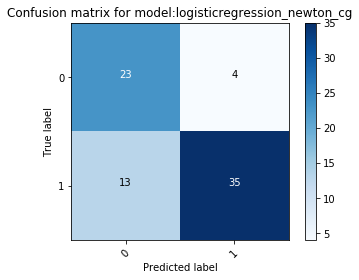

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.775096
inside decision function


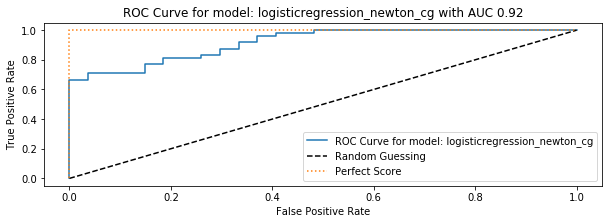

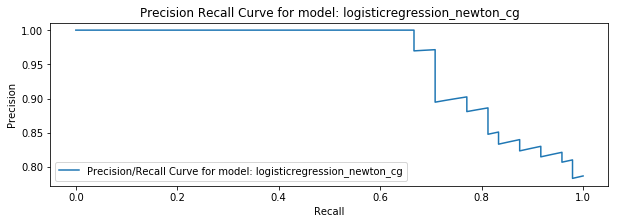

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.238225
Grid Search Best parameters  {'logisticregression_sag__C': 0.05, 'logisticregression_sag__penalty': 'l2'}
Grid Search Best score  0.9640563241106719
Code block 'training' took(HH:MM:SS): 0:00:00.353607
Code block 'testing' took(HH:MM:SS): 0:00:00.000534
F1 score 0.777799671592775
Classification report  
               precision    recall  f1-score   support

           0       0.64      0.85      0.73        27
           1       0.90      0.73      0.80        48

   micro avg       0.77      0.77      0.77        75
   macro avg       0.77      0.79      0.77        75
weighted avg       0.80      0.77      0.78        75



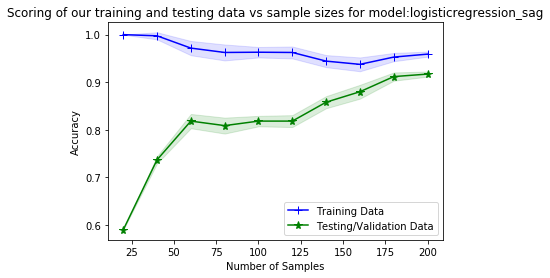

Confusion matrix, without normalization
[[23  4]
 [13 35]]


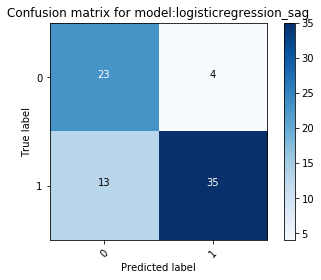

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.546718
inside decision function


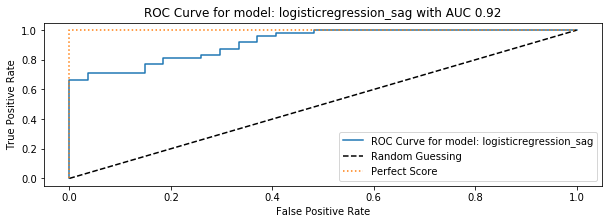

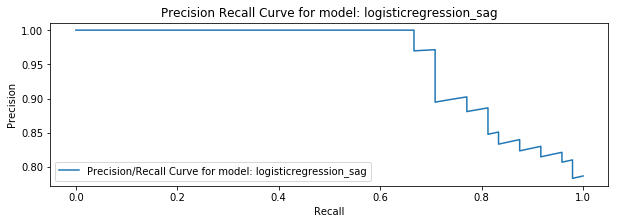

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.287652
Grid Search Best parameters  {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 8, 'decisiontreeclassifier__max_features': 'auto'}
Grid Search Best score  0.7846555618294749
Code block 'training' took(HH:MM:SS): 0:00:00.281221
Code block 'testing' took(HH:MM:SS): 0:00:00.000559
F1 score 0.5557267441860464
Classification report  
               precision    recall  f1-score   support

           0       0.41      0.56      0.47        27
           1       0.68      0.54      0.60        48

   micro avg       0.55      0.55      0.55        75
   macro avg       0.54      0.55      0.54        75
weighted avg       0.58      0.55      0.56        75



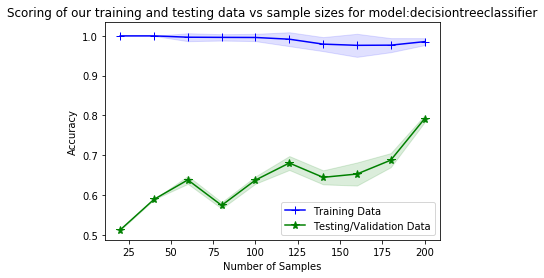

Confusion matrix, without normalization
[[15 12]
 [22 26]]


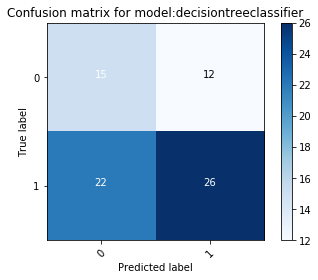

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.364439
inside decision function


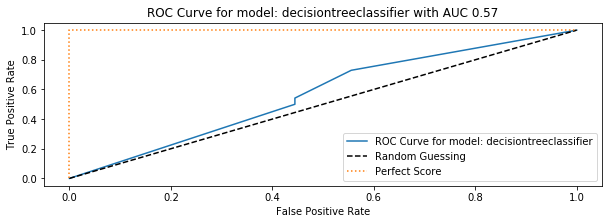

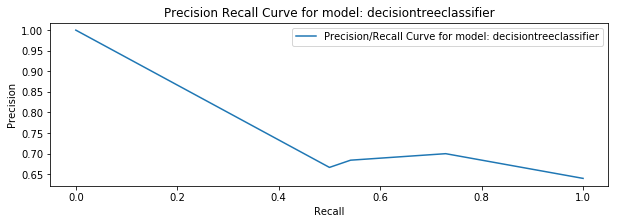

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.231845
Grid Search Best parameters  {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__n_estimators': 12}
Grid Search Best score  0.930777103331451
Code block 'training' took(HH:MM:SS): 0:00:00.380606
Code block 'testing' took(HH:MM:SS): 0:00:00.001797
F1 score 0.5943966912425823
Classification report  
               precision    recall  f1-score   support

           0       0.45      0.67      0.54        27
           1       0.74      0.54      0.63        48

   micro avg       0.59      0.59      0.59        75
   macro avg       0.60      0.60      0.58        75
weighted avg       0.64      0.59      0.59        75



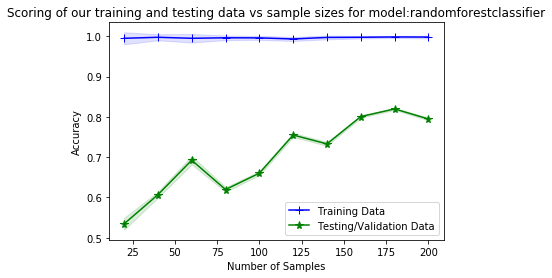

Confusion matrix, without normalization
[[18  9]
 [22 26]]


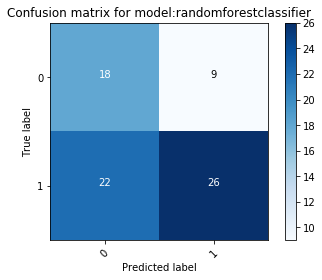

Code block 'learning_curve' took(HH:MM:SS): 0:00:01.426207
inside decision function


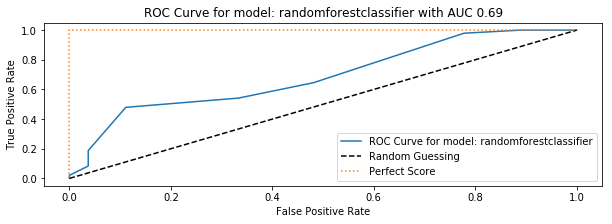

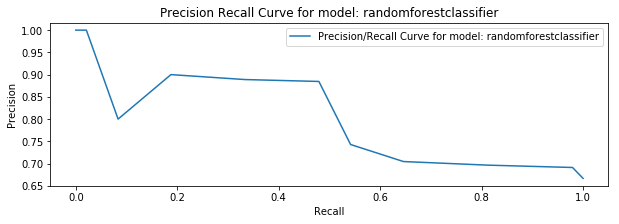

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.233390
Grid Search Best parameters  {'kneighborsclassifier__n_neighbors': 10}
Grid Search Best score  0.8572928430265386
Code block 'training' took(HH:MM:SS): 0:00:00.100963
Code block 'testing' took(HH:MM:SS): 0:00:00.002321
F1 score 0.2185976965043443
Classification report  
               precision    recall  f1-score   support

           0       0.36      1.00      0.53        27
           1       1.00      0.02      0.04        48

   micro avg       0.37      0.37      0.37        75
   macro avg       0.68      0.51      0.29        75
weighted avg       0.77      0.37      0.22        75



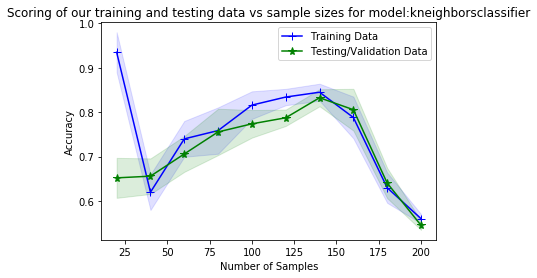

Confusion matrix, without normalization
[[27  0]
 [47  1]]


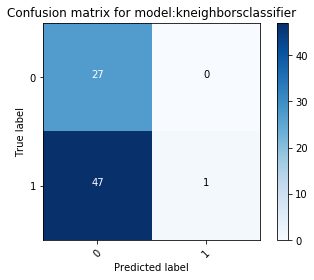

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.612953
inside decision function


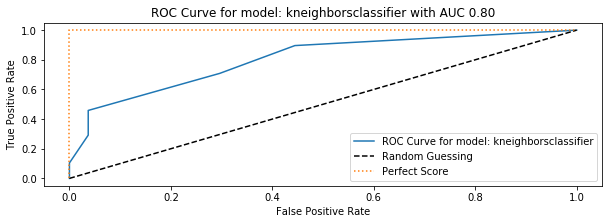

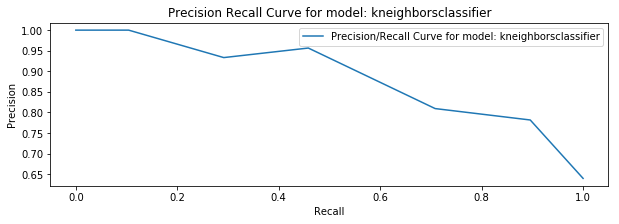

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.228665
Grid Search Best parameters  {'ridge__alpha': 1, 'ridge__max_iter': 100}
Grid Search Best score  0.9395468661773011
Code block 'training' took(HH:MM:SS): 0:00:00.148748
Code block 'testing' took(HH:MM:SS): 0:00:00.000522
F1 score 0.7125290697674419
Classification report  
               precision    recall  f1-score   support

           0       0.57      0.78      0.66        27
           1       0.84      0.67      0.74        48

   micro avg       0.71      0.71      0.71        75
   macro avg       0.70      0.72      0.70        75
weighted avg       0.74      0.71      0.71        75



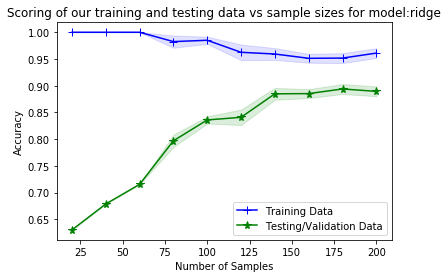

Confusion matrix, without normalization
[[21  6]
 [16 32]]


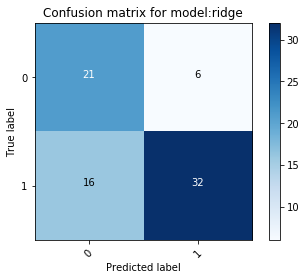

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.471182
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000015
Grid Search Best parameters  {'linear_svc__C': 0.025}
Grid Search Best score  0.9566981931112367
Code block 'training' took(HH:MM:SS): 0:00:00.029646
Code block 'testing' took(HH:MM:SS): 0:00:00.002878
F1 score 0.7516584564860426
Classification report  
               precision    recall  f1-score   support

           0       0.61      0.81      0.70        27
           1       0.87      0.71      0.78        48

   micro avg       0.75      0.75      0.75        75
   macro avg       0.74      0.76      0.74        75
weighted avg       0.78      0.75      0.75        75



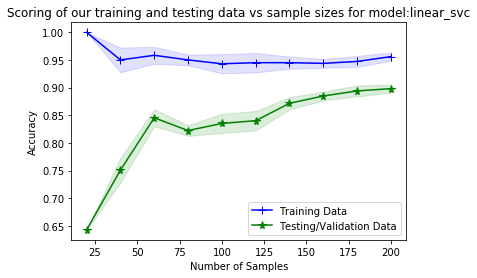

Confusion matrix, without normalization
[[22  5]
 [14 34]]


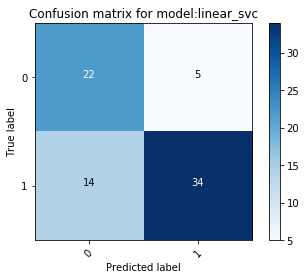

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.430422
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000018
Grid Search Best parameters  {'gamma_svc__C': 1, 'gamma_svc__gamma': 2}
Grid Search Best score  0.8526785714285714
Code block 'training' took(HH:MM:SS): 0:00:00.169153
Code block 'testing' took(HH:MM:SS): 0:00:00.001584
F1 score 0.49951219512195116
Classification report  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.64      1.00      0.78        48

   micro avg       0.64      0.64      0.64        75
   macro avg       0.32      0.50      0.39        75
weighted avg       0.41      0.64      0.50        75



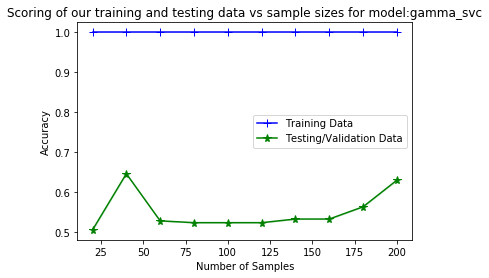

Confusion matrix, without normalization
[[ 0 27]
 [ 0 48]]


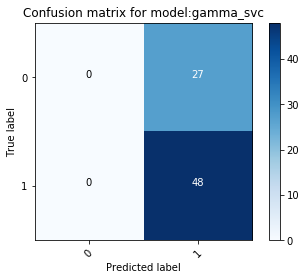

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.556877
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000020
Grid Search Best parameters  {'extra_trees__criterion': 'entropy', 'extra_trees__max_depth': 12}
Grid Search Best score  0.7918195934500282
Code block 'training' took(HH:MM:SS): 0:00:00.117134
Code block 'testing' took(HH:MM:SS): 0:00:00.000577
F1 score 0.5928254796051406
Classification report  
               precision    recall  f1-score   support

           0       0.44      0.52      0.47        27
           1       0.70      0.62      0.66        48

   micro avg       0.59      0.59      0.59        75
   macro avg       0.57      0.57      0.57        75
weighted avg       0.60      0.59      0.59        75



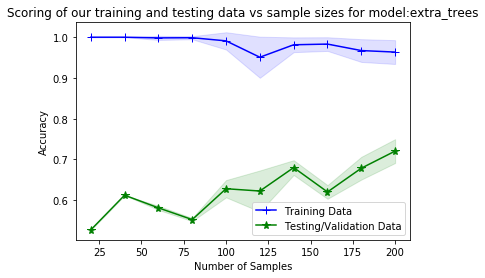

Confusion matrix, without normalization
[[14 13]
 [18 30]]


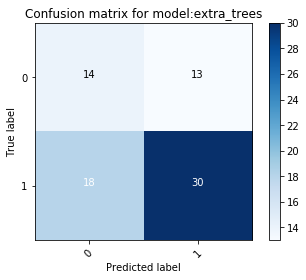

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.332062
inside decision function


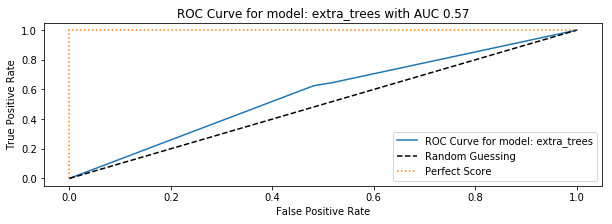

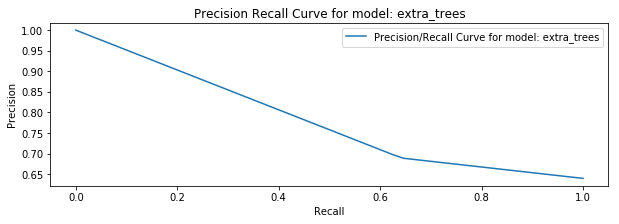

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.202227
Grid Search Best parameters  {'gaussian_process__max_iter_predict': 200}
Grid Search Best score  0.9201545736871823
Code block 'training' took(HH:MM:SS): 0:00:00.185180
Code block 'testing' took(HH:MM:SS): 0:00:00.002339
F1 score 0.5099413489736071
Classification report  
               precision    recall  f1-score   support

           0       0.44      1.00      0.61        27
           1       1.00      0.29      0.45        48

   micro avg       0.55      0.55      0.55        75
   macro avg       0.72      0.65      0.53        75
weighted avg       0.80      0.55      0.51        75



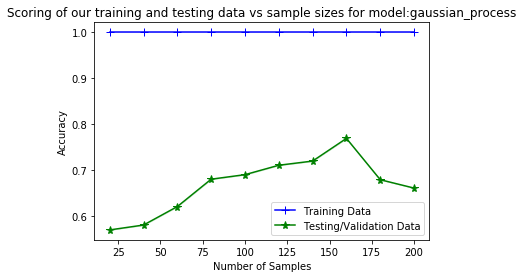

Confusion matrix, without normalization
[[27  0]
 [34 14]]


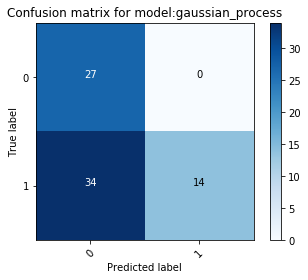

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.978953
inside decision function


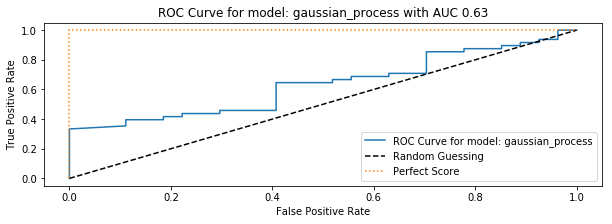

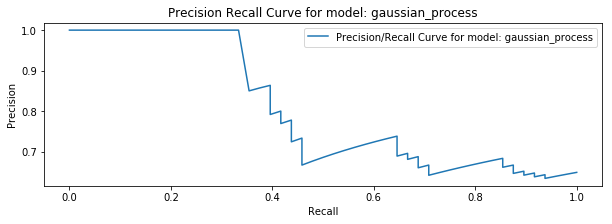

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.242558
Grid Search Best parameters  {'bernoulli__alpha': 0.2}
Grid Search Best score  0.9194840485601355
Code block 'training' took(HH:MM:SS): 0:00:00.049944
Code block 'testing' took(HH:MM:SS): 0:00:00.001050
F1 score 0.8029800707766809
Classification report  
               precision    recall  f1-score   support

           0       0.69      0.81      0.75        27
           1       0.88      0.79      0.84        48

   micro avg       0.80      0.80      0.80        75
   macro avg       0.79      0.80      0.79        75
weighted avg       0.81      0.80      0.80        75



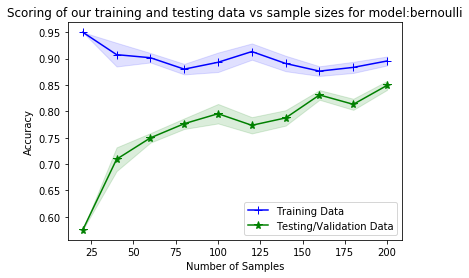

Confusion matrix, without normalization
[[22  5]
 [10 38]]


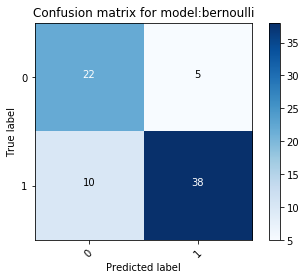

Code block 'learning_curve' took(HH:MM:SS): 0:00:00.409780
inside decision function


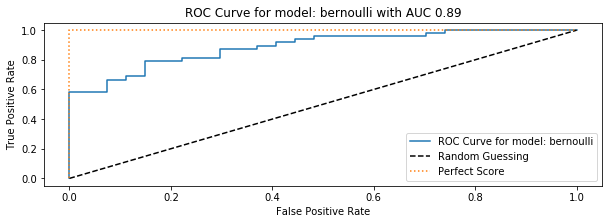

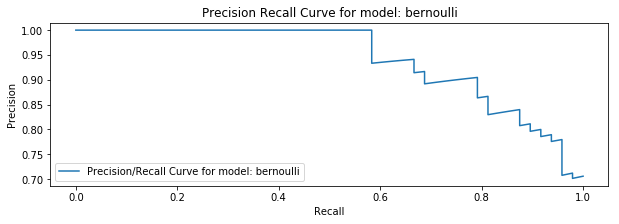

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.219854
Grid Search Best parameters  {'bagging_logistic__base_estimator__C': 4, 'bagging_logistic__base_estimator__penalty': 'l1', 'bagging_logistic__n_estimators': 10}
Grid Search Best score  0.9679030208921512
Code block 'training' took(HH:MM:SS): 0:00:02.267450
Code block 'testing' took(HH:MM:SS): 0:00:00.002578
F1 score 0.8037403344722172
Classification report  
               precision    recall  f1-score   support

           0       0.65      0.96      0.78        27
           1       0.97      0.71      0.82        48

   micro avg       0.80      0.80      0.80        75
   macro avg       0.81      0.84      0.80        75
weighted avg       0.86      0.80      0.80        75



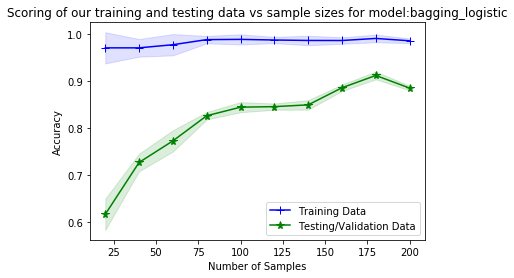

Confusion matrix, without normalization
[[26  1]
 [14 34]]


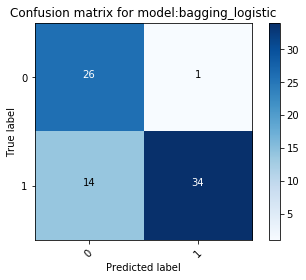

Code block 'learning_curve' took(HH:MM:SS): 0:00:02.401266
inside decision function


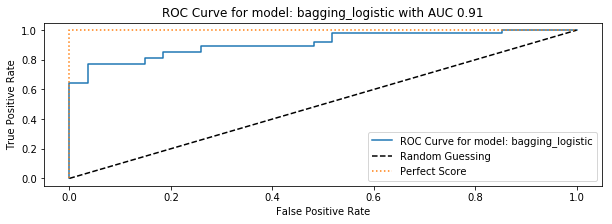

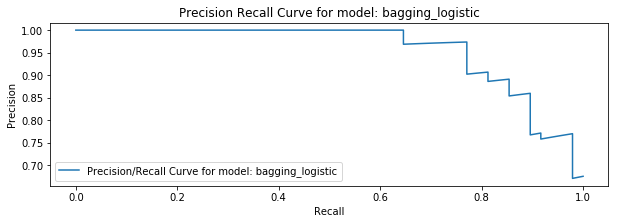

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.228930
Grid Search Best parameters  {'bagging_bernoulli__base_estimator__alpha': 1.2, 'bagging_bernoulli__n_estimators': 10}
Grid Search Best score  0.9228719649915301
Code block 'training' took(HH:MM:SS): 0:00:00.793850
Code block 'testing' took(HH:MM:SS): 0:00:00.003939
F1 score 0.7617325227963526
Classification report  
               precision    recall  f1-score   support

           0       0.66      0.70      0.68        27
           1       0.83      0.79      0.81        48

   micro avg       0.76      0.76      0.76        75
   macro avg       0.74      0.75      0.74        75
weighted avg       0.76      0.76      0.76        75



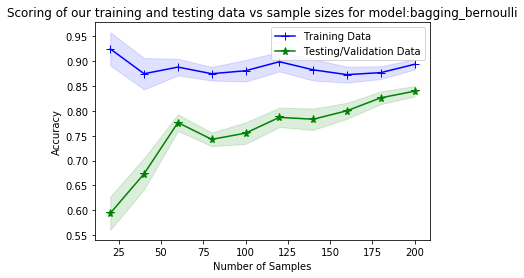

Confusion matrix, without normalization
[[19  8]
 [10 38]]


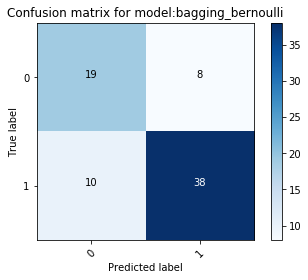

Code block 'learning_curve' took(HH:MM:SS): 0:00:01.511805
inside decision function


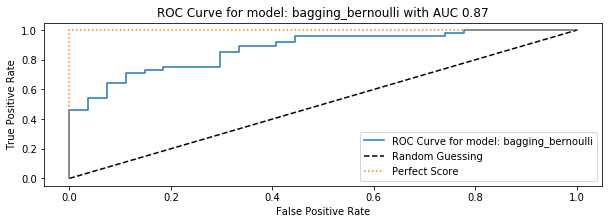

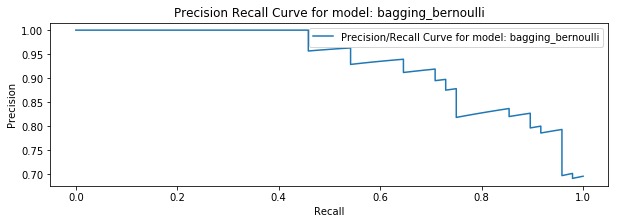

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.226316
Code block 'overalltime' took(HH:MM:SS): 0:00:21.823471
21823.471083971526


In [238]:
response2 = execute(
        x_train_smote,
        y_train_smote ,
        x_test,
        y_test,
        classifiers,
        classifier_names,
        classifier_param_grid,
        cv=cv,
        score=score,
        scaler=None)

In [239]:
results = panda.DataFrame(response2).transpose()
results.head()
results[['f1_score',
         'f1_score_macro',
         'f1_score_micro',
         'learning_curve_time',
         'roc_auc_score',
         'testing_time',
         'training_time',
        ]]\
.sort_values(by=['roc_auc_score',],ascending=False)

f1_score f1_score_macro f1_score_micro  \
logisticregression_liblinear_l2  0.790823        0.78355       0.786667   
logisticregression                 0.7778       0.767378       0.773333   
logisticregression_newton_cg       0.7778       0.767378       0.773333   
logisticregression_sag             0.7778       0.767378       0.773333   
bagging_logistic                  0.80374       0.797698            0.8   
bernoulli                         0.80298       0.790464            0.8   
bagging_bernoulli                0.761733       0.743541           0.76   
kneighborsclassifier             0.218598       0.287735       0.373333   
randomforestclassifier           0.594397        0.58191       0.586667   
gaussian_process                 0.509941       0.532625       0.546667   
extra_trees                      0.592825       0.566958       0.586667   
decisiontreeclassifier           0.555727       0.536701       0.546667   
perceptron                       0.790733       0.780059       0.786667   
ridge                            0.712529       0.700218       0.706667   
linear_svc                       0.751658       0.740011       0.746667   
gamma_svc                        0.499512       0.390244           0.64   

                                learning_curve_time roc_auc_score  \
logisticregression_liblinear_l2             394.083       0.92284   
logisticregression                          743.265      0.915895   
logisticregression_newton_cg                775.096      0.915895   
logisticregression_sag                      546.718      0.915895   
bagging_logistic                            2401.27      0.910494   
bernoulli                                    409.78      0.887346   
bagging_bernoulli                           1511.81      0.871914   
kneighborsclassifier                        612.953      0.804012   
randomforestclassifier                      1426.21      0.689815   
gaussian_process                            978.953      0.633102   
extra_trees                                 332.062      0.570216   
decisiontreeclassifier                      364.439      0.565972   
perceptron                                  473.008             0   
ridge                                       471.182             0   
linear_svc                                  430.422             0   
gamma_svc                                   556.877             0   

                                testing_time training_time  
logisticregression_liblinear_l2     0.538737       143.799  
logisticregression                  0.882346       1117.68  
logisticregression_newton_cg        0.531342       271.543  
logisticregression_sag              0.534186       353.607  
bagging_logistic                     2.57763       2267.45  
bernoulli                             1.0496       49.9439  
bagging_bernoulli                    3.93898        793.85  
kneighborsclassifier                 2.32106       100.963  
randomforestclassifier               1.79655       380.606  
gaussian_process                      2.3387        185.18  
extra_trees                         0.576853       117.134  
decisiontreeclassifier              0.559217       281.221  
perceptron                          0.930701       70.1872  
ridge                                0.52224       148.748  
linear_svc                           2.87801       29.6465  
gamma_svc                            1.58379       169.153

### Conclusion : We got the best performing model as Liblinear L2 Logistic Regression with a ROC-AUC score of 0.93 and f1 score of 0.82 using TomekLink downsampling

In [240]:
logistic_regression_liblinear_2 = response1.get('logisticregression_liblinear_l2',{}).get('best_estimator')

In [241]:
_x_tomek, _y_tomek, id_tl = tl.fit_sample(x, y)

In [242]:
test_data_x.shape

(19750, 50)

In [243]:
logistic_regression_liblinear_2.fit(_x_tomek, _y_tomek)

Pipeline(memory=None,
     steps=[('logisticregression_liblinear_l2', LogisticRegression(C=0.05, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

In [244]:
test_target = logistic_regression_liblinear_2.predict(test_data_x)

In [245]:
np.bincount(test_target)


array([ 7051, 12699], dtype=int64)

In [246]:
final_submission = panda.DataFrame({'target':test_target})
final_submission['id'] = test_data['id']
final_submission[['id','target']].head() 

# np.bincount(test_target)

final_submission[['id','target']].to_csv('sample_submission_8.csv', index = False)

#### Attempting voting classifier with the top 4 scores

In [51]:
estimators = [  
    ('logisticregression', response1.get('logisticregression',{}).get('best_estimator')),
    ('logisticregression_liblinear_l2', response1.get('logisticregression_liblinear_l2',{}).get('best_estimator')),
    ('logisticregression_newton_cg', response1.get('logisticregression_newton_cg',{}).get('best_estimator')),
    ('logisticregression_sag', response1.get('logisticregression_sag',{}).get('best_estimator')),           
        ]

vc = VotingClassifier(estimators, voting ='soft')
from sklearn.model_selection import cross_val_score
scaler = StandardScaler()
scores = cross_val_score(vc,X= scaler.fit_transform(x_train), y= y_train, scoring=score, cv = cv)
scores

array([0.90301003, 1.        , 0.93006993, 0.90530303, 0.9469697 ])

In [52]:
test_data = panda.read_csv('data/test.csv')

test_data_x = test_data[reqd_columns]

# test_target = vc.predict(scaler.transform(test_data_x))

Grid Search Best parameters  {}
Grid Search Best score  0.9430272108843537
Code block 'training' took(HH:MM:SS): 0:00:00.088190
Code block 'testing' took(HH:MM:SS): 0:00:00.001204
F1 score 0.8367999999999999
Classification report  
               precision    recall  f1-score   support

           0       0.83      0.70      0.76        27
           1       0.85      0.92      0.88        48

   micro avg       0.84      0.84      0.84        75
   macro avg       0.84      0.81      0.82        75
weighted avg       0.84      0.84      0.84        75



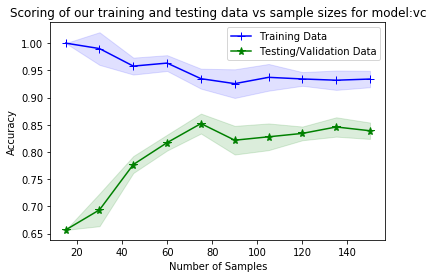

Confusion matrix, without normalization
[[19  8]
 [ 4 44]]


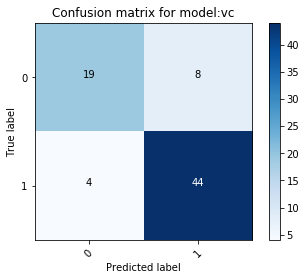

Code block 'learning_curve' took(HH:MM:SS): 0:00:01.292966
inside decision function


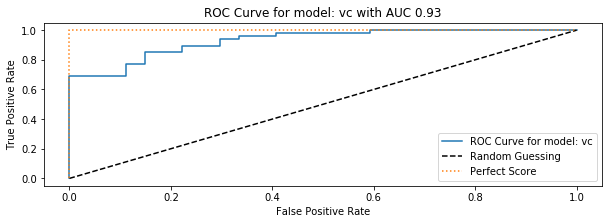

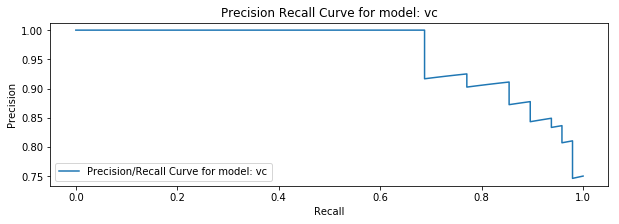

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.278230
Code block 'overalltime' took(HH:MM:SS): 0:00:01.670722
1670.722272094281


In [57]:
classifiers_1 = [vc]
classifiers_1_names = ['vc']
classifiers_1_param_grid = [{}]
response_vc = execute(
         _x_train_tomek,
        _y_train_tomek,
        x_test,
        y_test,
        classifiers_1,
        classifiers_1_names,
        classifiers_1_param_grid,
        cv=cv,
        score=score,
        scaler=StandardScaler())

In [58]:
test_target = response_vc.get('vc').get('best_estimator').predict(test_data_x)

In [59]:
np.bincount(test_target)

array([ 4847, 14903], dtype=int64)

In [60]:
final_submission = panda.DataFrame({'target':test_target})
final_submission['id'] = test_data['id']
final_submission[['id','target']].head() 

# np.bincount(test_target)

final_submission[['id','target']].to_csv('sample_submission_11.csv', index = False)